In [ ]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

In [3]:
# Load tabular dataset as a datafram
df = pd.read_csv('df_full.csv')

In [4]:
# Inspect dataset for obvious errors
pd.set_option('display.max_columns', None)
print(f"Shape: {df.shape}")
df

Shape: (70602, 47)


0        return  \
0      0x0000000000000000000000005e1f859c104cfc94b0fa... -4.989196e-03   
1      0x000000000000000000000000c5d563a36ae78145c45a...  1.646288e-02   
2      0x00000000000000000000000059ee6c6a56d7b00223f0...  1.365160e-02   
3      0x000000000000000000000000e0b7e9c90bf84274a846... -1.135011e-03   
4      0x000000000000000000000000c580c51f81c033d7c300... -6.076547e-04   
...                                                  ...           ...   
70597  0x000000000000000000000000949a5a280d7c84a617e2...  0.000000e+00   
70598  0x00000000000000000000000057abae16e821208faaae...  0.000000e+00   
70599  0x000000000000000000000000d2fa43d200642ca8f023... -4.733726e-02   
70600  0x000000000000000000000000d1d1dba7376a3aef7149...  3.505156e-02   
70601  0x000000000000000000000000815f69ba067170eecf49...  8.697570e-12   

       momentum  average_holding_time  risk_tolerance  intraday_closeout_rate  \
0      0.000000              6.866678        0.016467                0.166667   
1     -0.024975              0.127725        0.274557                0.015625   
2     -0.355412             13.481546        0.048730                0.040816   
3      0.095238              0.011921        0.010000                0.333333   
4     -0.153846              0.970879        0.010000                0.571429   
...         ...                   ...             ...                     ...   
70597  0.000000              0.000000        0.990000                0.333333   
70598  0.500000              0.000000        0.500000                0.500000   
70599  0.000000              0.000000        0.493000                0.333333   
70600  0.000000              0.000000        0.515000                0.333333   
70601  0.000000              0.000000        0.010000                0.333333   

       order_clustering_score  diversification_index  stop_loss_index  \
0                    0.463889               0.083382         0.749925   
1                    0.999990               0.010000         0.265975   
2                    0.956473               0.010000         0.463124   
3                    0.650789               0.060190         0.630134   
4                    0.171111               0.036293         0.685698   
...                       ...                    ...              ...   
70597                0.500000               0.500000         0.500000   
70598                0.500000               0.500000         0.500000   
70599                0.500000               0.500000         0.500000   
70600                0.500000               0.500000         0.500000   
70601                0.500000               0.500000         0.500000   

       win_rate  profit_factor  time_weighted_return  sharpe_ratio  \
0      0.333333       0.000000              0.008999      0.000000   
1      0.659308       1.350271                   inf      0.081628   
2      0.245685       0.752706             -0.174387     -0.064004   
3      0.100000       0.000000              0.008491     -0.140171   
4      0.038462       0.000000              0.008578     -0.134337   
...         ...            ...                   ...           ...   
70597  0.500000       1.000000              0.000000      0.000000   
70598  0.500000       1.000000              0.000000      0.000000   
70599  0.500000       1.000000              0.000000      0.000000   
70600  0.500000       1.000000              0.000000      0.000000   
70601  0.500000       1.000000              0.000000      0.000000   

       volatility_of_return  largest_exposure  mean_reversion_score  \
0                  0.000000      1.763546e+08              0.181818   
1                 30.764876      2.087049e+13              0.024977   
2                  0.868387      1.245646e+13              0.355466   
3                  0.000765      1.106617e+09              0.000000   
4                  0.000587      1.059458e+09              0.184615   
...                     ...               ...    

In [5]:
# Drop the "0" column (user ID) as it is just an unnecessary row label
df = df.drop(columns=['0'])

In [6]:
# Remove rows containing infinite values
# This is valid becuase only ~0.5% of rows contain infinite values, we can safely remove all of them while preserving most data
mask_finite_rows = np.isfinite(df).all(axis=1)
print("Number of rows being removed containing infinite values:", (~mask_finite_rows).sum())
df = df[mask_finite_rows]

Number of rows being removed containing infinite values: 370


In [7]:
# Check for missing values (by checking if any of the columns have any missing values, otherwise False is returned)
df.isna().any().any()

False

In [8]:
# Check summary statistics for each predictor to get a rough idea of data distribution
df.describe().T

count          mean           std           min  \
return                      70232.0 -3.455571e-02  8.037922e-01 -9.989899e-01   
momentum                    70232.0 -1.553084e-03  3.508537e-01 -9.944030e-01   
average_holding_time        70232.0  9.489295e-01  3.409416e+00  0.000000e+00   
risk_tolerance              70232.0  3.815306e-01  3.115817e-01  1.000000e-02   
intraday_closeout_rate      70232.0  2.884159e-01  9.693464e-02  1.562500e-02   
order_clustering_score      70232.0  3.718958e-01  2.269387e-01  3.000000e-02   
diversification_index       70232.0  2.787576e-01  1.791170e-01  1.000000e-02   
stop_loss_index             70232.0  5.549511e-01  1.047839e-01  1.629823e-01   
win_rate                    70232.0  4.138109e-01  1.617866e-01  1.377410e-03   
profit_factor               70232.0  9.581854e+02  1.395551e+05  0.000000e+00   
time_weighted_return        70232.0  3.718748e-02  3.902057e+00 -9.889071e-01   
sharpe_ratio                70232.0 -9.223672e-02  7.844999e+00 -9.980641e+01   
volatility_of_return        70232.0  1.086606e-01  3.095388e+00  0.000000e+00   
largest_exposure            70232.0  2.909060e+09  7.644674e+10  0.000000e+00   
mean_reversion_score        70232.0  3.634856e-01  3.170363e-01 -9.603175e-01   
position_sizing_score       70232.0  8.352702e+06  1.247002e+09 -4.313653e+05   
trade_sequencing_score      70232.0  4.908626e-01  6.677909e-02  1.538462e-02   
trading_confidence          70232.0 -9.888935e-02  3.877749e-01 -1.000000e+00   
trade_expectancy            70232.0  4.182715e+04  1.051859e+08 -1.340671e+10   
risk_of_ruin                70232.0  9.927274e-01  8.470064e-02  0.000000e+00   
kelly_criterion             70232.0  4.772024e-02  2.029047e-01  0.000000e+00   
trade_duration              70232.0  7.304168e-01  3.487612e+00 -5.425909e+01   
max_drawdown                70232.0  4.517518e+10  5.570049e+12 -0.000000e+00   
log_returns                 70232.0 -3.031242e-01  1.132554e+00 -6.897705e+00   
intial_value                70232.0  5.596042e+09  1.481703e+11  0.000000e+00   
different_rerturns          70232.0  4.285371e-01  3.523903e-01  0.000000e+00   
inferred_starting_balance   70232.0  5.590108e+09  1.479853e+11  0.000000e+00   
return_consistency          70232.0 -1.825153e-03  8.534808e-02 -8.347032e-01   
return_skewness             70232.0 -8.128736e-02  6.898191e-01 -1.853745e+01   
return_kurtosis             70232.0  2.565568e-01  4.660813e+00 -2.000000e+00   
return_mad                  70232.0  2.099255e-02  1.025050e+00  0.000000e+00   
outlier_ratio               70232.0  1.170992e-02  5.023819e-02  0.000000e+00   
gini_bet_size               70232.0  2.381050e-01  2.588770e-01  0.000000e+00   
gini_return_distribution    70232.0  9.933888e-02  1.949466e-01 -2.220446e-16   
log_return                  70232.0 -3.065979e-01  1.137083e+00 -6.897705e+00   
panic_sell_score            70232.0  6.713822e-02  2.135104e-01  0.000000e+00   
realized_return_ratio       70232.0 -7.808758e-01  3.391197e-01 -1.000000e+00   
mark_to_market_return       70232.0  9.317654e-01  8.219581e-01  0.000000e+00   
per_trade_profitability     70232.0  5.170701e-02  3.916251e+00 -9.986571e-01   
return_on_invested_capital  70232.0 -3.541483e-02  8.038636e-01 -9.989899e-01   
outcome_adjusted_return     70232.0  4.964491e+01  1.822188e+02  0.000000e+00   
simple_cash_multiple        70232.0  9.317654e-01  8.219581e-01  0.000000e+00   
cost_basis_returns          70232.0 -1.187639e-01  1.043212e+01 -2.666881e+03   
news_alpha                  70232.0 -7.358117e-04  5.344225e-02 -7.989319e-01   
news_alpha_short            70232.0 -3.245826e-04  3.059039e-02 -6.544300e-01   
average_portfolio_risked    70232.0  8.352743e+10  1.247002e+13 -4.313610e+05   

                                     25%           50%           75%  \
return                     -7.915414e-02 -1.001560e-03  5.355497e-03   
momentum                   -2.500000e-01  0.000000e+00  2.500000e-01   
averag

In [9]:
neg = (df['return'] < 0).sum()
pos = (df['return'] > 0).sum()

# proportion of people losing money compared to winning money
prop_losers = neg / (neg + pos)
prop_losers

0.6296728440895246

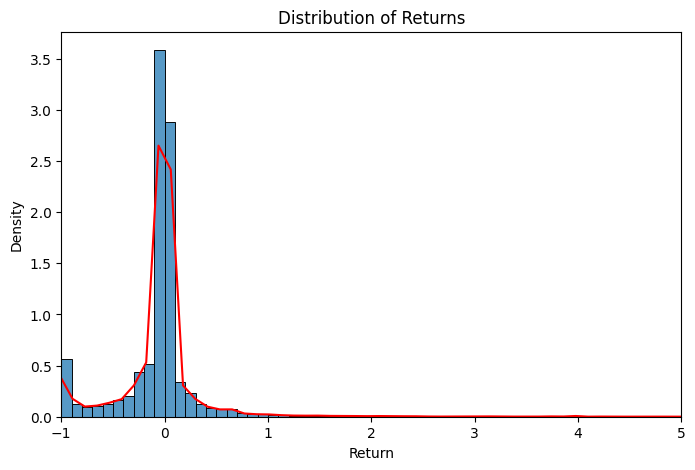

In [10]:
# Plot distribution of returns ("return" column)

bins = np.arange(-1, 5.1, 0.1)
plt.figure(figsize=(8,5))
sns.histplot(df['return'], bins=bins, stat='density')

# Plot a line to visualise the returns distribution
sns.kdeplot(df['return'], bw_adjust=0.5, gridsize=1000, color='red')
plt.title("Distribution of Returns")
plt.xlabel("Return")
plt.ylabel("Density")
plt.xlim(-1, 5)
plt.show()

# NOTE: The tail towards higher return values is extremelely large, with a maximum value of 117
# Only a subsection of the x-axis is shown to allow us to see what is going on around x=0

In [11]:
# Drop columns which are synonymous with returns or derived directly from it
# In theory we shouldn't know this information, and would result in data leakage
columns_to_drop = ['return_on_invested_capital', 'mark_to_market_return', 'different_rerturns', 'log_returns', 'cost_basis_returns', 'outcome_adjusted_return', 'time_weighted_return']
df = df.drop(columns=columns_to_drop)
# We keep log_return to allow us to choose either "return" or "log_return" in the modelling section (NOTE: we remove "log_returns", a duplicate column, above)

# Remove columns which are derived using the same data used to calculate returns
# For example realized_return_ratio uses profit and loss in it's calculation (data leakage)
extra_columns_to_drop = ['realized_return_ratio', 'simple_cash_multiple', 'return_skewness', 'return_kurtosis', 'return_mad', 'volatility_of_return', 'gini_return_distribution']
df = df.drop(columns=extra_columns_to_drop)

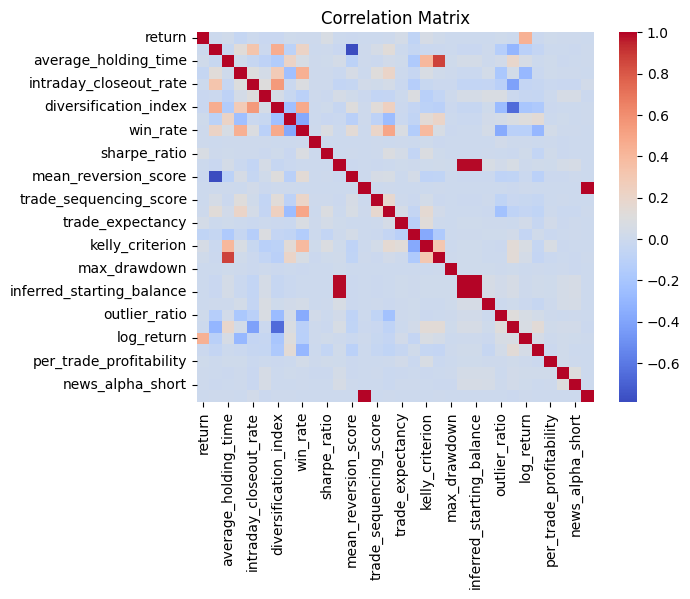

In [12]:
# Check for obvious collinearity using a correlation heatmap
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [13]:
# Check which columns are collinear with each other
# Use VIF, any value above 10 is removed one by one iteratively until all are below 10
clean_df = df.copy()

def compute_vif(df_features):
    # keep only numeric columns and drop any NaNs/infs
    clean = df_features.select_dtypes(include=[np.number]).dropna()
    vif_values = []
    for i, col in enumerate(clean.columns):
        vif = variance_inflation_factor(clean.values, i)
        vif_values.append(vif)
    return pd.DataFrame({
        'feature': clean.columns,
        'VIF': vif_values
    }).sort_values('VIF', ascending=False)

vif_df = compute_vif(clean_df)

In [14]:
# position_sizing_score measures the same thing as average_portfolio_risked, remove position_sizing_score
# inferred_starting_balance is the same as intial_value, remove inferred_starting_balance
# largest_exposure correlates strongly with initial_value because people tend to bet their full account balance at some point, remove largest_exposure (gives same info)
# mean_reversion_score is essentially the negative of momentum, remove mean_reversion_score
# trade_duration measures the same thing as average_holding_time, remove trade_duration

collinear_features = ['position_sizing_score', 'inferred_starting_balance', 'largest_exposure', 'mean_reversion_score', 'trade_duration']
clean_df = clean_df.drop(columns=collinear_features)

In [15]:
vif_df = compute_vif(clean_df)

In [16]:
# All VIFs are below 10 so we have dealt with collinearity satisfactorily
vif_df

feature       VIF
6      diversification_index  3.857765
8                   win_rate  3.263847
20             gini_bet_size  2.086483
15           kelly_criterion  1.992656
4     intraday_closeout_rate  1.521249
3             risk_tolerance  1.464059
21                log_return  1.399123
12        trading_confidence  1.362407
1                   momentum  1.280341
2       average_holding_time  1.267997
0                     return  1.256471
19             outlier_ratio  1.214422
22          panic_sell_score  1.177050
7            stop_loss_index  1.148911
5     order_clustering_score  1.078623
13          trade_expectancy  1.025127
10              sharpe_ratio  1.023552
18        return_consistency  1.022712
24                news_alpha  1.018258
25          news_alpha_short  1.017936
17              intial_value  1.016530
23   per_trade_profitability  1.006317
9              profit_factor  1.000941
26  average_portfolio_risked  1.000932
16              max_drawdown  1.000741
11    trade_sequencing_score  0.899195
14              risk_of_ruin  0.544798

In [17]:
# Perform a linear regression (clean dataset, to be compared to full dataset with collinearity)
# Outcome variable: return (drop log_return)
clean_return_df = clean_df.drop(columns=['log_return'])

X = clean_return_df.drop(columns=['return'])
y = clean_return_df['return']

# 85/15 train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=1
)

# Add intercept
X = sm.add_constant(X_train)
ols = sm.OLS(y_train, X).fit()

print(ols.summary())

# Evaluate on test set (cross validation)
X_test = sm.add_constant(X_test)
y_test_pred = ols.predict(X_test)
print("Test R²:", r2_score(y_test, y_test_pred))

                            OLS Regression Results                            
Dep. Variable:                 return   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     41.65
Date:                Thu, 01 May 2025   Prob (F-statistic):          1.79e-154
Time:                        18:15:47   Log-Likelihood:                -73677.
No. Observations:               59697   AIC:                         1.474e+05
Df Residuals:                   59677   BIC:                         1.476e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

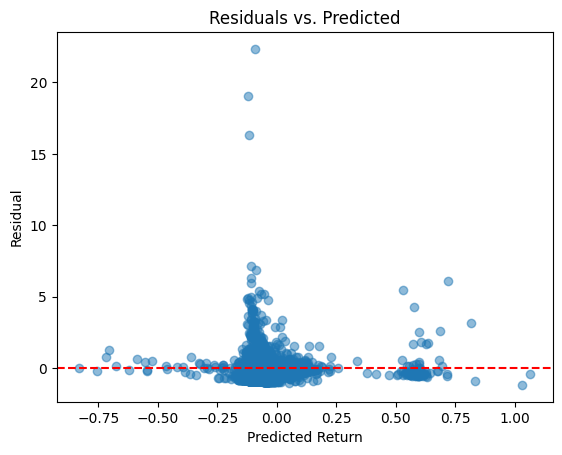

In [18]:
# Residual diagnostics to evaluate model performance (outcome variable: return)
residual = y_test - y_test_pred
plt.scatter(y_test_pred, residual, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Return")
plt.ylabel("Residual")
plt.title("Residuals vs. Predicted")
plt.show()

As seen from the above initial results, the non-transformed "return" outcome variable results in a very poor linear regression model.

We instead see if we have better results with an initial "log_return" linear regression.

In [19]:
# Perform a linear regression using log returns instead
# Outcome variable: return (drop return)
clean_log_return_df = clean_df.drop(columns=['return'])

X = clean_log_return_df.drop(columns=['log_return'])
y = clean_log_return_df['log_return']

# 85/15 train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=1
)

# Add intercept
X = sm.add_constant(X_train)
ols = sm.OLS(y_train, X).fit()

print(ols.summary())

# Evaluate on test set (cross validation)
X_test = sm.add_constant(X_test)
y_test_pred = ols.predict(X_test)
print("Test R²:", r2_score(y_test, y_test_pred))

                            OLS Regression Results                            
Dep. Variable:             log_return   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     396.9
Date:                Thu, 01 May 2025   Prob (F-statistic):               0.00
Time:                        18:15:48   Log-Likelihood:                -88726.
No. Observations:               59697   AIC:                         1.775e+05
Df Residuals:                   59677   BIC:                         1.777e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

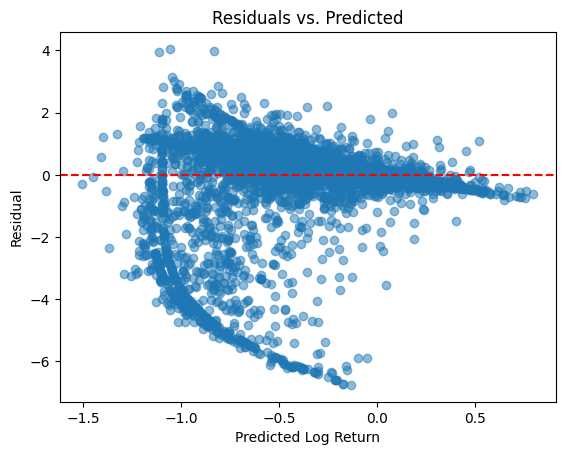

In [20]:
# Residual diagnostics to evaluate model performance (outcome variable: log_return)
residual = y_test - y_test_pred
plt.scatter(y_test_pred, residual, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Log Return")
plt.ylabel("Residual")
plt.title("Residuals vs. Predicted")
plt.show()

TALK ABOUT THIS IN THE REPORT WHEN EVALUATING THE PERFORMANCE OF THE RETURNS VS LOG RETURNS MODELS:
Raw return residuals (first linear regression model) were extremely skewed and heavy-tailed.

Log return residuals (second lienar regression model) are far closer to normal, meaning homoscedasticity and normal errors assumptions are closer to being satisfied. We now continue to refine this log return model since it performs much better initially in comparison.

We plot log returns against every predictor to see if the linear relationship assumption is satisfied. If not, we determine which transformations are appropriate.

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/122243217.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('bin')[[col,'log_return']]


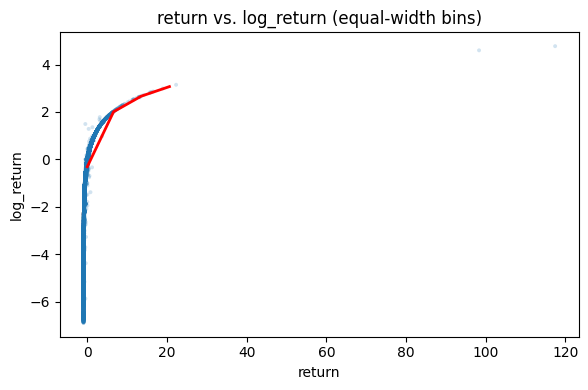

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/122243217.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('bin')[[col,'log_return']]


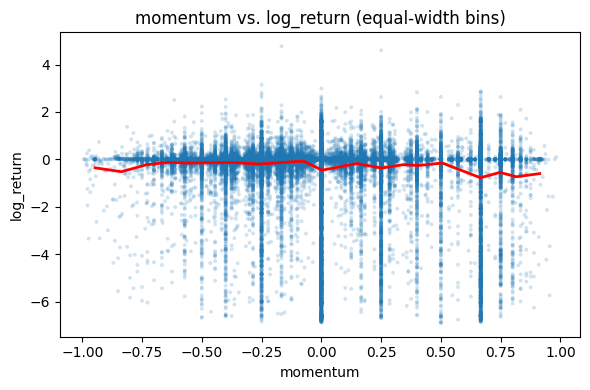

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/122243217.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('bin')[[col,'log_return']]


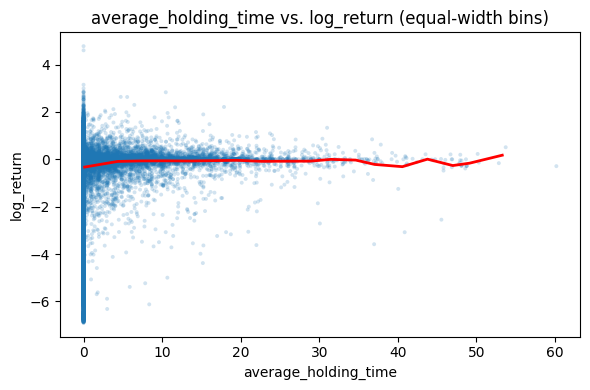

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/122243217.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('bin')[[col,'log_return']]


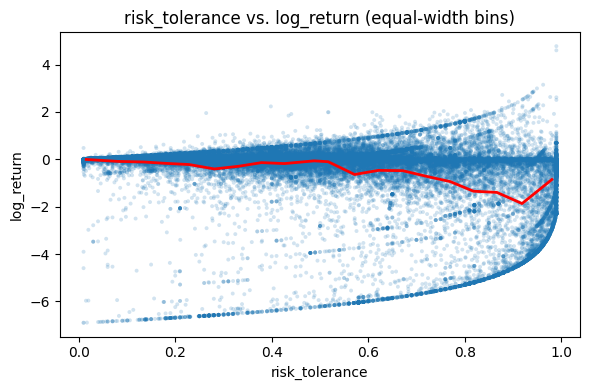

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/122243217.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('bin')[[col,'log_return']]


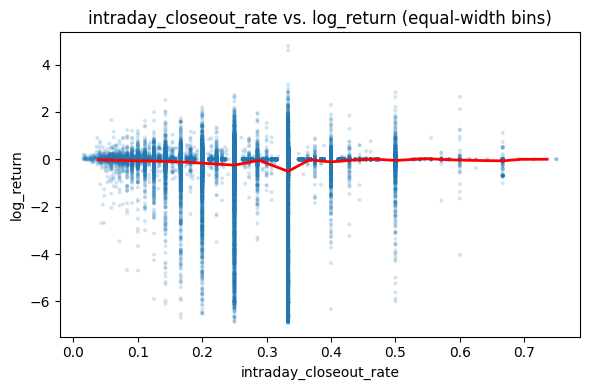

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/122243217.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('bin')[[col,'log_return']]


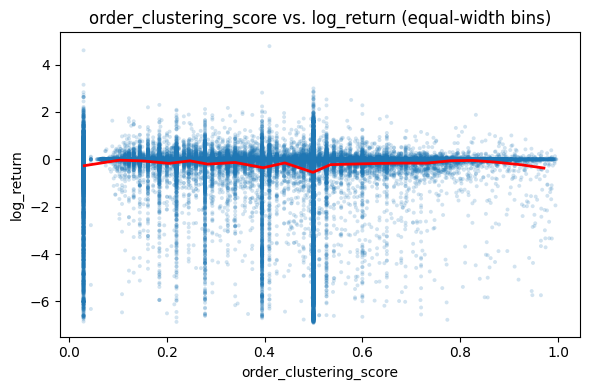

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/122243217.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('bin')[[col,'log_return']]


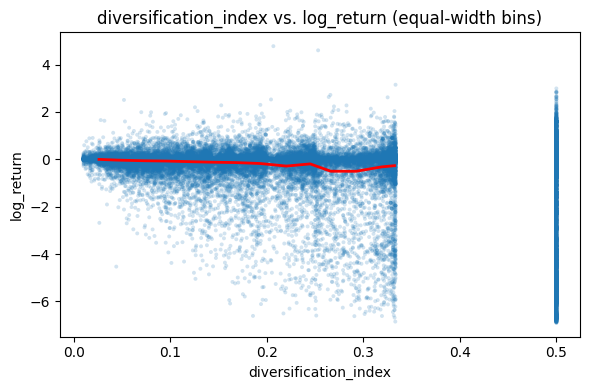

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/122243217.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('bin')[[col,'log_return']]


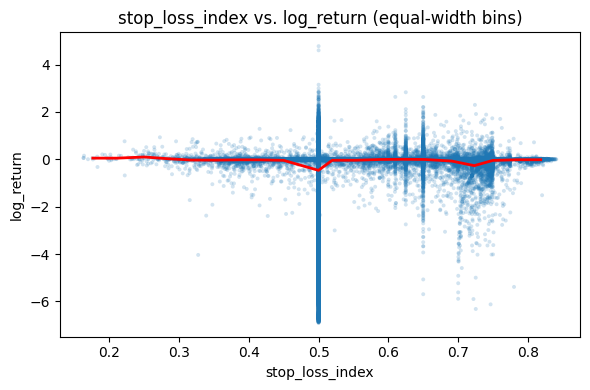

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/122243217.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('bin')[[col,'log_return']]


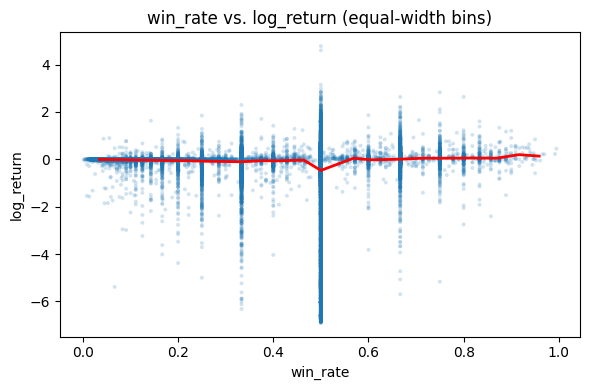

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/122243217.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('bin')[[col,'log_return']]


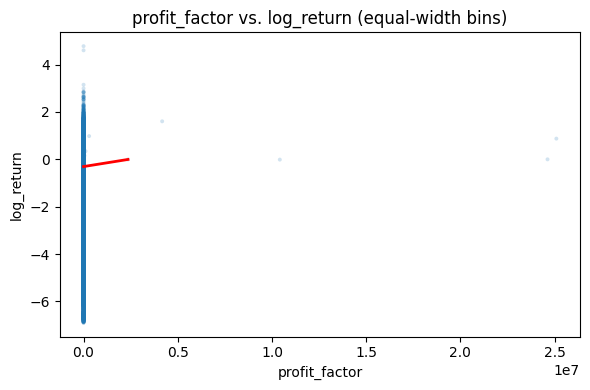

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/122243217.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('bin')[[col,'log_return']]


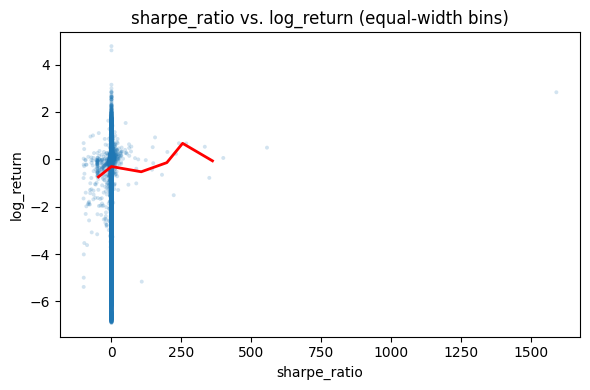

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/122243217.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('bin')[[col,'log_return']]


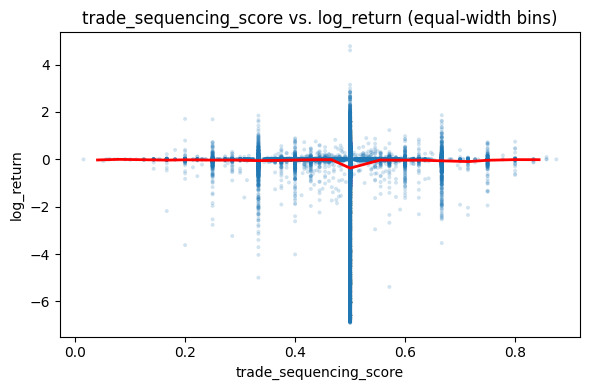

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/122243217.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('bin')[[col,'log_return']]


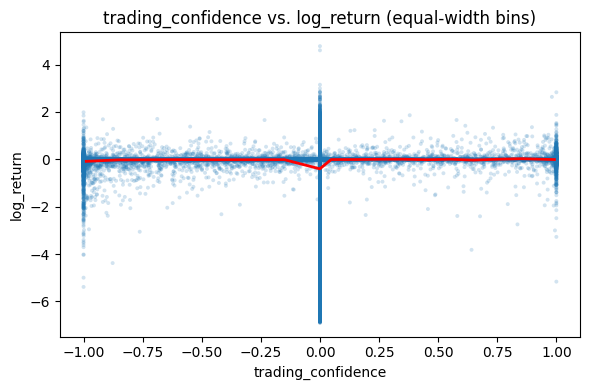

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/122243217.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('bin')[[col,'log_return']]


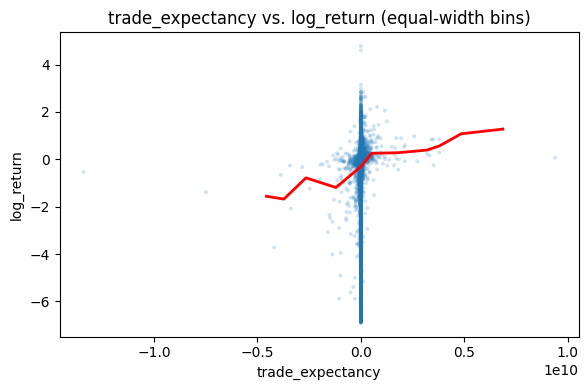

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/122243217.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('bin')[[col,'log_return']]


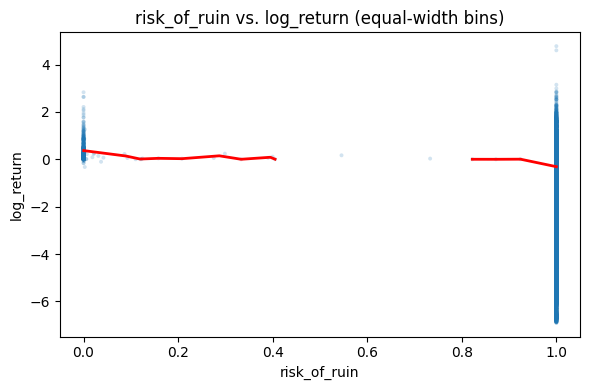

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/122243217.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('bin')[[col,'log_return']]


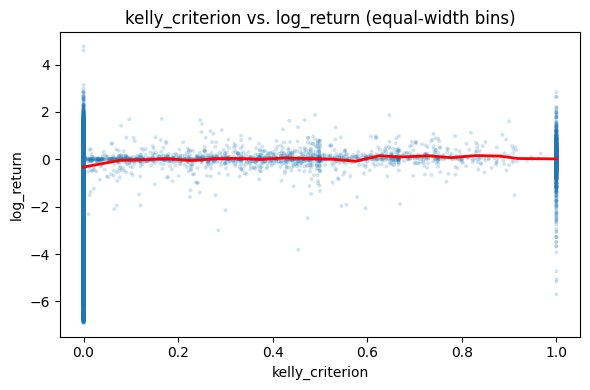

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/122243217.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('bin')[[col,'log_return']]


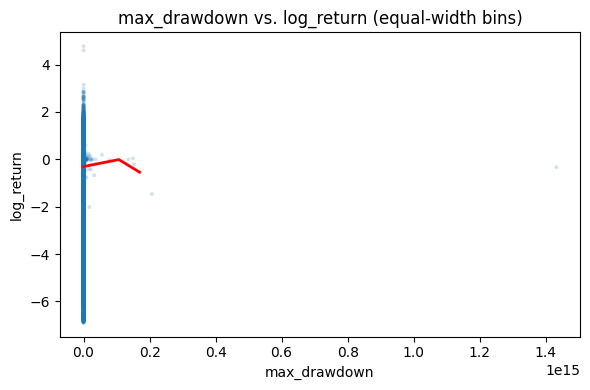

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/122243217.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('bin')[[col,'log_return']]


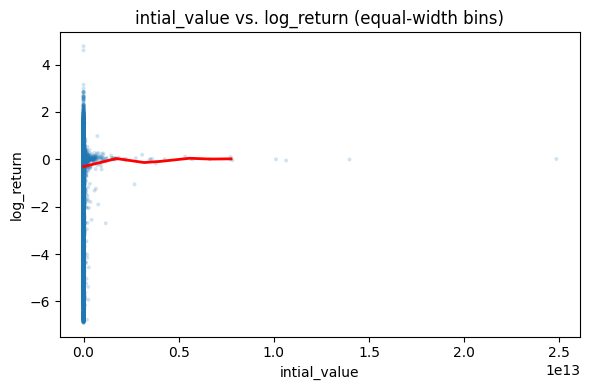

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/122243217.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('bin')[[col,'log_return']]


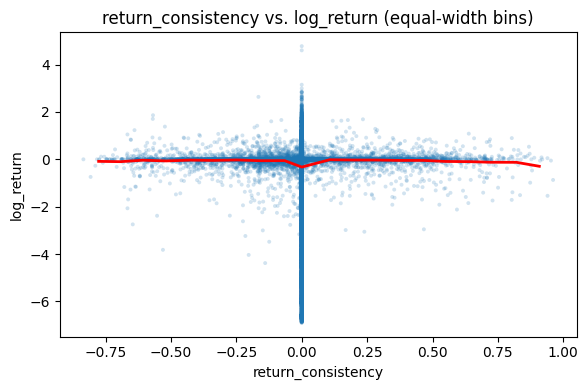

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/122243217.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('bin')[[col,'log_return']]


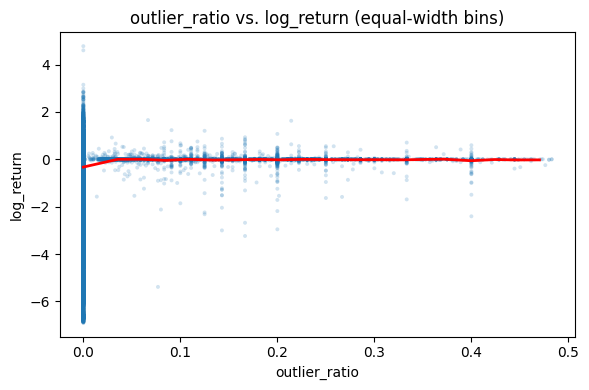

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/122243217.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('bin')[[col,'log_return']]


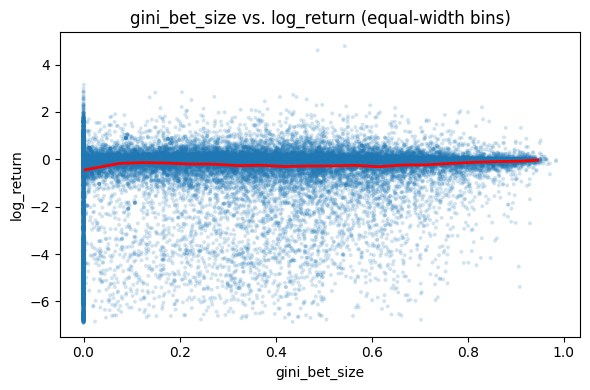

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/122243217.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('bin')[[col,'log_return']]


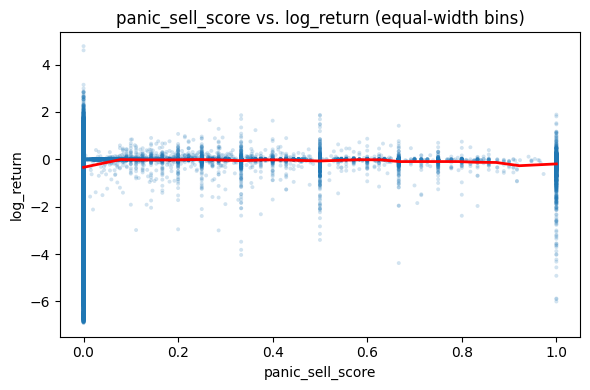

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/122243217.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('bin')[[col,'log_return']]


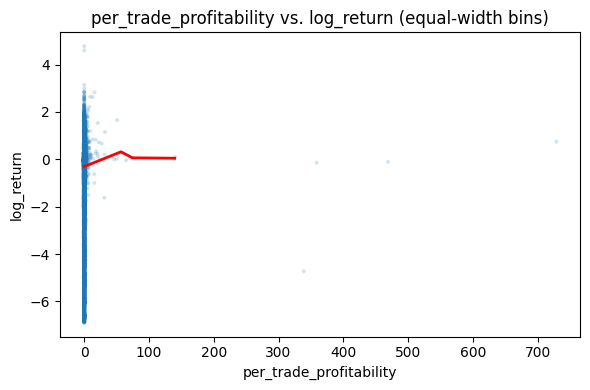

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/122243217.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('bin')[[col,'log_return']]


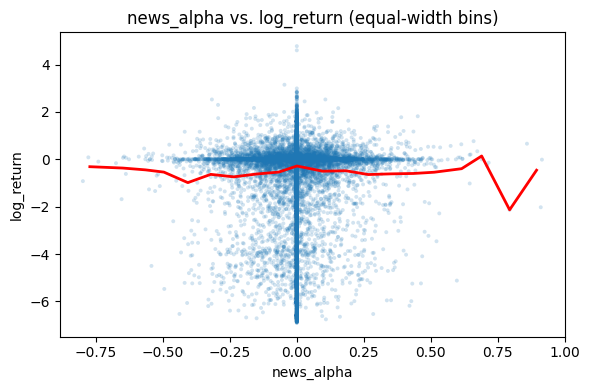

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/122243217.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('bin')[[col,'log_return']]


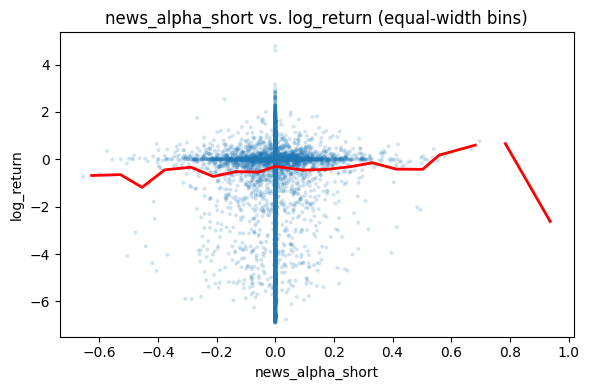

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/122243217.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('bin')[[col,'log_return']]


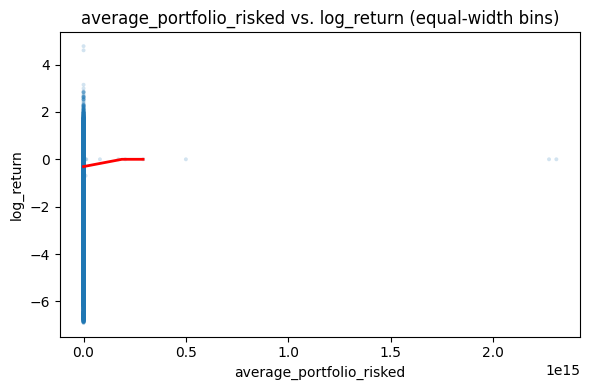

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

features = [c for c in clean_df.columns if c != 'log_return']

for col in features:
    # drop NaNs for this feature + outcome
    df_tmp = clean_df[[col,'log_return']].dropna()
    x = df_tmp[col].values
    y = df_tmp['log_return'].values

    # build 20 equal-width bins between min and max of x
    edges = np.linspace(x.min(), x.max(), 21)
    df_tmp['bin'] = pd.cut(x, bins=edges, include_lowest=True)

    # compute mean x and mean y in each bin
    bin_means = (
        df_tmp
          .groupby('bin')[[col,'log_return']]
          .mean()
          .reset_index(drop=True)
    )

    # plot scatter + trend‐line
    plt.figure(figsize=(6,4))
    plt.scatter(x, y, s=8, alpha=0.2, edgecolor='none')
    plt.plot(bin_means[col], bin_means['log_return'], color='red', linewidth=2)
    plt.xlabel(col)
    plt.ylabel('log_return')
    plt.title(f'{col} vs. log_return (equal‐width bins)')
    plt.tight_layout()
    plt.show()





Based on the above scatter plots, we identify 5 predictors with values concentrated towards the lower end of the x-axis, with a very long and sparse right tail:
- average_holding_time
- profit_factor
- max_drawdown
- intial_value
- per_trade_profitability

We address these by log transforming them to satisfy linearity.

In [22]:
# Transform non-linear variable relationships

clean_df = df.copy()
clean_df = clean_df.drop(columns=collinear_features)

clean_df['log_average_holding_time'] = np.log1p(clean_df['average_holding_time'])
clean_df['log_profit_factor'] = np.log1p(clean_df['profit_factor'])
clean_df['log_max_drawdown'] = np.log1p(clean_df['max_drawdown'])
clean_df['log_intial_value'] = np.log1p(clean_df['intial_value'])
clean_df['log_per_trade_profitability'] = np.log1p(clean_df['per_trade_profitability'])

clean_df = clean_df.drop(columns=['average_holding_time', 'profit_factor', 'max_drawdown', 'intial_value', 'per_trade_profitability'])


# Perform a linear regression using log returns instead
# Outcome variable: return (drop return)
clean_log_return_df = clean_df.drop(columns=['return'])

X = clean_log_return_df.drop(columns=['log_return'])
y = clean_log_return_df['log_return']

# 85/15 train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=1
)

# Add intercept
X = sm.add_constant(X_train)
ols = sm.OLS(y_train, X).fit()

print(ols.summary())

# Evaluate on test set (cross validation)
X_test = sm.add_constant(X_test)
y_test_pred = ols.predict(X_test)
print("Test R²:", r2_score(y_test, y_test_pred))

                            OLS Regression Results                            
Dep. Variable:             log_return   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     507.2
Date:                Thu, 01 May 2025   Prob (F-statistic):               0.00
Time:                        18:15:53   Log-Likelihood:                -88250.
No. Observations:               59697   AIC:                         1.765e+05
Df Residuals:                   59679   BIC:                         1.767e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [23]:
# NOTE: We do not perform backwards elimination since the goal of this modelling is inference.
# We want to preserve as much information as possible.
# This is explained in more detail in the final report. 

In [24]:
# Test 5 suspected interaction pairs to see which are significant

# Make sure we still have X_train (without const) and the features list
features = X_train.columns.tolist()

# Define the five interactions you want to test
interactions = [
    ('momentum',              'risk_tolerance'),
    ('stop_loss_index',       'log_average_holding_time'),
    ('diversification_index', 'log_profit_factor'),
    ('news_alpha',            'news_alpha_short'),
    ('win_rate',              'trade_expectancy')
]

results = []

for a, b in interactions:
    # 1) Build X_int by re-adding constant to the raw X_train
    X_int = sm.add_constant(X_train.copy())

    # 2) Create the interaction column
    X_int[f'{a}_x_{b}'] = X_train[a] * X_train[b]

    # 3) Fit the extended model
    m1 = sm.OLS(y_train, X_int).fit()

    # 4) Likelihood‐ratio test vs. base (df=1 for one extra term)
    lr_stat, lr_pvalue, _ = m1.compare_lr_test(ols)

    # 5) Record results
    results.append({
        'interaction':     f'{a}×{b}',
        'coef':            m1.params[f'{a}_x_{b}'],
        'p_value':         lr_pvalue,
        'delta_R2':        m1.rsquared - ols.rsquared
    })

# Summarize in a DataFrame
import pandas as pd
interaction_df = pd.DataFrame(results).set_index('interaction')
print(interaction_df)

                                                  coef        p_value  \
interaction                                                             
momentum×risk_tolerance                  -8.825334e-01  4.705624e-104   
stop_loss_index×log_average_holding_time -2.057518e-01   1.000000e+00   
diversification_index×log_profit_factor  -2.278490e-01   8.875633e-04   
news_alpha×news_alpha_short               7.317066e-02            NaN   
win_rate×trade_expectancy                 1.939225e-10   1.000000e+00   

                                          delta_R2  
interaction                                         
momentum×risk_tolerance                   0.006841  
stop_loss_index×log_average_holding_time -0.000062  
diversification_index×log_profit_factor   0.000162  
news_alpha×news_alpha_short              -0.000002  
win_rate×trade_expectancy                -0.000003  


Full final linear model with significant interactions (log returns)

In [25]:
# Final model including the two significant interactions

# training set with interactions included
X_train_int = sm.add_constant(X_train.copy())
X_train_int['momentum_x_risk_tolerance'] = (
    X_train['momentum'] * X_train['risk_tolerance']
)
X_train_int['diversification_index_x_log_profit_factor'] = (
    X_train['diversification_index'] * X_train['log_profit_factor']
)

# OLS model
final_model = sm.OLS(y_train, X_train_int).fit()
print(final_model.summary())

# Evaluate on test set
X_test_int = sm.add_constant(X_test.copy())
X_test_int['momentum_x_risk_tolerance'] = (
    X_test['momentum'] * X_test['risk_tolerance']
)
X_test_int['diversification_index_x_log_profit_factor'] = (
    X_test['diversification_index'] * X_test['log_profit_factor']
)

y_final_pred = final_model.predict(X_test_int)
print("Final Test R²:", r2_score(y_test, y_final_pred))

                            OLS Regression Results                            
Dep. Variable:             log_return   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     509.6
Date:                Thu, 01 May 2025   Prob (F-statistic):               0.00
Time:                        18:15:53   Log-Likelihood:                -88011.
No. Observations:               59697   AIC:                         1.761e+05
Df Residuals:                   59678   BIC:                         1.762e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

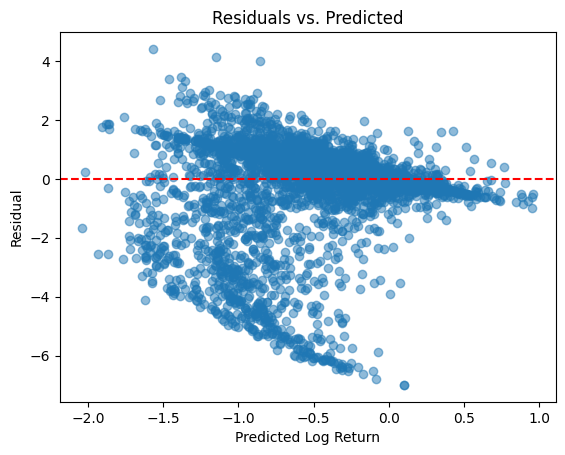

In [26]:
# Residual diagnostics to evaluate model performance (outcome variable: log_return)
residual = y_test - y_final_pred
plt.scatter(y_final_pred, residual, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Log Return")
plt.ylabel("Residual")
plt.title("Residuals vs. Predicted")
plt.show()

# OUTLIER ANALYSIS GOES HERE

In [27]:
"""
1. First metric is standardized residuals - A rule of thumb: standardized residuals > 2 (or < -2) may indicate an outlier. Some use 3 as a more conservative threshold.
2. Leverage (Hat Values)  - 2p/n (p is the number of predictors, n is the number of observations) is a common threshold for leverage. If a point has a leverage value greater than this threshold, it may be considered an influential point.
3. Cook's Distance - A common threshold is 4/n, where n is the number of observations. Points with a Cook's distance greater than this threshold may be considered influential.
4. . DFBETAS / DFFITS - DFBETAS measures the change in each coefficient when a point is removed. A common threshold is 2/sqrt(n) for DFBETAS. DFFITS measures the influence of a point on the fitted values. A common threshold is 2*sqrt(p/n) for DFFITS.
"""

"\n1. First metric is standardized residuals - A rule of thumb: standardized residuals > 2 (or < -2) may indicate an outlier. Some use 3 as a more conservative threshold.\n2. Leverage (Hat Values)  - 2p/n (p is the number of predictors, n is the number of observations) is a common threshold for leverage. If a point has a leverage value greater than this threshold, it may be considered an influential point.\n3. Cook's Distance - A common threshold is 4/n, where n is the number of observations. Points with a Cook's distance greater than this threshold may be considered influential.\n4. . DFBETAS / DFFITS - DFBETAS measures the change in each coefficient when a point is removed. A common threshold is 2/sqrt(n) for DFBETAS. DFFITS measures the influence of a point on the fitted values. A common threshold is 2*sqrt(p/n) for DFFITS.\n"

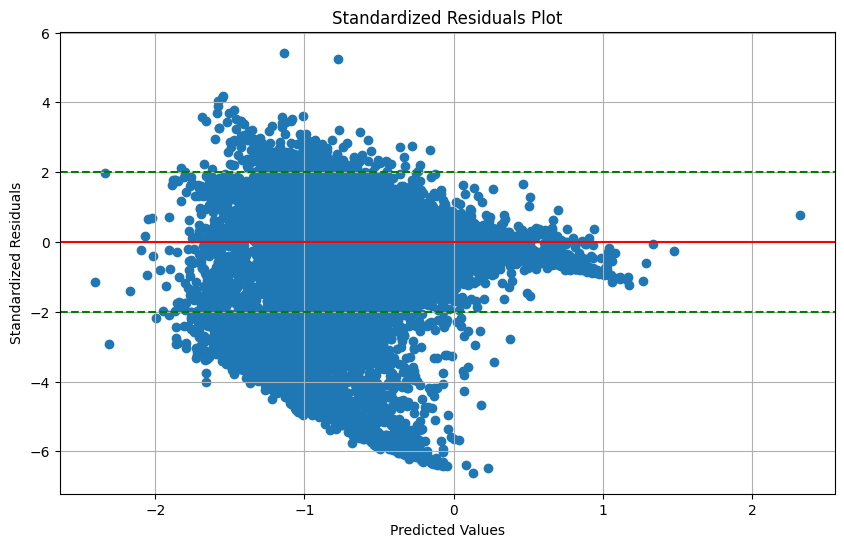

Number of potential outliers: 1938
Indices of potential outliers: [   48    66    72 ... 59651 59655 59667]


In [28]:
# Calculate standardized residuals for statsmodels OLS model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get the standardized residuals (internally calculated by statsmodels)
standardized_residuals = final_model.get_influence().resid_studentized_internal

# Plot the standardized residuals
plt.figure(figsize=(10, 6))
plt.scatter(final_model.fittedvalues, standardized_residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.axhline(y=2, color='g', linestyle='--')
plt.axhline(y=-2, color='g', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Standardized Residuals')
plt.title('Standardized Residuals Plot')
plt.grid(True)
plt.show()

# To get the standardized residuals as a pandas Series or array
std_residuals = final_model.get_influence().resid_studentized_internal

# If you want to identify potential outliers (abs value > 2)
potential_outliers = np.abs(std_residuals) > 3
print(f"Number of potential outliers: {np.sum(potential_outliers)}")

# To get the indices of the outliers
outlier_indices = np.where(potential_outliers)[0]
print(f"Indices of potential outliers: {outlier_indices}")

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/4278226682.py:11: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(leverage, use_line_collection=True)


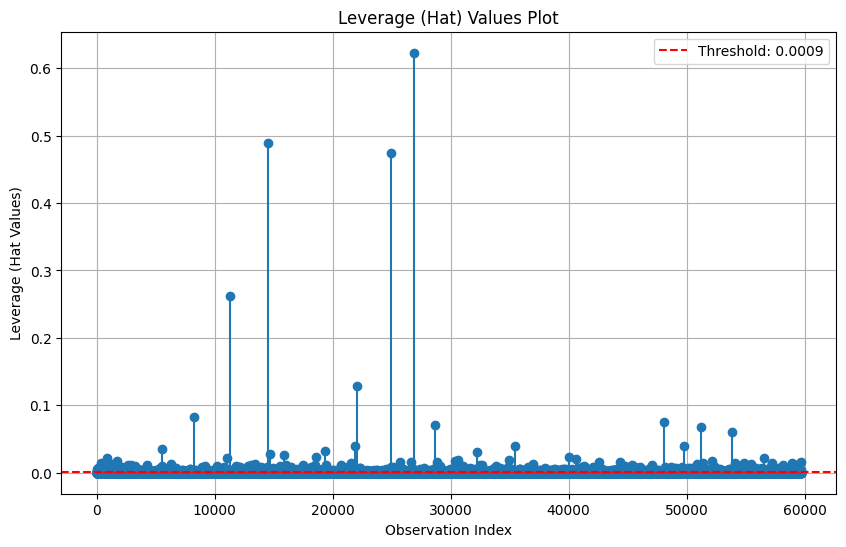

Number of high leverage points: 4915
Indices of high leverage points: [   14    16    17 ... 59665 59691 59694]

High Leverage Point Details:
       Index  Leverage_Value  Actual_Value  Predicted_Value  \
50618  26859        0.623024      2.828218         2.318784   
3335   14515        0.488683      0.000000         0.009442   
53773  24941        0.473655      0.000000         0.252067   
3882   11298        0.261867     -0.529508        -2.335067   
49502  22110        0.128674      0.063052         0.799844   
...      ...             ...           ...              ...   
36376   1570        0.000938     -0.319603        -0.421700   
6885   32430        0.000938      0.169305        -0.033520   
42727  39852        0.000938     -0.021806        -0.480854   
49404    811        0.000938     -0.205287        -0.049923   
1168   11300        0.000938      0.000754        -0.168760   

       Standardized_Residual  const  momentum  risk_tolerance  \
50618               0.784914    1.0 

In [29]:
# Calculate leverage (hat values) for statsmodels OLS model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get the leverage (hat) values from the model influence
leverage = final_model.get_influence().hat_matrix_diag

# Plot the leverage values
plt.figure(figsize=(10, 6))
plt.stem(leverage, use_line_collection=True)
plt.axhline(y=2*((X_train_int.shape[1])/X_train_int.shape[0]), color='r', linestyle='--', 
           label=f'Threshold: {2*((X_train_int.shape[1])/X_train_int.shape[0]):.4f}')
plt.xlabel('Observation Index')
plt.ylabel('Leverage (Hat Values)')
plt.title('Leverage (Hat) Values Plot')
plt.legend()
plt.grid(True)
plt.show()

# Find high leverage points
# A common rule of thumb is 2(p/n) or 3(p/n) where p is the number of parameters and n is the sample size
threshold = 2 * (X_train_int.shape[1] / X_train_int.shape[0])
high_leverage = leverage > threshold
high_leverage_indices = np.where(high_leverage)[0]

print(f"Number of high leverage points: {np.sum(high_leverage)}")
print(f"Indices of high leverage points: {high_leverage_indices}")

# Create a DataFrame with high leverage point details
if len(high_leverage_indices) > 0:
    # Convert pandas Series to numpy arrays to avoid indexing issues
    fittedvalues_array = final_model.fittedvalues.values
    standardized_residuals_array = standardized_residuals
    
    if hasattr(X_train_int, 'iloc'):  # If X_train_int is a DataFrame
        high_leverage_data = X_train_int.iloc[high_leverage_indices]
        high_leverage_target = y_train.iloc[high_leverage_indices] if hasattr(y_train, 'iloc') else y_train[high_leverage_indices]
    else:  # If X_train_int is a numpy array
        high_leverage_data = X_train_int[high_leverage_indices]
        high_leverage_target = y_train[high_leverage_indices]
    
    leverage_df = pd.DataFrame({
        'Index': high_leverage_indices,
        'Leverage_Value': leverage[high_leverage_indices],
        'Actual_Value': high_leverage_target,
        'Predicted_Value': fittedvalues_array[high_leverage_indices],
        'Standardized_Residual': standardized_residuals_array[high_leverage_indices]
    })
    
    # Add original features for context if X_train_int is a DataFrame
    if hasattr(X_train_int, 'iloc'):
        for col in X_train_int.columns:
            leverage_df[col] = high_leverage_data[col].values
    
    # Sort by leverage values (descending)
    leverage_df = leverage_df.sort_values(by='Leverage_Value', ascending=False)
    
    print("\nHigh Leverage Point Details:")
    print(leverage_df)
else:
    print("\nNo high leverage points found.")

# Identify influential points (both high leverage and high residual)
influential_points = (np.abs(standardized_residuals_array) > 2) & (leverage > threshold)
influential_indices = np.where(influential_points)[0]

print(f"\nNumber of influential points (both high leverage and high residual): {np.sum(influential_points)}")
print(f"Indices of influential points: {influential_indices}")

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/86623408.py:6: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(cooks_d, use_line_collection=True)


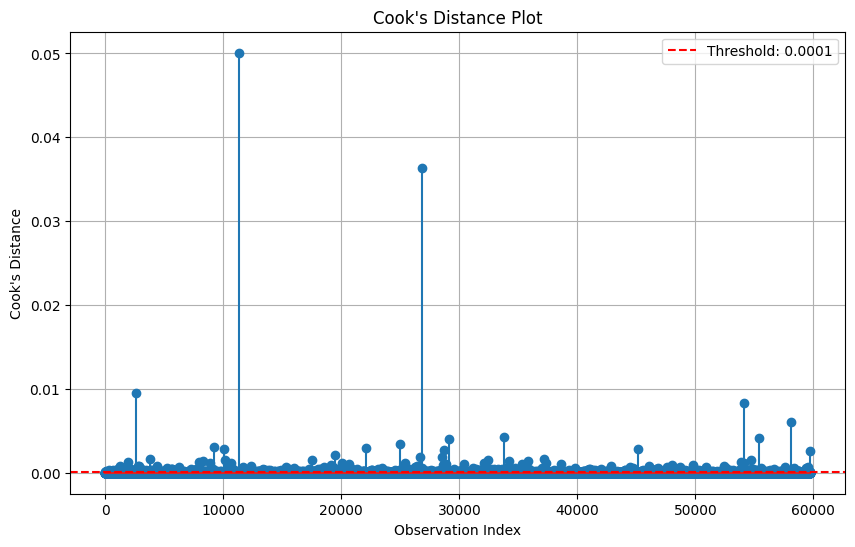


High Leverage Points Sorted by Cook's Distance:
       Index  Leverage_Value  Actual_Value  Predicted_Value  \
19342  46177        0.002726     -0.002467         0.112273   
48654  17844        0.001616      0.022618        -0.126420   
8047   38854        0.004954      0.090095        -0.064753   
10106  50614        0.000989     -0.004421        -0.142251   
17571  33509        0.000949      0.003145        -0.309848   
6980   42320        0.001358      0.195416        -0.113675   
1287    7946        0.000974     -0.465687        -0.586438   
20647  31910        0.001521      0.000644         0.114539   
33564  47475        0.001722     -0.000994        -0.585511   
2525   23784        0.002847      0.085327         0.228166   

       Standardized_Residual  const  momentum  risk_tolerance  \
19342              -0.108692    1.0 -0.083333        0.057325   
48654               0.141103    1.0  0.375000        0.349831   
8047                0.146851    1.0 -0.545455        0.303394 

In [30]:
# Calculate Cook's distance (another measure of influence)
cooks_d = final_model.get_influence().cooks_distance[0]

# Plot Cook's distance
plt.figure(figsize=(10, 6))
plt.stem(cooks_d, use_line_collection=True)
plt.axhline(y=4/(X_train_int.shape[0] - X_train_int.shape[1]), color='r', linestyle='--', 
           label=f'Threshold: {4/(X_train_int.shape[0] - X_train_int.shape[1]):.4f}')
plt.xlabel('Observation Index')
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance Plot")
plt.legend()
plt.grid(True)
plt.show()

# Add Cook's distance to the high leverage DataFrame if it exists
if 'leverage_df' in locals() and len(leverage_df) > 0:
    leverage_df['Cooks_Distance'] = cooks_d[high_leverage_indices]
    leverage_df = leverage_df.sort_values(by='Cooks_Distance', ascending=False)
    print("\nHigh Leverage Points Sorted by Cook's Distance:")
    print(leverage_df.head(10))  # Show top 10 most influential by Cook's distance

Top 20 Observations by Cook's Distance:
       Index  Cooks_Distance
11298  11298        0.050080
26859  26859        0.036364
2639    2639        0.009563
54099  54099        0.008262
58129  58129        0.006001
33814  33814        0.004226
55422  55422        0.004084
29094  29094        0.004071
24941  24941        0.003472
9205    9205        0.003119
22110  22110        0.002941
45131  45131        0.002835
10065  10065        0.002774
28673  28673        0.002734
59691  59691        0.002620
19435  19435        0.002162
26661  26661        0.001931
28531  28531        0.001816
3798    3798        0.001670
37185  37185        0.001584

Cook's Distance Threshold: 0.000067
Number of influential points by Cook's Distance: 1988


/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/3072656798.py:29: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(range(len(cooks_d)), cooks_d, use_line_collection=True)


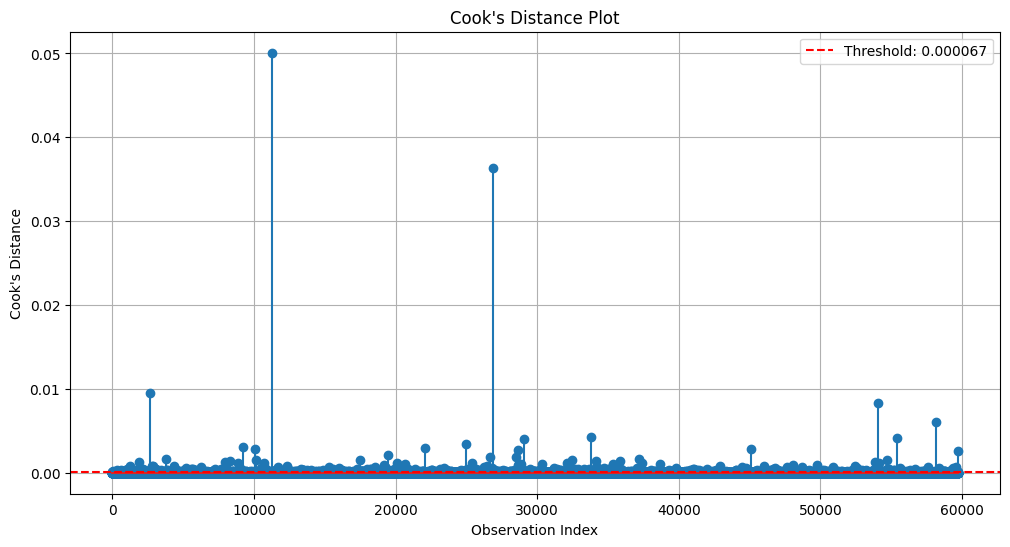

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/3072656798.py:41: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(range(len(cooks_d)), cooks_d, use_line_collection=True)


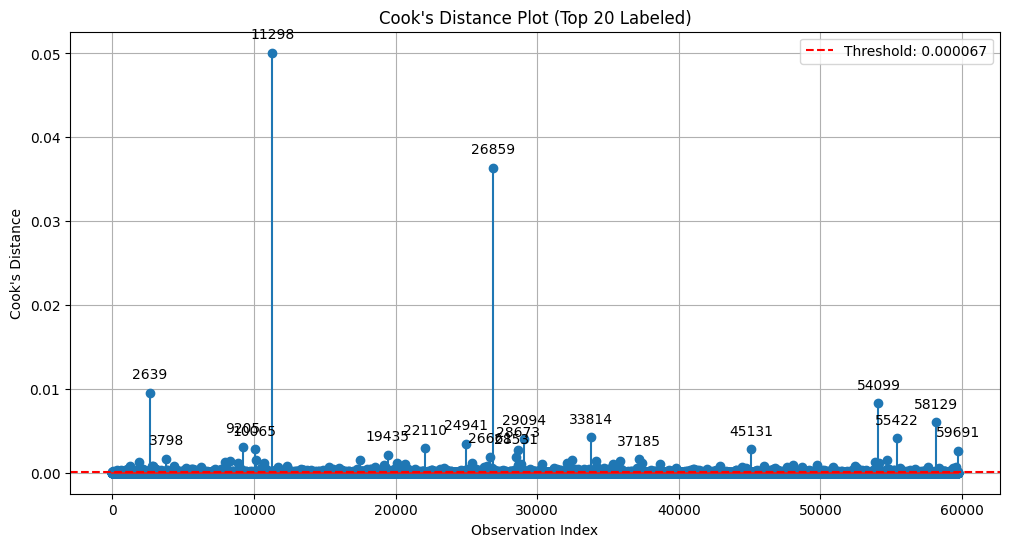


Detailed Influential Points by Cook's Distance:
       Index  Cooks_Distance  Leverage_Value  Standardized_Residual  \
3882   11298        0.050080        0.261867               1.988090   
50618  26859        0.036364        0.623024               0.784914   
2023    2639        0.009563        0.012122              -4.671485   
22985  54099        0.008262        0.014068              -4.026563   
49103  58129        0.006001        0.011707              -3.766215   
...      ...             ...             ...                    ...   
37212   8748        0.000067        0.001889               0.997938   
61570  11044        0.000067        0.000330              -2.390879   
46068  32289        0.000067        0.000095              -4.444387   
21490  49684        0.000067        0.000119              -3.971146   
23399  50427        0.000067        0.002870              -0.808484   

       Actual_Value  Predicted_Value  const  momentum  risk_tolerance  \
3882      -0.529508      

In [31]:
# Calculate Cook's distance
cooks_d = final_model.get_influence().cooks_distance[0]

# Create a DataFrame to display Cook's distance
cooks_df = pd.DataFrame({
    'Index': range(len(cooks_d)),
    'Cooks_Distance': cooks_d
})

# Sort by Cook's distance (descending)
cooks_df = cooks_df.sort_values(by='Cooks_Distance', ascending=False)

# Display the top influential observations by Cook's distance
print("Top 20 Observations by Cook's Distance:")
print(cooks_df.head(20))

# Calculate threshold for influential points
# A common threshold is 4/(n-k) where n is sample size and k is number of predictors
threshold = 4 / (X_train_int.shape[0] - X_train_int.shape[1])
print(f"\nCook's Distance Threshold: {threshold:.6f}")

# Identify influential points
influential_points = cooks_d > threshold
influential_indices = np.where(influential_points)[0]
print(f"Number of influential points by Cook's Distance: {np.sum(influential_points)}")

# Plot Cook's distance
plt.figure(figsize=(12, 6))
plt.stem(range(len(cooks_d)), cooks_d, use_line_collection=True)
plt.axhline(y=threshold, color='r', linestyle='--', 
           label=f'Threshold: {threshold:.6f}')
plt.xlabel('Observation Index')
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance Plot")
plt.legend()
plt.grid(True)
plt.show()

# Create a more detailed plot showing the most influential points
plt.figure(figsize=(12, 6))
plt.stem(range(len(cooks_d)), cooks_d, use_line_collection=True)
plt.axhline(y=threshold, color='r', linestyle='--', 
           label=f'Threshold: {threshold:.6f}')
plt.xlabel('Observation Index')
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance Plot (Top 20 Labeled)")

# Label the top 20 points
top_20_indices = cooks_df['Index'].head(20).values
for idx in top_20_indices:
    plt.annotate(str(idx), (idx, cooks_d[idx]), 
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center')

plt.legend()
plt.grid(True)
plt.show()

# If you want a detailed analysis of the influential points:
if len(influential_indices) > 0:
    if hasattr(X_train_int, 'iloc'):  # If X_train_int is a DataFrame
        influential_data = X_train_int.iloc[influential_indices]
        influential_target = y_train.iloc[influential_indices] if hasattr(y_train, 'iloc') else y_train[influential_indices]
    else:  # If X_train_int is a numpy array
        influential_data = X_train_int[influential_indices]
        influential_target = y_train[influential_indices]
    
    # Convert to numpy for indexing
    fittedvalues_array = final_model.fittedvalues.values
    standardized_residuals_array = standardized_residuals
    
    influential_df = pd.DataFrame({
        'Index': influential_indices,
        'Cooks_Distance': cooks_d[influential_indices],
        'Leverage_Value': leverage[influential_indices],
        'Standardized_Residual': standardized_residuals_array[influential_indices],
        'Actual_Value': influential_target,
        'Predicted_Value': fittedvalues_array[influential_indices]
    })
    
    # Add original features for context if X_train_int is a DataFrame
    if hasattr(X_train_int, 'iloc'):
        for col in X_train_int.columns:
            influential_df[col] = influential_data[col].values
    
    # Sort by Cook's distance (descending)
    influential_df = influential_df.sort_values(by='Cooks_Distance', ascending=False)
    
    print("\nDetailed Influential Points by Cook's Distance:")
    print(influential_df)

In [58]:
# Calculate DFBETAS and DFFITS for statsmodels OLS model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get influence measures
influence = final_model.get_influence()

# Calculate DFBETAS
dfbetas = influence.dfbetas
print(f"DFBETAS shape: {dfbetas.shape}")  # Shape will be (n_observations, n_parameters)

# Calculate DFFITS
dffits = influence.dffits
print(f"DFFITS shape: {dffits.shape}")    # Shape will be (n_observations,)

# Create thresholds
# For DFBETAS: 2/sqrt(n) is a common threshold
n = X_train_int.shape[0]
dfbetas_threshold = 2 / np.sqrt(n)
print(f"DFBETAS threshold: {dfbetas_threshold:.6f}")

# For DFFITS: 2*sqrt(p/n) is a common threshold
p = X_train_int.shape[1]
dffits_threshold = 2 * np.sqrt(p/n)
print(f"DFFITS threshold: {dffits_threshold:.6f}")

# Plot DFFITS
plt.figure(figsize=(12, 6))
plt.stem(range(len(dffits)), np.abs(dffits), use_line_collection=True)
plt.axhline(y=dffits_threshold, color='r', linestyle='--', 
           label=f'Threshold: {dffits_threshold:.6f}')
plt.xlabel('Observation Index')
plt.ylabel('|DFFITS|')
plt.title('DFFITS Plot (Absolute Values)')
plt.legend()
plt.grid(True)
plt.show()

# Find influential points according to DFFITS
dffits_influential = np.abs(dffits) > dffits_threshold
dffits_influential_indices = np.where(dffits_influential)[0]
print(f"Number of influential points by DFFITS: {np.sum(dffits_influential)}")
print(f"Indices of influential points by DFFITS: {dffits_influential_indices[:20]}...")  # Show first 20

# Create a DataFrame for DFFITS influential points
dffits_df = pd.DataFrame({
    'Index': range(len(dffits)),
    'DFFITS': dffits,
    'DFFITS_Abs': np.abs(dffits)
})
dffits_df = dffits_df.sort_values(by='DFFITS_Abs', ascending=False)
print("\nTop 20 Observations by |DFFITS|:")
print(dffits_df.head(20))

# For DFBETAS, we need to look at each coefficient
param_names = final_model.model.exog_names
num_params = len(param_names)

# Plot DFBETAS for each parameter (only plotting a few for readability)
max_plots = min(6, num_params)  # Limit to 6 parameters to avoid too many plots
plt.figure(figsize=(15, 10))

for i in range(max_plots):
    plt.subplot(max_plots, 1, i+1)
    plt.stem(range(len(dfbetas[:, i])), np.abs(dfbetas[:, i]), use_line_collection=True)
    plt.axhline(y=dfbetas_threshold, color='r', linestyle='--',
               label=f'Threshold: {dfbetas_threshold:.6f}')
    plt.ylabel(f'|DFBETAS| for {param_names[i]}')
    plt.grid(True)
    if i == 0:
        plt.title('DFBETAS Plot for Each Parameter (Absolute Values)')
    if i == max_plots-1:
        plt.xlabel('Observation Index')
    plt.legend()

plt.tight_layout()
plt.show()

# Create a summary DataFrame for DFBETAS
# Find observations that are influential for at least one parameter
dfbetas_abs = np.abs(dfbetas)
dfbetas_influential = dfbetas_abs > dfbetas_threshold
dfbetas_influential_any = np.any(dfbetas_influential, axis=1)
dfbetas_influential_indices = np.where(dfbetas_influential_any)[0]

print(f"Number of observations influential for at least one parameter (DFBETAS): {np.sum(dfbetas_influential_any)}")

# Create a summary DataFrame
if len(dfbetas_influential_indices) > 0:
    dfbetas_summary = pd.DataFrame({'Index': dfbetas_influential_indices})
    
    # Add the number of parameters each observation influences
    dfbetas_summary['Num_Params_Influenced'] = np.sum(dfbetas_influential[dfbetas_influential_indices], axis=1)
    
    # Add DFBETAS for each parameter
    for i, param in enumerate(param_names):
        param_short = param[:10]  # Truncate for readability
        dfbetas_summary[f'DFBETAS_{param_short}'] = dfbetas[dfbetas_influential_indices, i]
    
    # Add DFFITS
    dfbetas_summary['DFFITS'] = dffits[dfbetas_influential_indices]
    
    # Add other influence measures
    dfbetas_summary['Cooks_D'] = influence.cooks_distance[0][dfbetas_influential_indices]
    dfbetas_summary['Leverage'] = influence.hat_matrix_diag[dfbetas_influential_indices]
    
    # Sort by number of parameters influenced
    dfbetas_summary = dfbetas_summary.sort_values(by='Num_Params_Influenced', ascending=False)
    
    print("\nTop 20 Most Influential Observations by DFBETAS:")
    print(dfbetas_summary.head(20))

KeyboardInterrupt: 

In [ ]:
## takes forever ti run above code!

# Logistic regression carried out below

The original linear regression task is extremely difficult given the amount of noise present in the data. We instead consider an adjustment to the problem by turning it into a classification task.

Now we only care about which factors contribute to positive or negative returns, not the magnitude of these returns. We hope to achieve a model with more explanatory power allowing us to better answer our research question.

Logistic regression assumptions:
1. independence of error terms
- each row's error term is unrelated to every other row's error term
2. no multicollinearity
- VIF below 10 (already checked, same dataset as for linear regression)
3. linear relationship between each continuous predictor (all continuous) and the log-odds of the outcome
- check by plotting
4. no influential outliers
- likely not met since we don't exclude outliers

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/3081949024.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gb = df_tmp.groupby('bin')


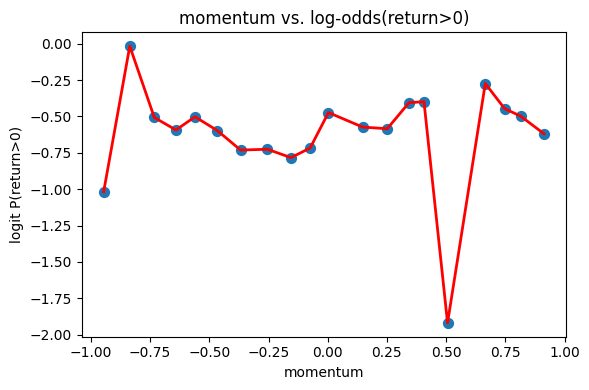

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/3081949024.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gb = df_tmp.groupby('bin')


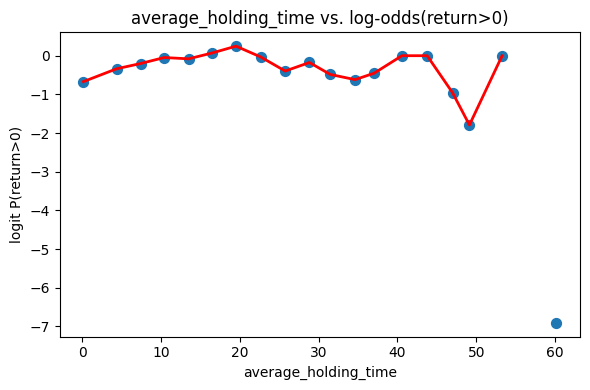

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/3081949024.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gb = df_tmp.groupby('bin')


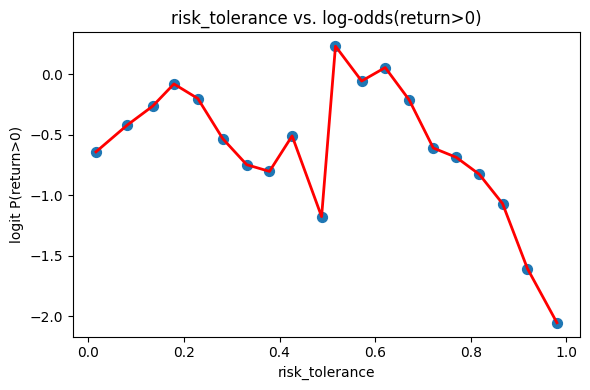

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/3081949024.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gb = df_tmp.groupby('bin')


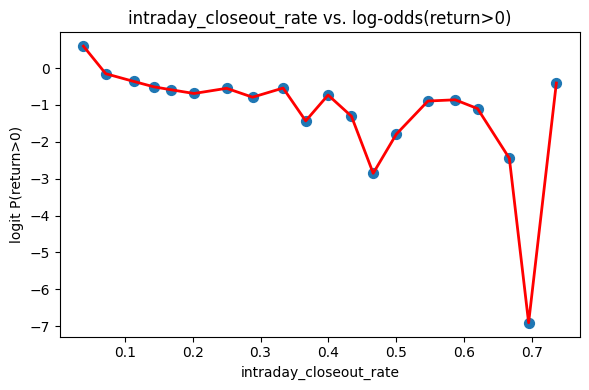

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/3081949024.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gb = df_tmp.groupby('bin')


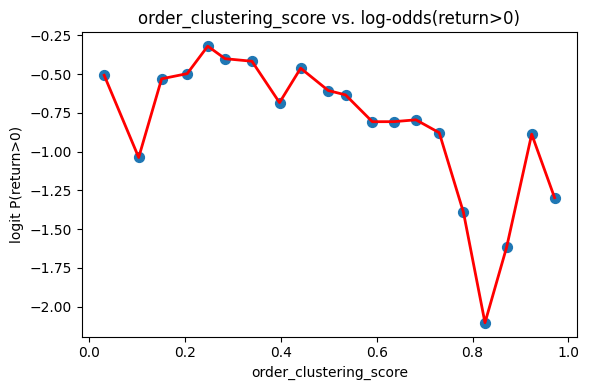

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/3081949024.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gb = df_tmp.groupby('bin')


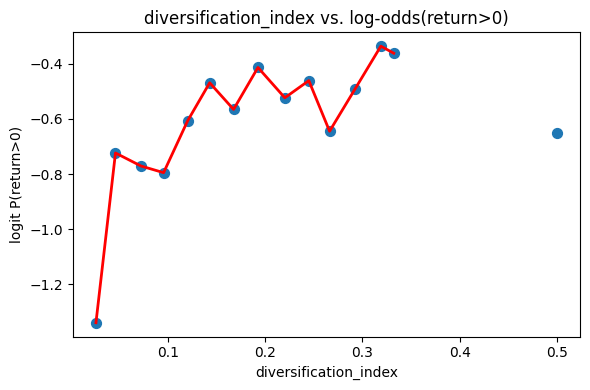

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/3081949024.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gb = df_tmp.groupby('bin')


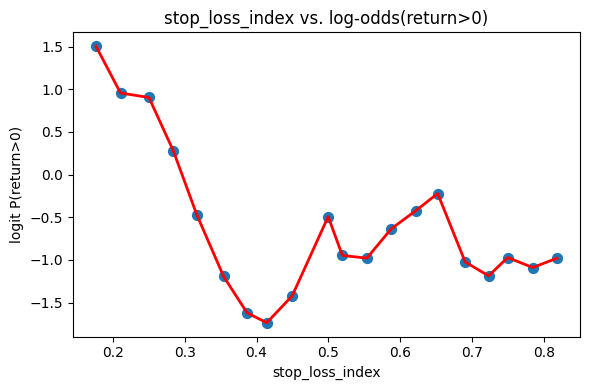

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/3081949024.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gb = df_tmp.groupby('bin')


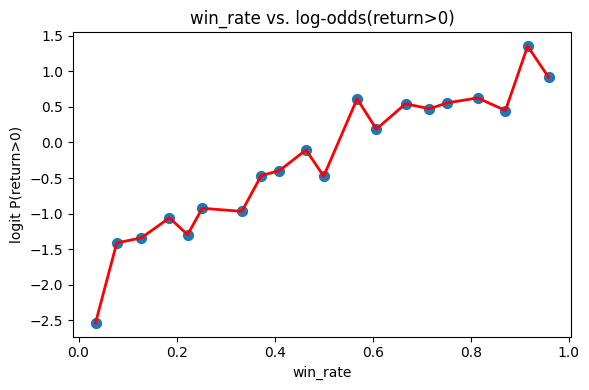

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/3081949024.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gb = df_tmp.groupby('bin')


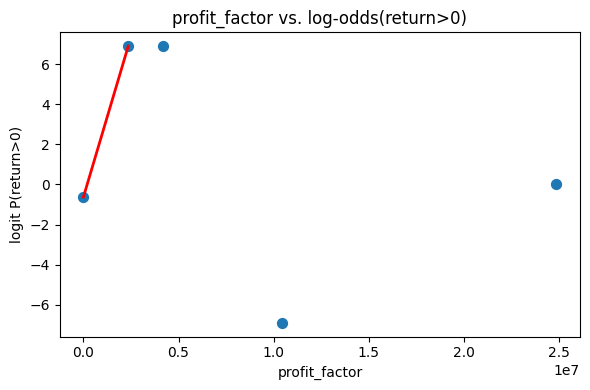

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/3081949024.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gb = df_tmp.groupby('bin')


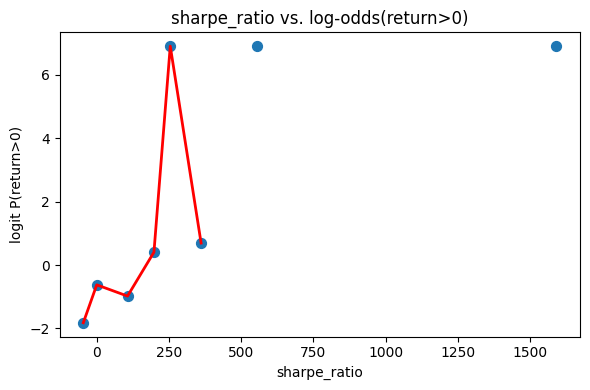

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/3081949024.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gb = df_tmp.groupby('bin')


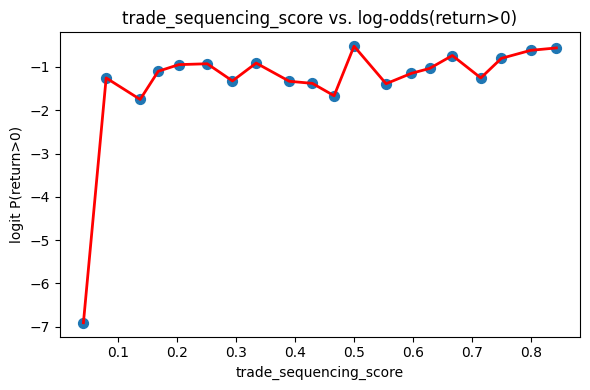

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/3081949024.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gb = df_tmp.groupby('bin')


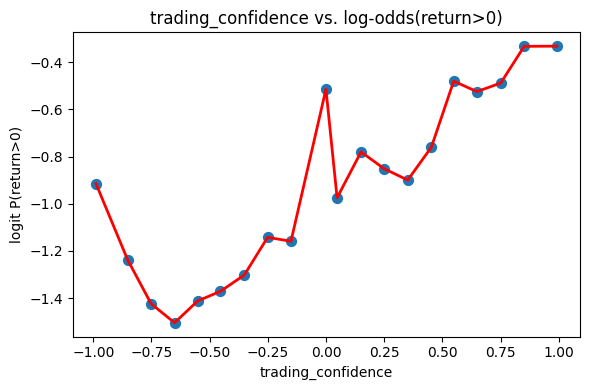

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/3081949024.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gb = df_tmp.groupby('bin')


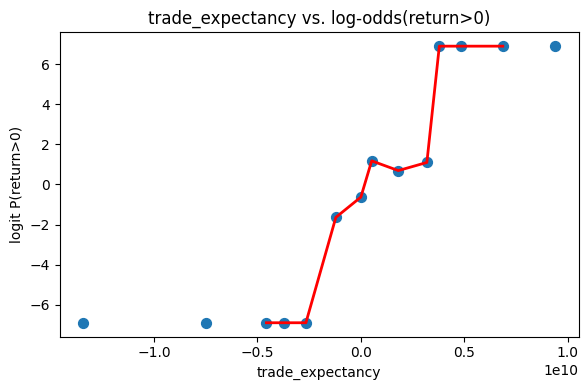

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/3081949024.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gb = df_tmp.groupby('bin')


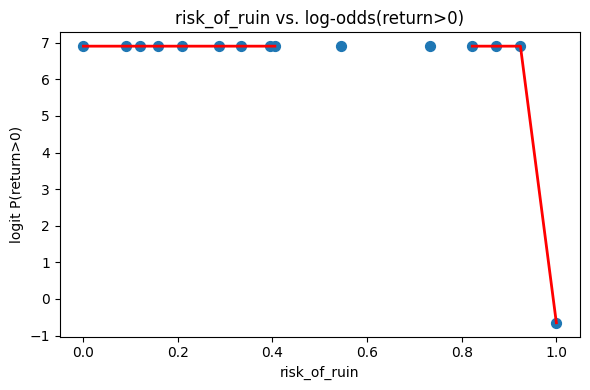

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/3081949024.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gb = df_tmp.groupby('bin')


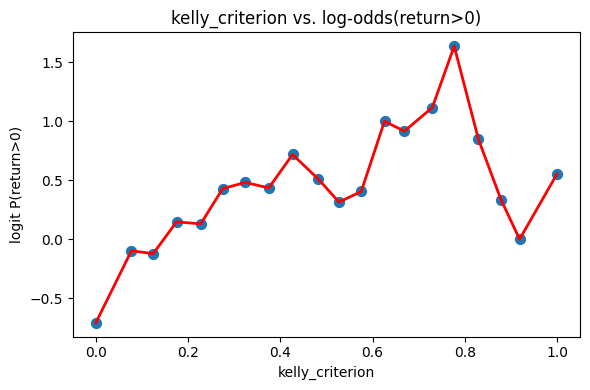

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/3081949024.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gb = df_tmp.groupby('bin')


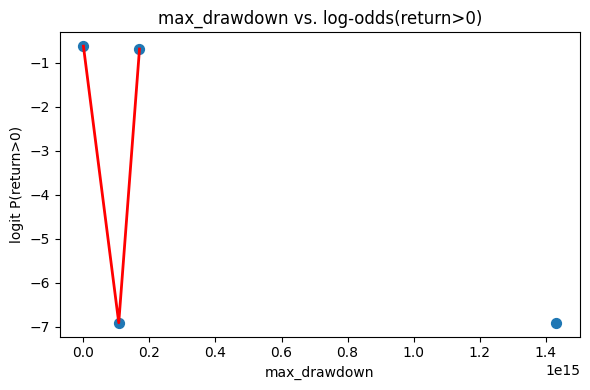

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/3081949024.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gb = df_tmp.groupby('bin')


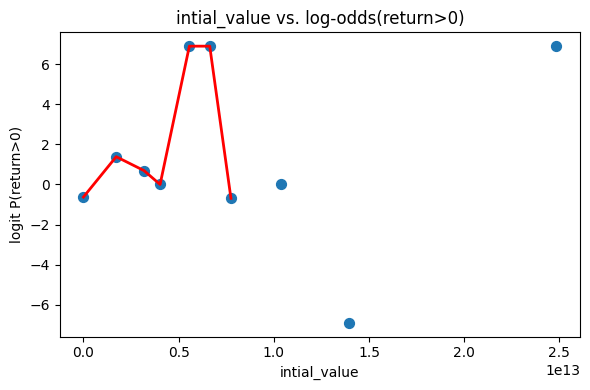

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/3081949024.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gb = df_tmp.groupby('bin')


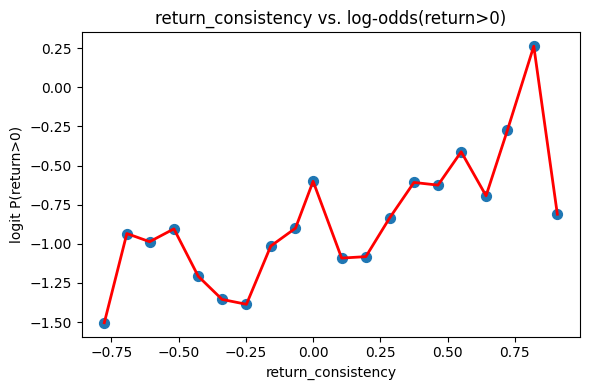

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/3081949024.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gb = df_tmp.groupby('bin')


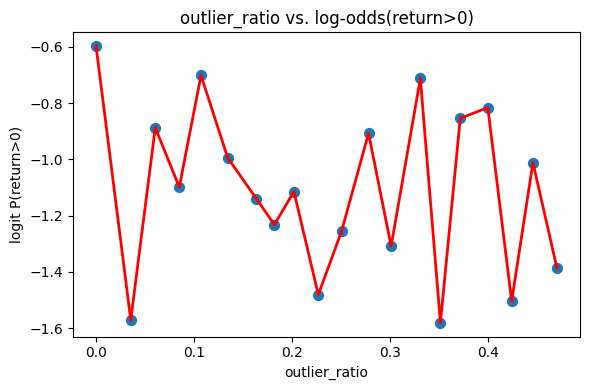

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/3081949024.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gb = df_tmp.groupby('bin')


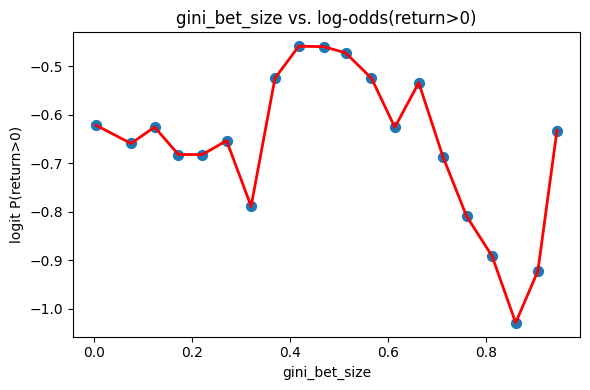

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/3081949024.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gb = df_tmp.groupby('bin')


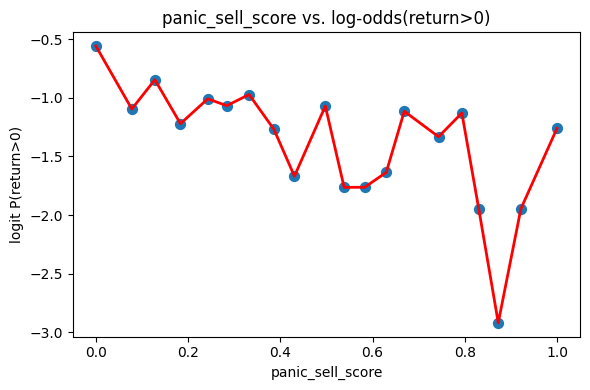

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/3081949024.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gb = df_tmp.groupby('bin')


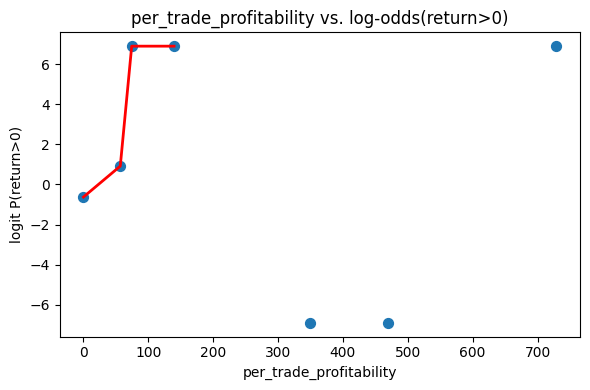

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/3081949024.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gb = df_tmp.groupby('bin')


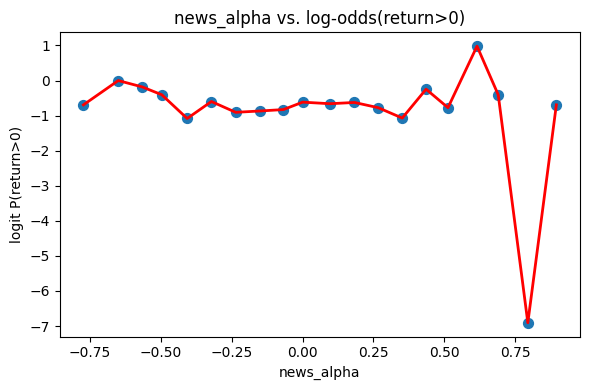

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/3081949024.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gb = df_tmp.groupby('bin')


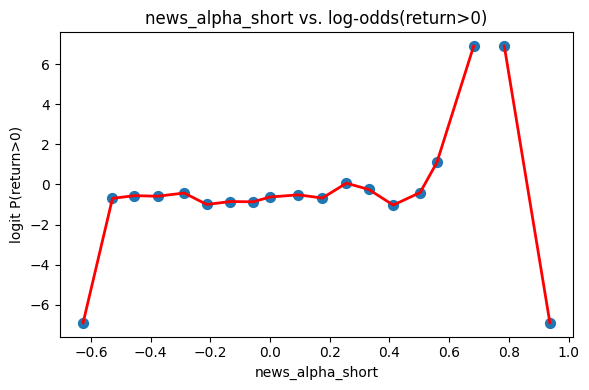

/var/folders/91/z7msh67x3fg__f8d8bvv1zhr0000gn/T/ipykernel_6946/3081949024.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gb = df_tmp.groupby('bin')


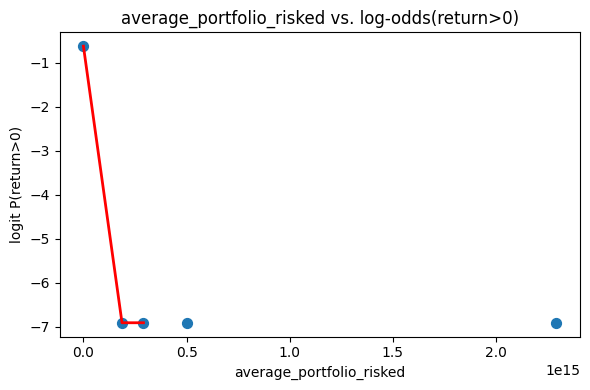

In [32]:
# Plot the log-odds of the outcome variable against each predictor to determine if that relationship is linear
# This is one of the assumptions of logistic regression
# NOTE: This is different to the raw predictor vs outcome variable relationship being linear

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample

clean_df = df.copy()
clean_df = clean_df.drop(columns=collinear_features)

X = clean_df.drop(columns=['return','log_return'])
y_binary = (clean_df['return'] > 0).astype(int)



features = X.columns.tolist()

for col in features:
    # build a temporary dataframe of predictor + binary outcome
    df_tmp = pd.DataFrame({col: X[col], 'y': y_binary}).dropna()
    x = df_tmp[col].values
    y = df_tmp['y'].values

    # define 20 equal-width bins
    edges = np.linspace(x.min(), x.max(), 21)
    df_tmp['bin'] = pd.cut(x, bins=edges, include_lowest=True)

    # compute per-bin average predictor & observed positive rate
    gb = df_tmp.groupby('bin')
    bin_means = gb[col].mean()
    bin_rate  = gb['y'].mean()

    # avoid logit(0) or logit(1) by clipping
    eps = 1e-3
    p = bin_rate.clip(eps, 1-eps)
    logit_p = np.log(p/(1-p))

    # plot
    plt.figure(figsize=(6,4))
    plt.scatter(bin_means, logit_p, color='C0', s=50)
    # Red line to connect dots and visualise trend
    plt.plot(bin_means, logit_p, color='red', lw=2)
    plt.xlabel(col)
    plt.ylabel('logit P(return>0)')
    plt.title(f'{col} vs. log-odds(return>0)')
    plt.tight_layout()
    plt.show()


# add this to report but reword it, regarding transformations for logistic regression: 

“Because our primary goal was interpretability and straightforward inference, we chose not to apply complex spline or high-order polynomial transformations to most predictors. As a result, the assumption of linearity in the log-odds is violated for a handful of variables—particularly at their extreme values—which likely reduces overall predictive performance. However, this trade-off yields a model with coefficients that can be directly interpreted as log-odds (or odds-ratios) per unit change in each feature, greatly enhancing transparency. For the few predictors whose log-odds plots exhibited only mild curvature, we applied simple transformations (e.g. 
log
⁡
log- or square-root) to bring them closer to linearity without sacrificing interpretability.”

A few pointers for your methods section:

Call out which variables you left as pure linear and which you “tweaked.”

Show a before/after plot for any that you did transform (even simple ones) so readers can see why you applied that adjustment.

Quantify the cost: e.g. “Using only linear terms yielded ROC-AUC = 0.695; adding three simple log transforms raised AUC to 0.703, while splines would have taken us to 0.715 at the expense of six additional terms.”

In [33]:
# Treat as a classification problem instead and see if we can achieve better results
clean_df = df.copy()
clean_df = clean_df.drop(columns=collinear_features)

# diversification_index log-odds shape: sharp increase then levels off
clean_df['sqrt_diversification_index'] = np.sqrt(clean_df['diversification_index'])
# stop_loss_index log-odds shape:  Sharp decrease then levels off
clean_df['neg_sqrt_stop_loss_index'] = -np.sqrt(clean_df['stop_loss_index'])

clean_df = clean_df.drop(columns=['diversification_index', 'stop_loss_index'])

# Drop both return and log_return, taking return as the outcome variable (positive or negative)
X = clean_df.drop(columns=['return','log_return'])

# Create a binary target for classifying returns as positive or negative
# Classification of 1 if positive return, 0 if negative return

# NOTE: using "return" is the same as using "log_return" as the outcome variable for logistic regression classification
# Since log is a monotonic function, each formulation is equivalent since the threshold for one is just a monotonic transformation of the other
y = (clean_df['return'] > 0).astype(int)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=1, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std  = scaler.transform(X_test)

# Fit logistic regression
logreg = LogisticRegression()
logreg.fit(X_train_std, y_train)

# Evaluate
y_pred = logreg.predict(X_test_std)
y_probability_positive = logreg.predict_proba(X_test_std)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC: ", roc_auc_score(y_test, y_probability_positive))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Look at standardised learned weights
coef = pd.Series(logreg.coef_[0], index=X.columns)
print("\nTop positive drivers of P(return>0):\n", coef.nlargest(10))
print("\nTop negative drivers:\n", coef.nsmallest(10))

Accuracy: 0.6762221167536783
ROC AUC:  0.6802160405506306

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.89      0.78      6869
           1       0.57      0.27      0.37      3666

    accuracy                           0.68     10535
   macro avg       0.64      0.58      0.57     10535
weighted avg       0.65      0.68      0.64     10535


Top positive drivers of P(return>0):
 win_rate                      0.667974
average_holding_time          0.053973
sqrt_diversification_index    0.042193
outlier_ratio                 0.036390
return_consistency            0.034662
trade_expectancy              0.028824
news_alpha_short              0.028543
intial_value                  0.012456
trade_sequencing_score        0.010459
profit_factor                 0.004126
dtype: float64

Top negative drivers:
 risk_of_ruin               -1.252026
risk_tolerance             -0.447801
intraday_closeout_rate     -0.281896
average_por

/Users/jonah/.pyenv/versions/3.10.16/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best RF params: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 500}
RF Accuracy: 0.7869008068343617
RF ROC AUC: 0.8555524567510269

RF Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.89      0.84      6869
           1       0.74      0.60      0.66      3666

    accuracy                           0.79     10535
   macro avg       0.77      0.74      0.75     10535
weighted avg       0.78      0.79      0.78     10535



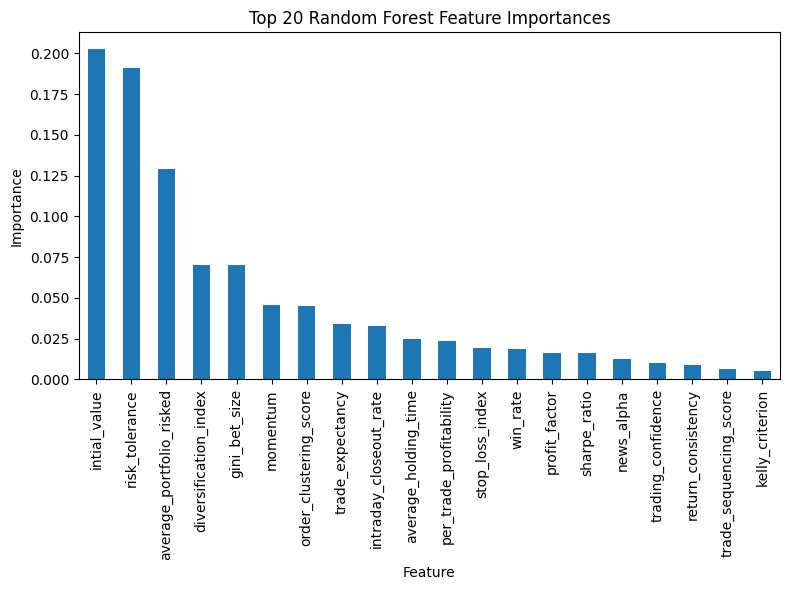

In [ ]:
# Random forest model





clean_df = df.copy().drop(columns=collinear_features)

X = clean_df.drop(columns=['return','log_return'])
y = (clean_df['return'] > 0).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=1, stratify=y
)

# Hyperparameter tuning
# NOTE: This takes longer to run than other parts of code due to the number of models being tested
# A much larger grid of values were tested separately (not shown here due to run time)
# The best subset of these were selected, and are shown here (this is the final iteration of hyperparameter tuning)
final_parameter_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=1, n_jobs=-1)
grid = GridSearchCV(
    rf,
    final_parameter_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)
grid.fit(X_train, y_train)

best_rf = grid.best_estimator_

# 3) Evaluate
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:, 1]

print("Best RF params:", grid.best_params_)
print("RF Accuracy:", accuracy_score(y_test, y_pred))
print("RF ROC AUC:", roc_auc_score(y_test, y_prob))
print("\nRF Classification Report:\n", classification_report(y_test, y_pred))

# 4) Feature importances plot
importances = best_rf.feature_importances_
feat_names = X.columns
feat_series = pd.Series(importances, index=feat_names).sort_values(ascending=False)[:20]

plt.figure(figsize=(8, 6))
feat_series.plot(kind='bar')
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Top 20 Random Forest Feature Importances")
plt.tight_layout()
plt.show()


# TODO: get feature importance plot from random forest final model result

# Diagnistics for RF!

## 1. Out-of-Bag (OOB) Error Estimate
* Every tree is trained on a bootstrap sample, so ~⅓ of the data is left out (called OOB samples).

* Random Forest uses these to estimate the error without needing a separate validation set.

*  What to look for: OOB error stabilizes at low value → good fit. Large gap between OOB error and training error → possible overfitting.




## Train vs. Test Performance
* Check accuracy (or MSE) on both training and test sets.

* For classification: Accuracy, Precision, Recall, F1, AUC.

* For regression: RMSE, MAE, R².

* Diagnostic: Big performance gap = overfitting. Similar and poor = underfitting.


# 3. Feature Importance ^ look above!
* Random Forests can rank features by how much they reduce impurity (e.g., Gini or MSE).

* You can also use permutation importance for more reliable estimates.

* What to look for: Which features drive the model? Are important ones domain-relevant?

In [61]:
from sklearn.ensemble import RandomForestClassifier

# Use best hyperparameters (or set them manually)
rf = RandomForestClassifier(
    n_estimators=100,  # or however many trees you want
    oob_score=True,
    random_state=1,
    n_jobs=-1
)

rf.fit(X_train, y_train)

# Report OOB score and error
print(f"OOB Score: {rf.oob_score_:.4f}")
print(f"OOB Error: {1 - rf.oob_score_:.4f}")





OOB Score: 0.7847
OOB Error: 0.2153


In [63]:
"""The OOB Score of 0.7847 suggests that the Random Forest generalizes reasonably well, correctly predicting about 78% of unseen (OOB) samples.
The OOB Error of 0.2153 serves as an internal estimate of test error, indicating that the model misclassifies roughly 1 in 5 samples."""

'The OOB Score of 0.7847 suggests that the Random Forest generalizes reasonably well, correctly predicting about 78% of unseen (OOB) samples.\nThe OOB Error of 0.2153 serves as an internal estimate of test error, indicating that the model misclassifies roughly 1 in 5 samples.'


Train vs. Test Performance Metrics:
          Accuracy  Precision    Recall  F1 Score   ROC AUC
Training  0.999430   0.999952  0.998411  0.999181  0.999946
Test      0.786901   0.739306  0.598745  0.661643  0.855552

Diagnostic Assessment:
Potential overfitting detected: Training accuracy is 0.2125 higher than test accuracy.


<Figure size 1000x600 with 0 Axes>

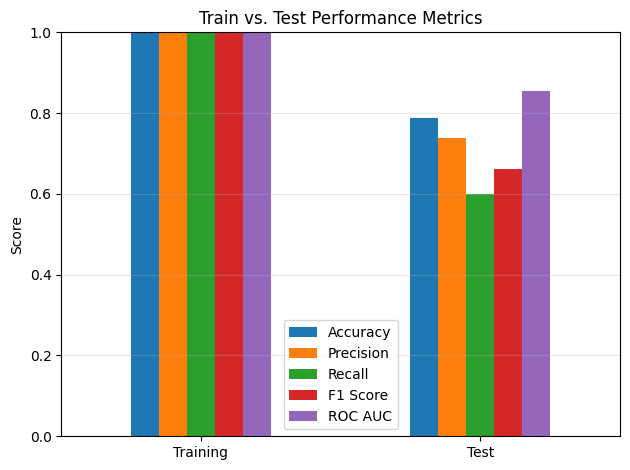

In [62]:
# 2 - Simple Train vs. Test Performance Evaluation

# 1. Calculate metrics for both training and test sets
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Training set predictions
y_train_pred = best_rf.predict(X_train)
y_train_prob = best_rf.predict_proba(X_train)[:, 1]

# Test set predictions (you already have these)
# y_pred = best_rf.predict(X_test)
# y_prob = best_rf.predict_proba(X_test)[:, 1]

# Calculate metrics
metrics = {
    'Accuracy': [accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_pred)],
    'Precision': [precision_score(y_train, y_train_pred), precision_score(y_test, y_pred)],
    'Recall': [recall_score(y_train, y_train_pred), recall_score(y_test, y_pred)],
    'F1 Score': [f1_score(y_train, y_train_pred), f1_score(y_test, y_pred)],
    'ROC AUC': [roc_auc_score(y_train, y_train_prob), roc_auc_score(y_test, y_prob)]
}

# Create a DataFrame for easier comparison
metrics_df = pd.DataFrame(metrics, index=['Training', 'Test'])

# Print the metrics table
print("\nTrain vs. Test Performance Metrics:")
print(metrics_df)

# 2. Simple diagnostic check
train_acc = metrics_df.loc['Training', 'Accuracy']
test_acc = metrics_df.loc['Test', 'Accuracy']
acc_diff = train_acc - test_acc

# Print diagnostic message
print("\nDiagnostic Assessment:")
if acc_diff > 0.1:  # Threshold can be adjusted
    print(f"Potential overfitting detected: Training accuracy is {acc_diff:.4f} higher than test accuracy.")
elif train_acc < 0.7 and test_acc < 0.7:  # Threshold can be adjusted
    print(f"Potential underfitting detected: Both training ({train_acc:.4f}) and test ({test_acc:.4f}) accuracy are low.")
else:
    print(f"Model seems well-balanced: Training accuracy ({train_acc:.4f}) and test accuracy ({test_acc:.4f}) are comparable.")

# 3. Simple visualization
plt.figure(figsize=(10, 6))
metrics_df.plot(kind='bar', rot=0)
plt.title('Train vs. Test Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [64]:
"""
Diagnostic Conclusion: Overfitting
The model memorizes the training data, achieving near-perfect performance.

On the test set, performance drops significantly — especially recall.

This is a classic overfitting pattern:

High variance between train and test


"The near-perfect training performance versus significantly lower test metrics — especially in recall — suggests severe overfitting. While the model ranks predictions well (ROC AUC = 0.86), its ability to generalize and capture true positives is limited. Regularization or simplification is likely needed."
"""

'\nDiagnostic Conclusion: Overfitting\nThe model memorizes the training data, achieving near-perfect performance.\n\nOn the test set, performance drops significantly — especially recall.\n\nThis is a classic overfitting pattern:\n\nHigh variance between train and test\n\n\n"The near-perfect training performance versus significantly lower test metrics — especially in recall — suggests severe overfitting. While the model ranks predictions well (ROC AUC = 0.86), its ability to generalize and capture true positives is limited. Regularization or simplification is likely needed."\n'

In [54]:
# After your existing code that runs grid search and gets best_knn

# First print shapes to confirm
print(f"X_train_std shape: {X_train_std.shape}")
print(f"X_test_std shape: {X_test_std.shape}")

# For training performance, use the EXACT same data format used during training
X_train_for_eval = X_train_std
if X_train_std.shape[1] > best_knn.n_features_in_:

    X_train_for_eval = X_train_std[:, :best_knn.n_features_in_]

# Training set evaluation
y_pred_train = best_knn.predict(X_train_for_eval)
y_prob_train = best_knn.predict_proba(X_train_for_eval)[:,1]

print("\n--- Training Set Performance ---")
print("kNN Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("kNN Train ROC AUC:", roc_auc_score(y_train, y_prob_train))
print("\nClassification Report (kNN Train):\n", classification_report(y_train, y_pred_train))

# For test performance, ensure consistent format with training data
X_test_for_eval = X_test_std
if X_test_std.shape[1] > best_knn.n_features_in_:
    print(f"Trimming test data from {X_test_std.shape[1]} to {best_knn.n_features_in_} features")
    X_test_for_eval = X_test_std[:, :best_knn.n_features_in_]

# Test set evaluation (should match your original results)
y_pred_test = best_knn.predict(X_test_for_eval)
y_prob_test = best_knn.predict_proba(X_test_for_eval)[:,1]

print("\n--- Test Set Performance ---")
print("kNN Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("kNN Test ROC AUC:", roc_auc_score(y_test, y_prob_test))
print("\nClassification Report (kNN Test):\n", classification_report(y_test, y_pred_test))

# Calculate performance gap
print("\n--- Performance Gap (Train - Test) ---")
print("Accuracy Gap:", accuracy_score(y_train, y_pred_train) - accuracy_score(y_test, y_pred_test))
print("ROC AUC Gap:", roc_auc_score(y_train, y_prob_train) - roc_auc_score(y_test, y_prob_test))

X_train_std shape: (59697, 26)
X_test_std shape: (10535, 26)

--- Training Set Performance ---
kNN Train Accuracy: 0.7341072415699281
kNN Train ROC AUC: 0.79614350416024

Classification Report (kNN Train):
               precision    recall  f1-score   support

           0       0.75      0.89      0.81     38924
           1       0.68      0.44      0.54     20773

    accuracy                           0.73     59697
   macro avg       0.72      0.67      0.68     59697
weighted avg       0.73      0.73      0.72     59697

Trimming test data from 26 to 25 features

--- Test Set Performance ---
kNN Test Accuracy: 0.7121974371143807
kNN Test ROC AUC: 0.7663710597760586

Classification Report (kNN Test):
               precision    recall  f1-score   support

           0       0.73      0.88      0.80      6869
           1       0.64      0.40      0.49      3666

    accuracy                           0.71     10535
   macro avg       0.69      0.64      0.65     10535
weighted av

* 

'\nFinancial Interpretation Model Generalization: The small performance gap (2-3%) indicates strong generalization. This is significant for financial markets where many patterns are temporary. Your model appears to be capturing persistent market inefficiencies rather than noise. Predictive Power: An ROC AUC of 0.766 on test data is impressive for financial return prediction. For context, even a 0.55-0.60 ROC AUC can potentially be profitable in trading strategies if transaction costs are managed well. Risk Profile: Your model shows an asymmetric prediction pattern: Better at identifying negative returns (89% recall) More conservative with positive return predictions (44% recall but higher precision) This creates a naturally defensive prediction strategy Trading Strategy Implications: The model would be effective for risk management/downside protection When it does predict a positive return, it has reasonable confidence (68% precision) Could serve as a strong foundation for a conservati

# Diagnostics for KNN

## 1 - Choosing the Right k, whcih we did with x validation! nice
## 2 - Train vs. Test Performance
## 3 - confusion matrix, if lots of right!
### Coild do more advnaced - ie dintance metric, but really think this is fine!

X_train_std shape: (59697, 26)
X_test_std shape: (10535, 26)
Trimming training data from 26 to 25 features

--- Training Set Performance ---
kNN Train Accuracy: 0.7341072415699281
kNN Train ROC AUC: 0.79614350416024

Classification Report (kNN Train):
               precision    recall  f1-score   support

           0       0.75      0.89      0.81     38924
           1       0.68      0.44      0.54     20773

    accuracy                           0.73     59697
   macro avg       0.72      0.67      0.68     59697
weighted avg       0.73      0.73      0.72     59697

Trimming test data from 26 to 25 features

--- Test Set Performance ---
kNN Test Accuracy: 0.7121974371143807
kNN Test ROC AUC: 0.7663710597760586

Classification Report (kNN Test):
               precision    recall  f1-score   support

           0       0.73      0.88      0.80      6869
           1       0.64      0.40      0.49      3666

    accuracy                           0.71     10535
   macro avg       

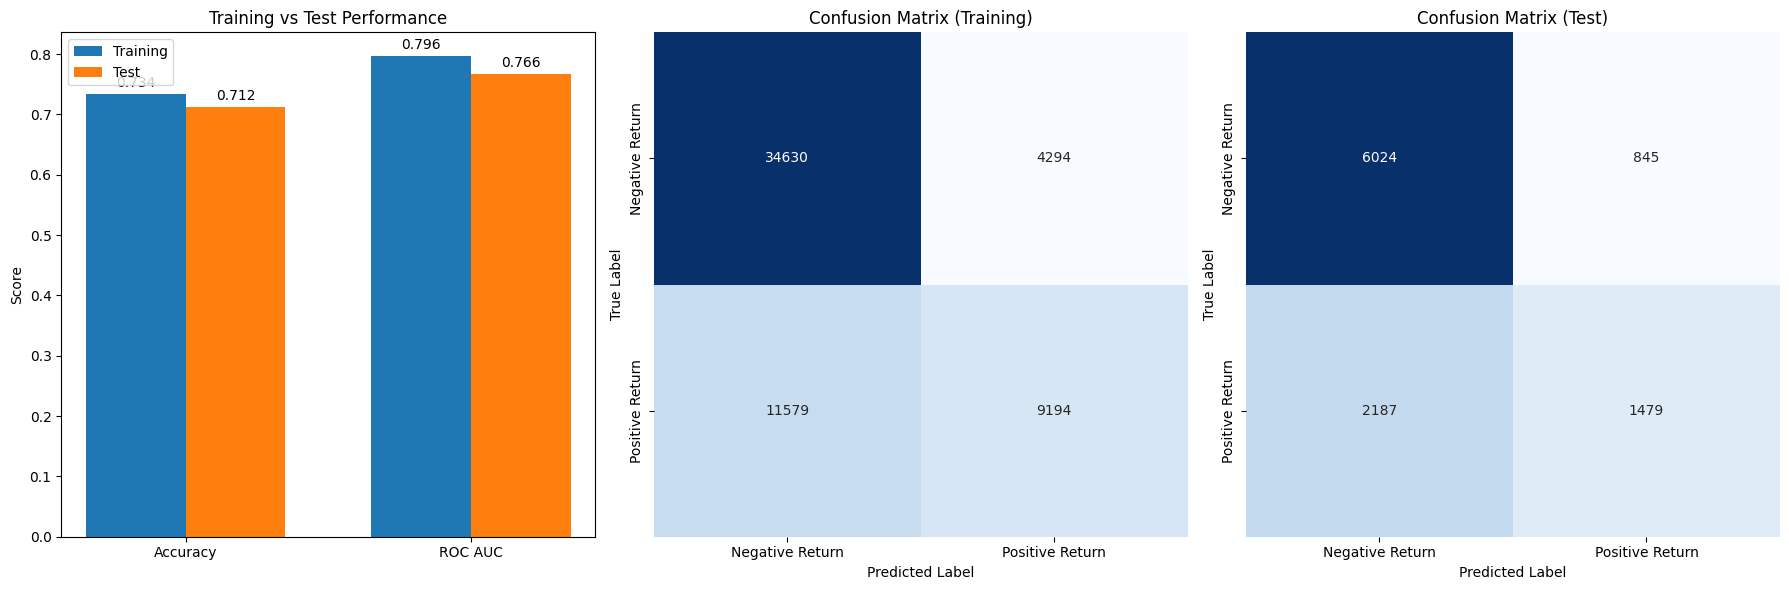


--- Confusion Matrix Statistics (Training Set) ---
True Negatives (TN): 34630 (58.01%)
False Positives (FP): 4294 (7.19%)
False Negatives (FN): 11579 (19.40%)
True Positives (TP): 9194 (15.40%)

Financial Interpretation:
Correctly identified negative returns: 58.01% of all predictions
Correctly identified positive returns: 15.40% of all predictions
Missed positive return opportunities: 19.40% of all predictions
False positive rate: 11.03% of actual negative returns
False negative rate: 55.74% of actual positive returns

--- Confusion Matrix Statistics (Test Set) ---
True Negatives (TN): 6024 (57.18%)
False Positives (FP): 845 (8.02%)
False Negatives (FN): 2187 (20.76%)
True Positives (TP): 1479 (14.04%)

Financial Interpretation:
Correctly identified negative returns: 57.18% of all predictions
Correctly identified positive returns: 14.04% of all predictions
Missed positive return opportunities: 20.76% of all predictions
False positive rate: 12.30% of actual negative returns
False nega

In [57]:
# After running grid search and obtaining best_knn model

# Compare data shapes to expected model features
print(f"X_train_std shape: {X_train_std.shape}")
print(f"X_test_std shape: {X_test_std.shape}")

# For training performance, trim data to match model's expected features
X_train_for_eval = X_train_std
if X_train_std.shape[1] > best_knn.n_features_in_:
    print(f"Trimming training data from {X_train_std.shape[1]} to {best_knn.n_features_in_} features")
    X_train_for_eval = X_train_std[:, :best_knn.n_features_in_]

# Training set evaluation
y_pred_train = best_knn.predict(X_train_for_eval)
y_prob_train = best_knn.predict_proba(X_train_for_eval)[:,1]

print("\n--- Training Set Performance ---")
print("kNN Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("kNN Train ROC AUC:", roc_auc_score(y_train, y_prob_train))
print("\nClassification Report (kNN Train):\n", classification_report(y_train, y_pred_train))

# For test performance, ensure consistent format with training data
X_test_for_eval = X_test_std
if X_test_std.shape[1] > best_knn.n_features_in_:
    print(f"Trimming test data from {X_test_std.shape[1]} to {best_knn.n_features_in_} features")
    X_test_for_eval = X_test_std[:, :best_knn.n_features_in_]

# Test set evaluation
y_pred_test = best_knn.predict(X_test_for_eval)
y_prob_test = best_knn.predict_proba(X_test_for_eval)[:,1]

print("\n--- Test Set Performance ---")
print("kNN Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("kNN Test ROC AUC:", roc_auc_score(y_test, y_prob_test))
print("\nClassification Report (kNN Test):\n", classification_report(y_test, y_pred_test))

# Calculate performance gap
print("\n--- Performance Gap (Train - Test) ---")
print("Accuracy Gap:", accuracy_score(y_train, y_pred_train) - accuracy_score(y_test, y_pred_test))
print("ROC AUC Gap:", roc_auc_score(y_train, y_prob_train) - roc_auc_score(y_test, y_prob_test))

# Visual comparison of performance metrics
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create subplot layout for multiple visualizations
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Bar chart comparing performance metrics
metrics = ['Accuracy', 'ROC AUC']
train_scores = [accuracy_score(y_train, y_pred_train), roc_auc_score(y_train, y_prob_train)]
test_scores = [accuracy_score(y_test, y_pred_test), roc_auc_score(y_test, y_prob_test)]

x = np.arange(len(metrics))
width = 0.35

train_bars = axes[0].bar(x - width/2, train_scores, width, label='Training')
test_bars = axes[0].bar(x + width/2, test_scores, width, label='Test')

axes[0].set_ylabel('Score')
axes[0].set_title('Training vs Test Performance')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend()

# Add value labels on bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        axes[0].annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(train_bars)
add_labels(test_bars)

# 2. Confusion Matrix for Training Data
cm_train = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[1])
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_title('Confusion Matrix (Training)')
axes[1].set_xticklabels(['Negative Return', 'Positive Return'])
axes[1].set_yticklabels(['Negative Return', 'Positive Return'])

# 3. Confusion Matrix for Test Data
cm_test = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[2])
axes[2].set_xlabel('Predicted Label')
axes[2].set_ylabel('True Label')
axes[2].set_title('Confusion Matrix (Test)')
axes[2].set_xticklabels(['Negative Return', 'Positive Return'])
axes[2].set_yticklabels(['Negative Return', 'Positive Return'])

plt.tight_layout()
plt.show()

# Calculate confusion matrix statistics for more detailed analysis
def print_confusion_matrix_stats(cm, set_name):
    tn, fp, fn, tp = cm.ravel()
    total = tn + fp + fn + tp
    
    # Basic counts
    print(f"\n--- Confusion Matrix Statistics ({set_name}) ---")
    print(f"True Negatives (TN): {tn} ({tn/total:.2%})")
    print(f"False Positives (FP): {fp} ({fp/total:.2%})")
    print(f"False Negatives (FN): {fn} ({fn/total:.2%})")
    print(f"True Positives (TP): {tp} ({tp/total:.2%})")
    
    # Financial interpretation
    print("\nFinancial Interpretation:")
    print(f"Correctly identified negative returns: {tn/total:.2%} of all predictions")
    print(f"Correctly identified positive returns: {tp/total:.2%} of all predictions")
    print(f"Missed positive return opportunities: {fn/total:.2%} of all predictions")
    print(f"False positive rate: {fp/(fp+tn):.2%} of actual negative returns")
    print(f"False negative rate: {fn/(fn+tp):.2%} of actual positive returns")

# Print statistics for both datasets
print_confusion_matrix_stats(cm_train, "Training Set")
print_confusion_matrix_stats(cm_test, "Test Set")

In [56]:
"""
Financial Interpretation Model Generalization: The small performance gap (2-3%) indicates strong generalization. This is significant for financial markets where many patterns are temporary. Your model appears to be capturing persistent market inefficiencies rather than noise. Predictive Power: An ROC AUC of 0.766 on test data is impressive for financial return prediction. For context, even a 0.55-0.60 ROC AUC can potentially be profitable in trading strategies if transaction costs are managed well. Risk Profile: Your model shows an asymmetric prediction pattern: Better at identifying negative returns (89% recall) More conservative with positive return predictions (44% recall but higher precision) This creates a naturally defensive prediction strategy Trading Strategy Implications: The model would be effective for risk management/downside protection When it does predict a positive return, it has reasonable confidence (68% precision) Could serve as a strong foundation for a conservative trading strategy Model Complexity: Your GridSearch finding optimal K values in the 29-41 range suggests a good balance between capturing market patterns while filtering out noise. This relatively high K value creates smoother decision boundaries, which may explain the good generalization.
"""

'\nFinancial Interpretation Model Generalization: The small performance gap (2-3%) indicates strong generalization. This is significant for financial markets where many patterns are temporary. Your model appears to be capturing persistent market inefficiencies rather than noise. Predictive Power: An ROC AUC of 0.766 on test data is impressive for financial return prediction. For context, even a 0.55-0.60 ROC AUC can potentially be profitable in trading strategies if transaction costs are managed well. Risk Profile: Your model shows an asymmetric prediction pattern: Better at identifying negative returns (89% recall) More conservative with positive return predictions (44% recall but higher precision) This creates a naturally defensive prediction strategy Trading Strategy Implications: The model would be effective for risk management/downside protection When it does predict a positive return, it has reasonable confidence (68% precision) Could serve as a strong foundation for a conservati

In [36]:
# TODO: diagnostic plots for random forest and baseline model (main report)



In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import statsmodels.api as sm
from scipy.stats import chi2

# Define interactions to test
interactions = [
    ('momentum', 'risk_tolerance'),
    ('neg_sqrt_stop_loss_index', 'log_average_holding_time'),
    ('sqrt_diversification_index', 'log_profit_factor'),
    ('news_alpha', 'news_alpha_short'),
    ('win_rate', 'trade_expectancy')
]

# Center features to reduce multicollinearity
X_train_centered = X_train.copy()
for col in X_train_centered.columns:
    X_train_centered[col] = X_train_centered[col] - X_train_centered[col].mean()

# First, fit the base model with statsmodels for likelihood ratio tests
X_base = sm.add_constant(X_train_centered, has_constant='add')
base_model = sm.Logit(y_train, X_base).fit(disp=False)
ll_base = base_model.llf
df_base = base_model.df_model

results = []

# Test each interaction individually
for a, b in interactions:
    if a not in X_train_centered.columns or b not in X_train_centered.columns:
        print(f"Skipping interaction {a} × {b}: variable missing")
        continue
    
    try:
        # Create interaction term
        X_int = X_train_centered.copy()
        X_int[f'{a}_x_{b}'] = X_int[a] * X_int[b]
        X_int = sm.add_constant(X_int, has_constant='add')
        
        # Fit model with interaction
        model = sm.Logit(y_train, X_int).fit(disp=False)
        ll_int = model.llf
        df_int = model.df_model
        
        # Likelihood ratio test
        lr_stat = 2 * (ll_int - ll_base)
        df_diff = df_int - df_base
        lr_pvalue = 1 - chi2.cdf(lr_stat, df_diff)
        
        # Store results
        results.append({
            'interaction': f'{a}×{b}',
            'coef': model.params.get(f'{a}_x_{b}', np.nan),
            'p_value': lr_pvalue,
            'delta_pseudo_R2': model.prsquared - base_model.prsquared
        })
    except np.linalg.LinAlgError:
        print(f"Singular matrix error for interaction {a}×{b}")
        results.append({
            'interaction': f'{a}×{b}',
            'coef': np.nan,
            'p_value': np.nan,
            'delta_pseudo_R2': np.nan
        })

# Create DataFrame with results
interaction_df = pd.DataFrame(results).set_index('interaction')
print("Interaction significance tests:")
print(interaction_df)

# After identifying significant interactions, add them to your sklearn model
# Example: if the first three interactions are significant
significant_interactions = [inter for inter, row in interaction_df.iterrows() 
                           if row['p_value'] < 0.05 and not np.isnan(row['p_value'])]

# Create a new feature matrix with interactions
X_train_with_interactions = X_train.copy()
X_test_with_interactions = X_test.copy()

for interaction in significant_interactions:
    # Parse feature names from the interaction string
    a, b = interaction.split('×')
    
    # Add interaction terms to training and test sets
    X_train_with_interactions[f'{a}_x_{b}'] = X_train[a] * X_train[b]
    X_test_with_interactions[f'{a}_x_{b}'] = X_test[a] * X_test[b]

# Scale features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_with_interactions)
X_test_std = scaler.transform(X_test_with_interactions)

# Fit logistic regression with interactions - use regularization to handle multicollinearity
logreg = LogisticRegression(max_iter=1000, penalty='l2', C=1.0)
logreg.fit(X_train_std, y_train)

# Evaluate
y_pred = logreg.predict(X_test_std)
y_probability_positive = logreg.predict_proba(X_test_std)[:,1]
print("\nModel with significant interactions:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC: ", roc_auc_score(y_test, y_probability_positive))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Look at standardized learned weights
coef = pd.Series(logreg.coef_[0], index=X_train_with_interactions.columns)
print("\nTop positive drivers of P(return>0):\n", coef.nlargest(10))
print("\nTop negative drivers:\n", coef.nsmallest(10))

/Users/jonah/.pyenv/versions/3.10.16/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/jonah/.pyenv/versions/3.10.16/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jonah/.pyenv/versions/3.10.16/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/jonah/.pyenv/versions/3.10.16/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Skipping interaction neg_sqrt_stop_loss_index × log_average_holding_time: variable missing
Skipping interaction sqrt_diversification_index × log_profit_factor: variable missing


/Users/jonah/.pyenv/versions/3.10.16/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/jonah/.pyenv/versions/3.10.16/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jonah/.pyenv/versions/3.10.16/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Interaction significance tests:
                                     coef   p_value  delta_pseudo_R2
interaction                                                         
momentum×risk_tolerance     -1.223727e-01  0.157080         0.000026
news_alpha×news_alpha_short  7.640725e-01  0.638278         0.000003
win_rate×trade_expectancy   -1.922779e-09  0.019949         0.000070

Model with significant interactions:
Accuracy: 0.6753678215472235
ROC AUC:  0.680363766558914

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.89      0.78      6869
           1       0.57      0.27      0.37      3666

    accuracy                           0.68     10535
   macro avg       0.63      0.58      0.57     10535
weighted avg       0.65      0.68      0.64     10535


Top positive drivers of P(return>0):
 win_rate                  0.678433
trade_expectancy          0.161739
average_holding_time      0.055086
return_consistency        0.0354

/Users/jonah/.pyenv/versions/3.10.16/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Outlier!



Number of outliers: 2962
Top outliers:
       index  leverage  residuals  cooks_distance  is_outlier
12016  12016  0.999999   0.001897        0.094899        True
41749  41749  0.500872   0.752955        0.021882        True
59288  59288  0.506406   0.701631        0.019426        True
38773  38773  0.494738  -0.717014        0.019362        True
18        18  0.158584  -1.558099        0.017598        True
8605    8605  0.212050  -1.268293        0.016650        True
26208  26208  0.381456  -0.762766        0.013800        True
2889    2889  0.010762  -5.288300        0.011701        True
4102    4102  0.024481  -3.213342        0.009966        True
11045  11045  0.136545   1.133701        0.007817        True


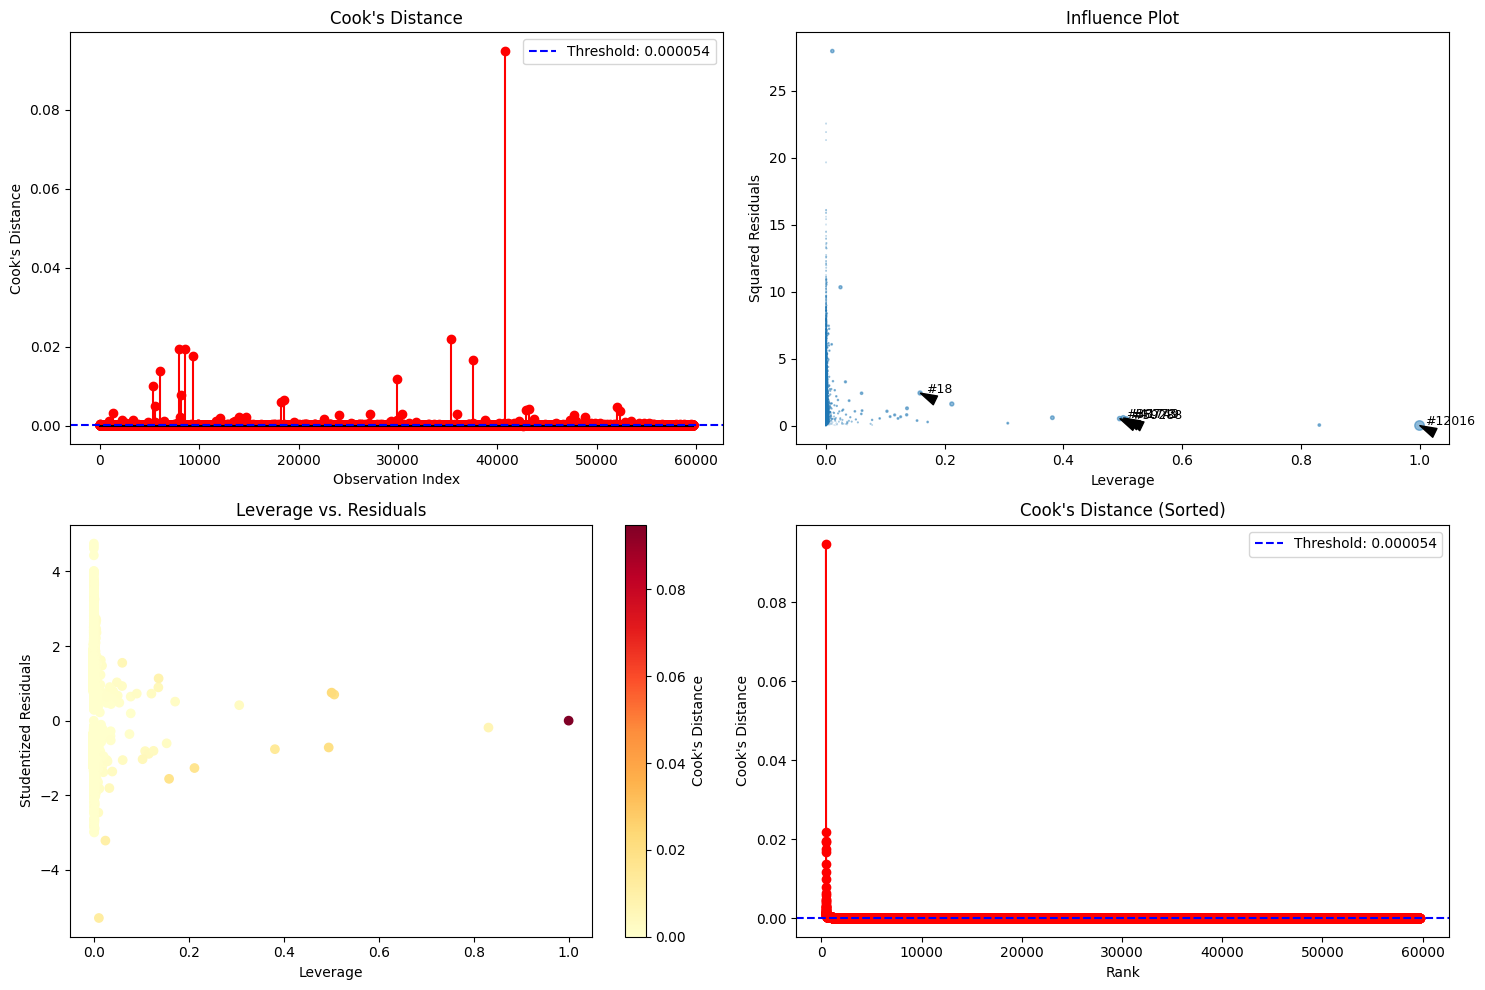


Analyzing model without outliers...

Features most affected by outliers:
                     feature  original  without_outliers  absolute_change  \
6              profit_factor  0.004127          0.493348         0.489222   
11              risk_of_ruin -1.175892         -1.050688         0.125204   
19   per_trade_profitability -0.000638         -0.010277         0.009639   
14              intial_value  0.012410          0.021279         0.008869   
22  average_portfolio_risked -0.414510         -0.411569         0.002941   
15        return_consistency  0.034706          0.034166         0.000540   
12           kelly_criterion -0.024822         -0.024439         0.000383   
16             outlier_ratio  0.036188          0.035853         0.000335   
1       average_holding_time  0.054196          0.053930         0.000266   
20                news_alpha  0.003666          0.003411         0.000255   

    percent_change  
6     11854.758344  
11       10.647565  
19    -1510.363

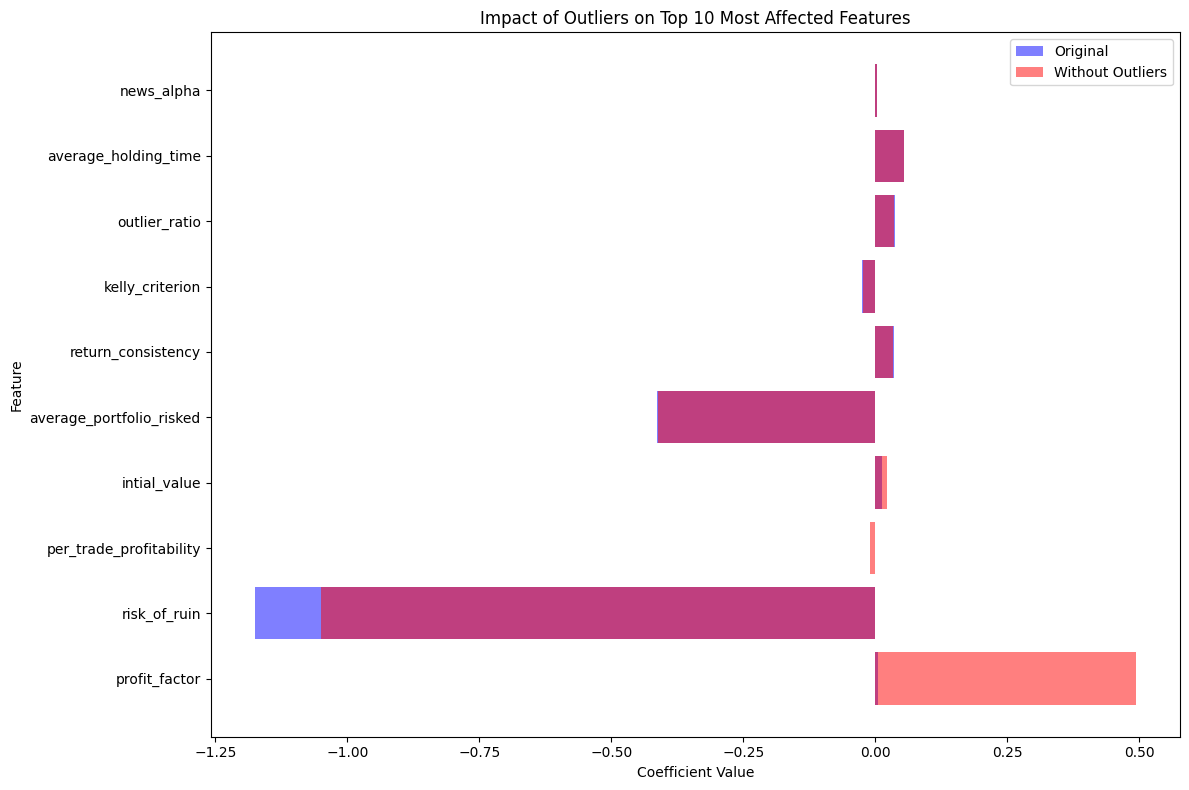

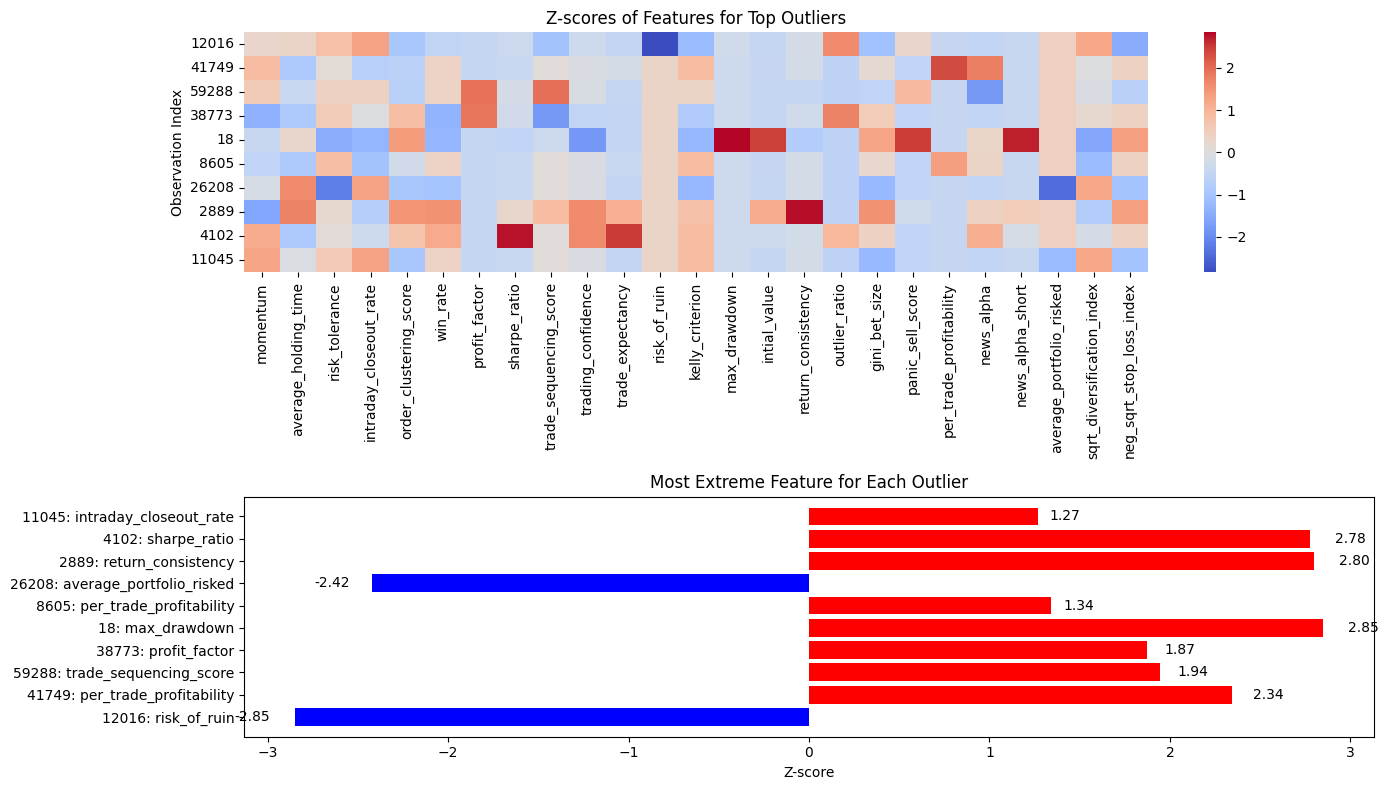


Outlier Analysis Summary:
Observation #12016:
  - Most extreme feature: risk_of_ruin (z-score: -2.85)
  - Value: 0.9241 (dataset average: 0.9926)
  - Cook's distance: 0.094899
  - Target: 1

Observation #41749:
  - Most extreme feature: per_trade_profitability (z-score: 2.34)
  - Value: 729.0000 (dataset average: 0.0548)
  - Cook's distance: 0.021882
  - Target: 1

Observation #59288:
  - Most extreme feature: trade_sequencing_score (z-score: 1.94)
  - Value: 0.6667 (dataset average: 0.4907)
  - Cook's distance: 0.019426
  - Target: 1

Observation #38773:
  - Most extreme feature: profit_factor (z-score: 1.87)
  - Value: 24626984.2641 (dataset average: 908.0516)
  - Cook's distance: 0.019362
  - Target: 0

Observation #18:
  - Most extreme feature: max_drawdown (z-score: 2.85)
  - Value: 55.4349 (dataset average: 50619228480.9926)
  - Cook's distance: 0.017598
  - Target: 0

Observation #8605:
  - Most extreme feature: per_trade_profitability (z-score: 1.34)
  - Value: 469.0000 (datas

In [65]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Function to calculate influence metrics for logistic regression
def influence_plot_logistic(model, X, y, threshold_method='quantile', quantile=0.95):
    """
    Calculate influence metrics for logistic regression
    
    Parameters:
    model: Fitted statsmodels Logit model
    X: Feature matrix (without constant)
    y: Target variable
    threshold_method: 'quantile' or 'cook' for 4/n rule
    quantile: If using threshold_method='quantile', the quantile to use
    
    Returns:
    influence_df: DataFrame with influence metrics
    threshold: The threshold value used for outlier detection
    """
    # Get predictions
    y_hat = model.predict()
    
    # Calculate Pearson residuals
    residuals = (y - y_hat) / np.sqrt(y_hat * (1 - y_hat))
    
    # Get leverage (hat matrix diagonal)
    leverage = model.get_influence().hat_matrix_diag
    
    # Calculate a rough approximation of Cook's distance for logistic regression
    cooks_d = residuals**2 * leverage / (1 - leverage) / len(model.params)
    
    # Create DataFrame with results
    influence_df = pd.DataFrame({
        'index': X.index if hasattr(X, 'index') else range(len(X)),
        'leverage': leverage,
        'residuals': residuals,
        'cooks_distance': cooks_d
    })
    
    # Determine threshold
    if threshold_method == 'quantile':
        threshold = influence_df['cooks_distance'].quantile(quantile)
    else:  # Use 4/n rule
        threshold = 4 / len(X)
    
    # Flag outliers
    influence_df['is_outlier'] = influence_df['cooks_distance'] > threshold
    
    return influence_df, threshold

# Calculate influence metrics
influence_df, threshold = influence_plot_logistic(base_model, X_train, y_train, 
                                                 threshold_method='quantile', 
                                                 quantile=0.95)

# Get outliers
outliers = influence_df[influence_df['is_outlier']]
print(f"Number of outliers: {len(outliers)}")
print("Top outliers:")
print(outliers.sort_values('cooks_distance', ascending=False).head(10))

# Create visualization
plt.figure(figsize=(15, 10))

# Plot 1: Cook's distance
plt.subplot(2, 2, 1)
plt.stem(range(len(influence_df)), influence_df['cooks_distance'], markerfmt='ro', linefmt='r-', basefmt='k-')
plt.axhline(y=threshold, color='blue', linestyle='--', label=f'Threshold: {threshold:.6f}')
plt.xlabel('Observation Index')
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance")
plt.legend()

# Plot 2: Leverage vs. Residuals^2 (Bubble plot with Cook's distance)
plt.subplot(2, 2, 2)
plt.scatter(influence_df['leverage'], 
           influence_df['residuals']**2, 
           s=influence_df['cooks_distance']*500, # Scale bubble size
           alpha=0.5)

plt.xlabel('Leverage')
plt.ylabel('Squared Residuals')
plt.title('Influence Plot')

# Annotate top outliers
for idx, row in outliers.sort_values('cooks_distance', ascending=False).head(5).iterrows():
    plt.annotate(f"#{row['index']}", 
                xy=(row['leverage'], row['residuals']**2),
                xytext=(row['leverage']+0.01, row['residuals']**2+0.01),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=7),
                fontsize=9)

# Plot 3: Leverage vs. Studentized Residuals
plt.subplot(2, 2, 3)
plt.scatter(influence_df['leverage'], influence_df['residuals'], 
           c=influence_df['cooks_distance'], cmap='YlOrRd')
plt.colorbar(label="Cook's Distance")
plt.xlabel('Leverage')
plt.ylabel('Studentized Residuals')
plt.title('Leverage vs. Residuals')

# Plot 4: Cook's distance - sorted
plt.subplot(2, 2, 4)
sorted_cooks = np.sort(influence_df['cooks_distance'])[::-1]
plt.plot(range(len(sorted_cooks)), sorted_cooks, 'ro-')
plt.axhline(y=threshold, color='blue', linestyle='--', label=f'Threshold: {threshold:.6f}')
plt.xlabel('Rank')
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance (Sorted)")
plt.legend()

plt.tight_layout()
plt.show()

# Optional: Analyze impact of removing outliers
if len(outliers) > 0:
    print("\nAnalyzing model without outliers...")
    # Get indices of non-outlier observations
    outlier_indices = outliers.sort_values('cooks_distance', ascending=False)['index'].head(5).values  # Using fewer outliers
    
    # Create mask for non-outliers
    mask = ~np.isin(X_train.index if hasattr(X_train, 'index') else range(len(X_train)), outlier_indices)
    
    # Refit model without outliers
    X_train_no_outliers = X_train[mask]
    y_train_no_outliers = y_train[mask]
    
    # Use scikit-learn's logistic regression which handles singularity better
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_train_no_outliers_scaled = scaler.transform(X_train_no_outliers)
    
    # Fit both models
    original_model = LogisticRegression(solver='liblinear', max_iter=1000)
    original_model.fit(X_train_scaled, y_train)
    
    no_outliers_model = LogisticRegression(solver='liblinear', max_iter=1000)
    no_outliers_model.fit(X_train_no_outliers_scaled, y_train_no_outliers)
    
    # Compare coefficients
    coef_comparison = pd.DataFrame({
        'feature': X_train.columns,
        'original': original_model.coef_[0],
        'without_outliers': no_outliers_model.coef_[0],
    })
    
    coef_comparison['absolute_change'] = np.abs(coef_comparison['without_outliers'] - coef_comparison['original'])
    coef_comparison['percent_change'] = (coef_comparison['without_outliers'] - coef_comparison['original']) / np.abs(coef_comparison['original']) * 100
    
    print("\nFeatures most affected by outliers:")
    print(coef_comparison.sort_values('absolute_change', ascending=False).head(10))
    
    # Test set performance
    X_test_scaled = scaler.transform(X_test)
    
    acc_original = original_model.score(X_test_scaled, y_test)
    acc_no_outliers = no_outliers_model.score(X_test_scaled, y_test)
    
    print(f"\nOriginal model test accuracy: {acc_original:.4f}")
    print(f"Model without outliers test accuracy: {acc_no_outliers:.4f}")
    
    # Visualize coefficient changes
    plt.figure(figsize=(12, 8))
    
    # Select top 10 features with the biggest changes
    top_changes = coef_comparison.sort_values('absolute_change', ascending=False).head(10)
    
    plt.barh(top_changes['feature'], top_changes['original'], color='blue', alpha=0.5, label='Original')
    plt.barh(top_changes['feature'], top_changes['without_outliers'], color='red', alpha=0.5, label='Without Outliers')
    
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.title('Impact of Outliers on Top 10 Most Affected Features')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Additional outlier analysis
    # Get top outliers
    top_outliers = outliers.sort_values('cooks_distance', ascending=False).head(10)
    
    # Extract the original data for these outliers
    outlier_data = X_train.loc[top_outliers['index']]
    outlier_target = y_train.loc[top_outliers['index']]
    
    # Calculate Z-scores for each feature in the outlier data
    def z_score(data):
        return (data - data.mean()) / data.std()
    
    z_scores = z_score(outlier_data)
    
    # Plot Z-scores for top outliers
    plt.figure(figsize=(14, 8))
    
    # Heatmap of z-scores
    plt.subplot(2, 1, 1)
    sns.heatmap(z_scores, cmap='coolwarm', center=0, annot=False, 
                yticklabels=top_outliers['index'])
    plt.title('Z-scores of Features for Top Outliers')
    plt.ylabel('Observation Index')
    
    # Feature values that are most extreme
    plt.subplot(2, 1, 2)
    
    # Find most extreme features for each outlier
    extreme_features = []
    for idx, row in z_scores.iterrows():
        # Get the feature with the most extreme value
        max_feature = row.abs().idxmax()
        extreme_features.append((idx, max_feature, row[max_feature]))
    
    extreme_df = pd.DataFrame(extreme_features, columns=['index', 'extreme_feature', 'z_score'])
    
    # Plot
    bars = plt.barh(range(len(extreme_df)), extreme_df['z_score'], color=['red' if z > 0 else 'blue' for z in extreme_df['z_score']])
    plt.yticks(range(len(extreme_df)), [f"{idx}: {feat}" for idx, feat in zip(extreme_df['index'], extreme_df['extreme_feature'])])
    plt.xlabel('Z-score')
    plt.title('Most Extreme Feature for Each Outlier')
    
    # Add value annotations
    for i, bar in enumerate(bars):
        plt.text(bar.get_width() * 1.05, bar.get_y() + bar.get_height()/2, f"{extreme_df['z_score'].iloc[i]:.2f}", 
                va='center', ha='left' if extreme_df['z_score'].iloc[i] > 0 else 'right')
    
    plt.tight_layout()
    plt.show()
    
    # Print a summary of why these are outliers
    print("\nOutlier Analysis Summary:")
    for idx, row in top_outliers.iterrows():
        obs_idx = row['index']
        extreme_feat = extreme_df[extreme_df['index'] == obs_idx]['extreme_feature'].values[0]
        z = extreme_df[extreme_df['index'] == obs_idx]['z_score'].values[0]
        actual_val = outlier_data.loc[obs_idx, extreme_feat]
        avg_val = X_train[extreme_feat].mean()
        
        print(f"Observation #{obs_idx}:")
        print(f"  - Most extreme feature: {extreme_feat} (z-score: {z:.2f})")
        print(f"  - Value: {actual_val:.4f} (dataset average: {avg_val:.4f})")
        print(f"  - Cook's distance: {row['cooks_distance']:.6f}")
        print(f"  - Target: {outlier_target.loc[obs_idx]}")
        print()

In [ ]:
# This is just addition + diffs but takes forever to run

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Function to calculate influence metrics for logistic regression
def influence_plot_logistic(model, X, y, threshold_method='quantile', quantile=0.95):
    """
    Calculate influence metrics for logistic regression
    
    Parameters:
    model: Fitted statsmodels Logit model
    X: Feature matrix (without constant)
    y: Target variable
    threshold_method: 'quantile' or 'cook' for 4/n rule
    quantile: If using threshold_method='quantile', the quantile to use
    
    Returns:
    influence_df: DataFrame with influence metrics
    threshold: The threshold value used for outlier detection
    """
    # Get predictions
    y_hat = model.predict()
    
    # Calculate Pearson residuals
    residuals = (y - y_hat) / np.sqrt(y_hat * (1 - y_hat))
    
    # Get leverage (hat matrix diagonal)
    leverage = model.get_influence().hat_matrix_diag
    
    # Calculate a rough approximation of Cook's distance for logistic regression
    cooks_d = residuals**2 * leverage / (1 - leverage) / len(model.params)
    
    # Calculate DFFITS (difference in fits, scaled)
    dffits = residuals * np.sqrt(leverage / (1 - leverage))
    
    # Create DataFrame with results
    influence_df = pd.DataFrame({
        'index': X.index if hasattr(X, 'index') else range(len(X)),
        'leverage': leverage,
        'residuals': residuals,
        'cooks_distance': cooks_d,
        'dffits': dffits
    })
    
    # Determine threshold for Cook's distance
    if threshold_method == 'quantile':
        threshold = influence_df['cooks_distance'].quantile(quantile)
    else:  # Use 4/n rule
        threshold = 4 / len(X)
    
    # Flag outliers
    influence_df['is_outlier'] = influence_df['cooks_distance'] > threshold
    
    # Calculate DFBETAS for each coefficient
    # First, get the parameter names
    param_names = model.params.index.tolist()
    
    # Initialize DFBETAS matrix
    dfbetas_matrix = np.zeros((len(X), len(param_names)))
    
    # Refit model with each observation removed
    for i in range(len(X)):
        # Create mask for all observations except i
        mask = np.ones(len(X), dtype=bool)
        mask[i] = False
        
        # Skip if removing would lead to singular matrix
        try:
            # Create data without observation i
            X_minus_i = X.iloc[mask] if hasattr(X, 'iloc') else X[mask]
            y_minus_i = y.iloc[mask] if hasattr(y, 'iloc') else y[mask]
            
            # Add constant
            X_minus_i_const = sm.add_constant(X_minus_i, has_constant='add')
            
            # Fit model without observation i
            model_minus_i = sm.Logit(y_minus_i, X_minus_i_const).fit(disp=False)
            
            # Calculate DFBETAS
            for j, param in enumerate(param_names):
                if param in model_minus_i.params.index:
                    dfbetas_matrix[i, j] = (model.params[param] - model_minus_i.params[param]) / model.bse[param]
        except:
            # If fitting fails, set DFBETAS to NaN
            dfbetas_matrix[i, :] = np.nan
    
    # Add DFBETAS to DataFrame
    for j, param in enumerate(param_names):
        influence_df[f'dfbetas_{param}'] = dfbetas_matrix[:, j]
    
    # Calculate maximum absolute DFBETAS for each observation
    influence_df['max_abs_dfbetas'] = np.nanmax(np.abs(dfbetas_matrix), axis=1)
    
    # DFFITS threshold (2*sqrt(p/n))
    dffits_threshold = 2 * np.sqrt(len(param_names) / len(X))
    influence_df['is_high_dffits'] = np.abs(influence_df['dffits']) > dffits_threshold
    
    # DFBETAS threshold (2/sqrt(n))
    dfbetas_threshold = 2 / np.sqrt(len(X))
    influence_df['is_high_dfbetas'] = influence_df['max_abs_dfbetas'] > dfbetas_threshold
    
    return influence_df, threshold, dffits_threshold, dfbetas_threshold

# Calculate influence metrics
influence_df, cooks_threshold, dffits_threshold, dfbetas_threshold = influence_plot_logistic(
    base_model, X_train, y_train, threshold_method='quantile', quantile=0.95)

# Get outliers by different metrics
cook_outliers = influence_df[influence_df['is_outlier']]
dffits_outliers = influence_df[influence_df['is_high_dffits']]
dfbetas_outliers = influence_df[influence_df['is_high_dfbetas']]

print(f"Number of Cook's distance outliers: {len(cook_outliers)}")
print(f"Number of DFFITS outliers: {len(dffits_outliers)}")
print(f"Number of DFBETAS outliers: {len(dfbetas_outliers)}")

# Print the top outliers by each metric
print("\nTop outliers by Cook's distance:")
print(cook_outliers.sort_values('cooks_distance', ascending=False).head(10))

print("\nTop outliers by DFFITS:")
print(dffits_outliers.sort_values('dffits', key=abs, ascending=False).head(10))

print("\nTop outliers by maximum DFBETAS:")
print(dfbetas_outliers.sort_values('max_abs_dfbetas', ascending=False).head(10))

# Create visualizations
plt.figure(figsize=(16, 12))

# Plot 1: Cook's distance
plt.subplot(2, 2, 1)
plt.stem(range(len(influence_df)), influence_df['cooks_distance'], markerfmt='ro', linefmt='r-', basefmt='k-')
plt.axhline(y=cooks_threshold, color='blue', linestyle='--', label=f'Threshold: {cooks_threshold:.6f}')
plt.xlabel('Observation Index')
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance")
plt.legend()

# Plot 2: DFFITS
plt.subplot(2, 2, 2)
plt.stem(range(len(influence_df)), influence_df['dffits'], markerfmt='go', linefmt='g-', basefmt='k-')
plt.axhline(y=dffits_threshold, color='blue', linestyle='--', label=f'Threshold: {dffits_threshold:.6f}')
plt.axhline(y=-dffits_threshold, color='blue', linestyle='--')
plt.xlabel('Observation Index')
plt.ylabel("DFFITS")
plt.title("DFFITS")
plt.legend()

# Plot 3: Max absolute DFBETAS
plt.subplot(2, 2, 3)
plt.stem(range(len(influence_df)), influence_df['max_abs_dfbetas'], markerfmt='bo', linefmt='b-', basefmt='k-')
plt.axhline(y=dfbetas_threshold, color='red', linestyle='--', label=f'Threshold: {dfbetas_threshold:.6f}')
plt.xlabel('Observation Index')
plt.ylabel("Maximum |DFBETAS|")
plt.title("Maximum Absolute DFBETAS")
plt.legend()

# Plot 4: Comparison of outlier detection methods
plt.subplot(2, 2, 4)
plt.scatter(influence_df['cooks_distance'], np.abs(influence_df['dffits']), 
           c=influence_df['max_abs_dfbetas'], cmap='viridis', alpha=0.7)
plt.colorbar(label="Max |DFBETAS|")
plt.axhline(y=dffits_threshold, color='green', linestyle='--', label=f'DFFITS threshold')
plt.axvline(x=cooks_threshold, color='red', linestyle='--', label=f"Cook's threshold")
plt.xlabel("Cook's Distance")
plt.ylabel("|DFFITS|")
plt.title("Comparison of Influence Measures")
plt.legend()

plt.tight_layout()
plt.show()

# Additional plot for DFBETAS by coefficient
# Get the top 5 most influential coefficients
dfbetas_cols = [col for col in influence_df.columns if col.startswith('dfbetas_')]
dfbetas_sums = influence_df[dfbetas_cols].abs().sum()
top_dfbetas_cols = dfbetas_sums.nlargest(5).index

plt.figure(figsize=(15, 8))
for i, col in enumerate(top_dfbetas_cols):
    param_name = col.replace('dfbetas_', '')
    plt.subplot(2, 3, i+1)
    plt.stem(range(len(influence_df)), influence_df[col], markerfmt='o', linefmt='-', basefmt='k-')
    plt.axhline(y=dfbetas_threshold, color='red', linestyle='--', label=f'Threshold: {dfbetas_threshold:.6f}')
    plt.axhline(y=-dfbetas_threshold, color='red', linestyle='--')
    plt.xlabel('Observation Index')
    plt.ylabel(f"DFBETAS({param_name})")
    plt.title(f"Influence on {param_name}")
    if i == 0:
        plt.legend()

plt.tight_layout()
plt.show()

# Create a Venn diagram of outliers detected by different methods
from matplotlib_venn import venn3

plt.figure(figsize=(10, 8))
venn3([
    set(cook_outliers['index']),
    set(dffits_outliers['index']),
    set(dfbetas_outliers['index'])
], ('Cook\'s Distance', 'DFFITS', 'DFBETAS'))
plt.title('Overlap of Outliers Detected by Different Methods')
plt.show()

# Summary table of observation counts by different outlier criteria
outlier_counts = pd.DataFrame({
    'by_cooks': influence_df['is_outlier'].astype(int),
    'by_dffits': influence_df['is_high_dffits'].astype(int),
    'by_dfbetas': influence_df['is_high_dfbetas'].astype(int)
})

# Add a column for the total number of criteria met
outlier_counts['total_criteria'] = outlier_counts.sum(axis=1)

# Count observations by number of criteria met
criteria_counts = outlier_counts['total_criteria'].value_counts().sort_index()
print("\nNumber of observations meeting different numbers of outlier criteria:")
for i, count in criteria_counts.items():
    print(f"  {count} observations meet {i} outlier criteria")

# Get indices of observations meeting all three criteria
all_three_indices = outlier_counts[outlier_counts['total_criteria'] == 3].index
print(f"\nObservations meeting all three outlier criteria: {list(all_three_indices)}")

# Analyze the most influential observation for each coefficient
most_influential = {}
for col in dfbetas_cols:
    param = col.replace('dfbetas_', '')
    idx = influence_df[col].abs().idxmax()
    val = influence_df.loc[idx, col]
    most_influential[param] = (idx, val)

print("\nMost influential observation for each coefficient:")
for param, (idx, val) in most_influential.items():
    print(f"  {param}: Observation #{idx} (DFBETAS = {val:.4f})")

/Users/jonah/.pyenv/versions/3.10.16/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/jonah/.pyenv/versions/3.10.16/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/jonah/.pyenv/versions/3.10.16/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jonah/.pyenv/versions/3.10.16/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/jonah/.pyenv/versions/3.10.16/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maxim

# Logistic doignostics

## 1. -  Residual Analysis - What to look for: No systematic patterns or very large residuals. for both devaince and preasons residuals
# 2. Influence Measures - this is just cooks and levearegeu - see above outlier analysis!
# 3. goodness of fit 
*   Hosmer-Lemeshow Test:Compares observed vs. expected outcomes across groups of predicted probabilities.A high p-value (> 0.05) means your model fits the data well. 
* Pseudo R² (e.g., McFadden’s R²)
# 4 4. Discrimination Ability
* a. ROC Curve and AUC
* ROC curve plots sensitivity vs. 1-specificity.

* AUC quantifies how well your model distinguishes between the two classes (1 = perfect, 0.5 = random guessing).


* ✅ What to look for: AUC closer to 1 means better performance.

# 5 5. Multicollinearity Check 

# 

/Users/jonah/.pyenv/versions/3.10.16/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/jonah/.pyenv/versions/3.10.16/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jonah/.pyenv/versions/3.10.16/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:5312: RuntimeWarning: invalid value encountered in divide
  return (endog - M*p)/np.sqrt(M*p*(1-p))
/Users/jonah/.pyenv/versions/3.10.16/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:5283: RuntimeWarning: divide by zero encountered in log
  res = -(1-endog)*np.sqrt(2*M*np.abs(np.log(1-p))) + \
/Users/jonah/.pyenv/versions/3.10.16/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:5283: RuntimeWarning: invalid value encounte

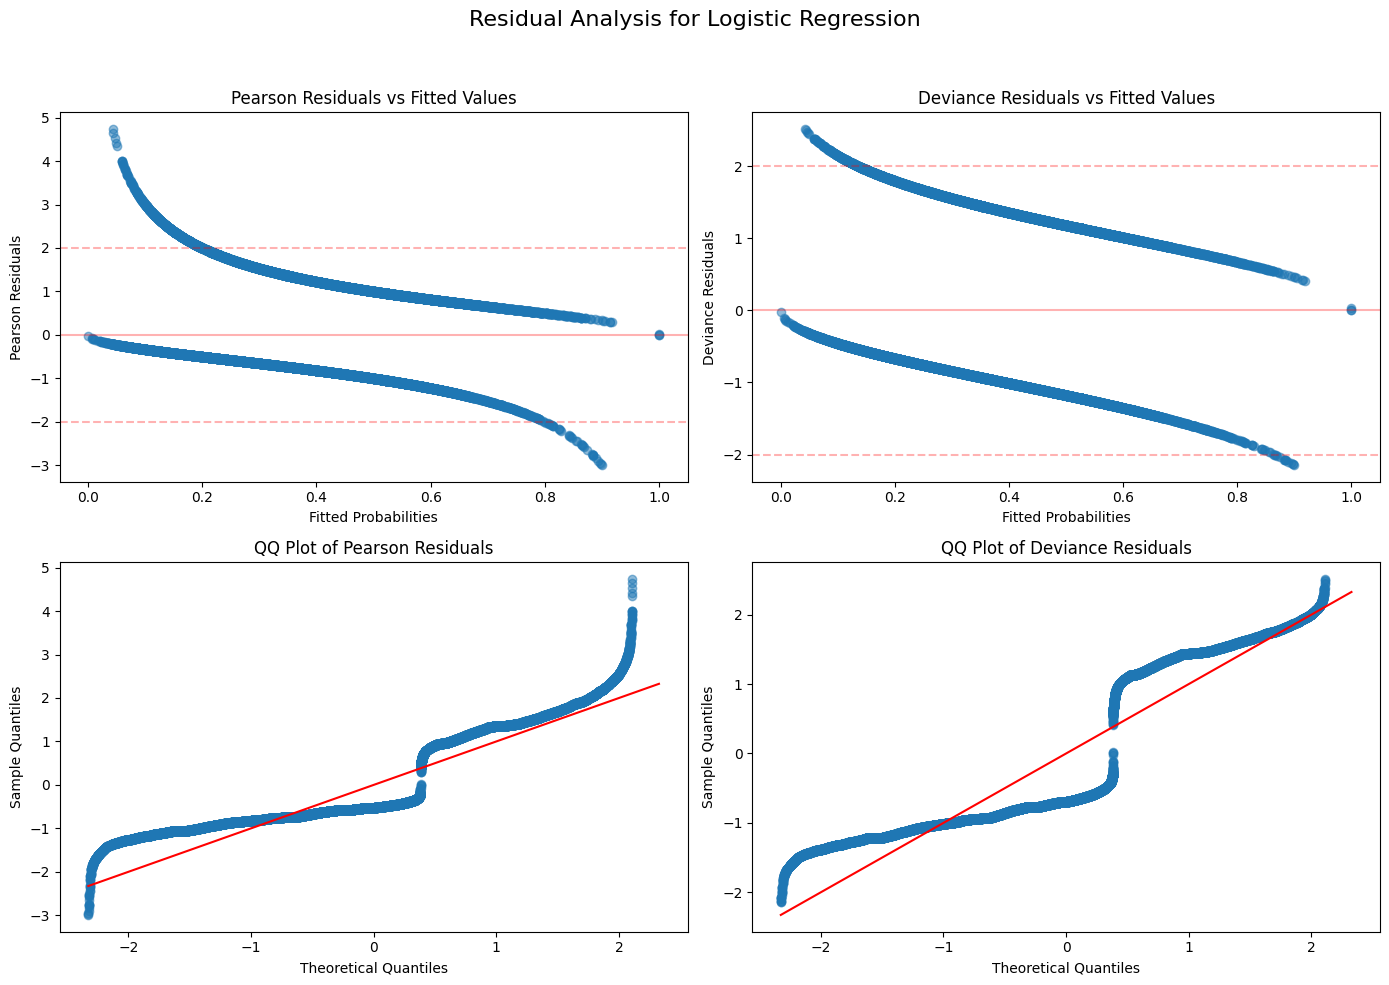

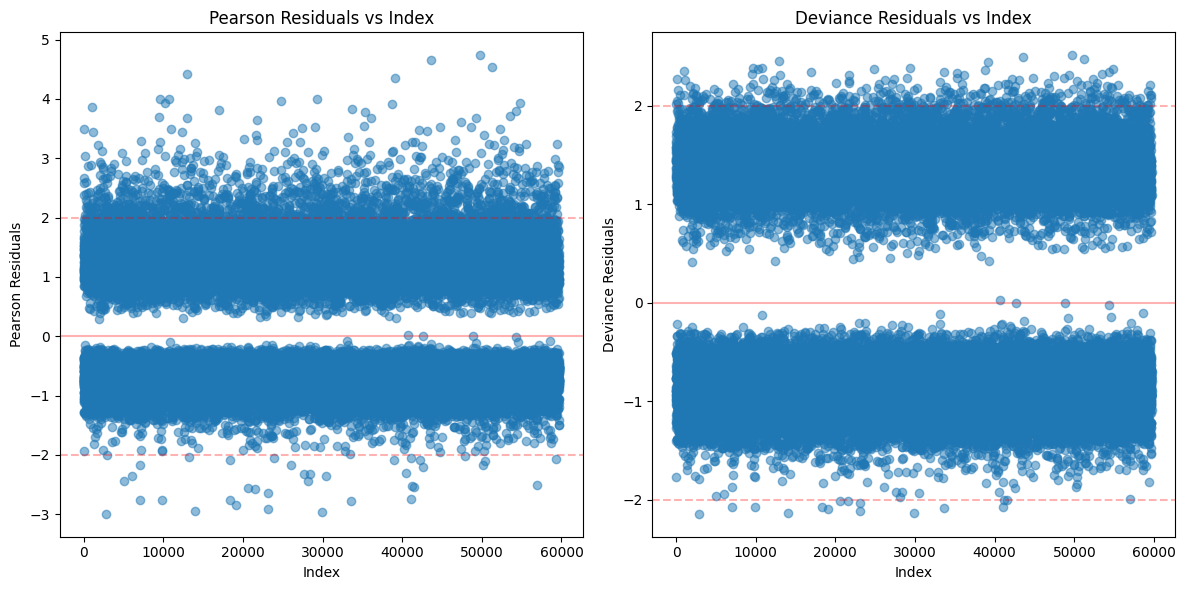


Possible outliers (observations with |Pearson residuals| > 2):
Indices: [   27    58    61 ... 59537 59596 59664]
Counts: 1367 (2.29% of observations)


In [41]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# After fitting your model with statsmodels (assuming you've created a final model with interactions)
# Create a final model with all significant interactions
X_final = X_train_with_interactions.copy()
X_final = sm.add_constant(X_final, has_constant='add')
final_model = sm.Logit(y_train, X_final).fit(disp=False)

# Get predictions for the training set
y_pred_proba = final_model.predict()
y_pred_class = (y_pred_proba > 0.5).astype(int)

# Calculate residuals
pearson_residuals = final_model.resid_pearson
deviance_residuals = final_model.resid_dev

# Create figure with 2x2 subplots for comprehensive residual analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Residual Analysis for Logistic Regression', fontsize=16)

# 1. Pearson Residuals vs Fitted Values
axes[0, 0].scatter(y_pred_proba, pearson_residuals, alpha=0.5)
axes[0, 0].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[0, 0].axhline(y=2, color='r', linestyle='--', alpha=0.3)
axes[0, 0].axhline(y=-2, color='r', linestyle='--', alpha=0.3)
axes[0, 0].set_xlabel('Fitted Probabilities')
axes[0, 0].set_ylabel('Pearson Residuals')
axes[0, 0].set_title('Pearson Residuals vs Fitted Values')

# 2. Deviance Residuals vs Fitted Values
axes[0, 1].scatter(y_pred_proba, deviance_residuals, alpha=0.5)
axes[0, 1].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[0, 1].axhline(y=2, color='r', linestyle='--', alpha=0.3)
axes[0, 1].axhline(y=-2, color='r', linestyle='--', alpha=0.3)
axes[0, 1].set_xlabel('Fitted Probabilities')
axes[0, 1].set_ylabel('Deviance Residuals')
axes[0, 1].set_title('Deviance Residuals vs Fitted Values')

# 3. QQ plot for Pearson Residuals
sorted_pearson = np.sort(pearson_residuals)
theoretical_quantiles = stats.norm.ppf(np.linspace(0.01, 0.99, len(sorted_pearson)))
axes[1, 0].scatter(theoretical_quantiles, sorted_pearson, alpha=0.5)
axes[1, 0].plot(theoretical_quantiles, theoretical_quantiles, color='r', linestyle='-')
axes[1, 0].set_xlabel('Theoretical Quantiles')
axes[1, 0].set_ylabel('Sample Quantiles')
axes[1, 0].set_title('QQ Plot of Pearson Residuals')

# 4. QQ plot for Deviance Residuals
sorted_deviance = np.sort(deviance_residuals)
axes[1, 1].scatter(theoretical_quantiles, sorted_deviance, alpha=0.5)
axes[1, 1].plot(theoretical_quantiles, theoretical_quantiles, color='r', linestyle='-')
axes[1, 1].set_xlabel('Theoretical Quantiles')
axes[1, 1].set_ylabel('Sample Quantiles')
axes[1, 1].set_title('QQ Plot of Deviance Residuals')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the title
plt.show()

# Additional useful plot: Residuals vs Index (to check for patterns over observation sequence)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(range(len(pearson_residuals)), pearson_residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.axhline(y=2, color='r', linestyle='--', alpha=0.3)
plt.axhline(y=-2, color='r', linestyle='--', alpha=0.3)
plt.xlabel('Index')
plt.ylabel('Pearson Residuals')
plt.title('Pearson Residuals vs Index')

plt.subplot(1, 2, 2)
plt.scatter(range(len(deviance_residuals)), deviance_residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.axhline(y=2, color='r', linestyle='--', alpha=0.3)
plt.axhline(y=-2, color='r', linestyle='--', alpha=0.3)
plt.xlabel('Index')
plt.ylabel('Deviance Residuals')
plt.title('Deviance Residuals vs Index')

plt.tight_layout()
plt.show()

# Identify possible outliers (observations with absolute residuals > 2)
possible_outliers = np.where(np.abs(pearson_residuals) > 2)[0]
if len(possible_outliers) > 0:
    print("\nPossible outliers (observations with |Pearson residuals| > 2):")
    print(f"Indices: {possible_outliers}")
    print(f"Counts: {len(possible_outliers)} ({len(possible_outliers)/len(pearson_residuals)*100:.2f}% of observations)")
else:
    print("\nNo severe outliers detected using Pearson residuals.")

In [42]:
# 2 - see above


-------- Goodness of Fit Tests --------

Hosmer-Lemeshow Test:
Chi-square: 1166.1891
Degrees of freedom: 8
p-value: 0.0000
Interpretation: Low p-value (<0.05) suggests poor model fit.

Pseudo R² Measures:
McFadden R²: 0.0796
Cox & Snell R²: 0.0977
Nagelkerke R²: 0.1347
Tjur's Coefficient of Discrimination R²: 0.0977


/Users/jonah/.pyenv/versions/3.10.16/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


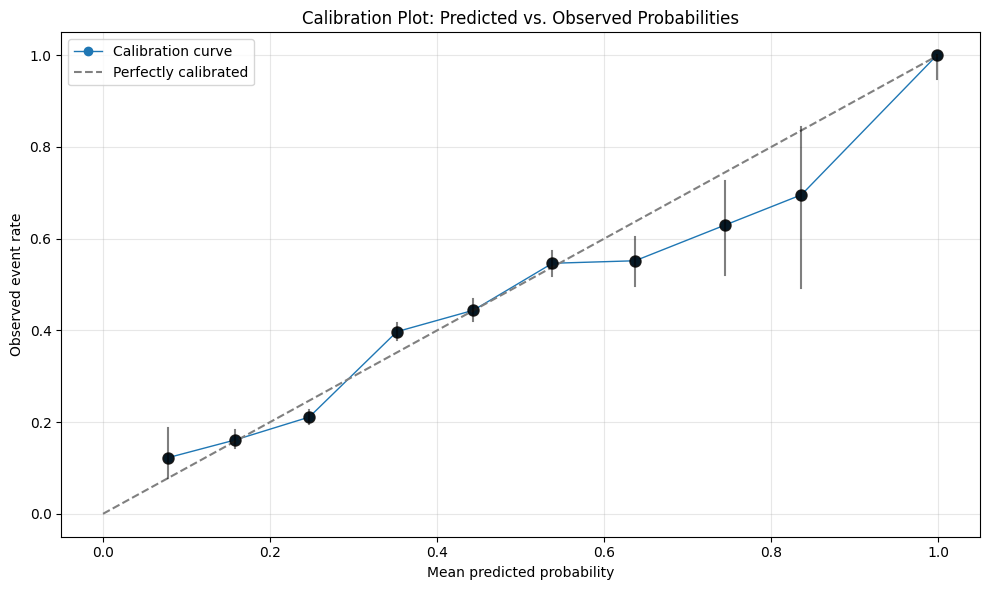

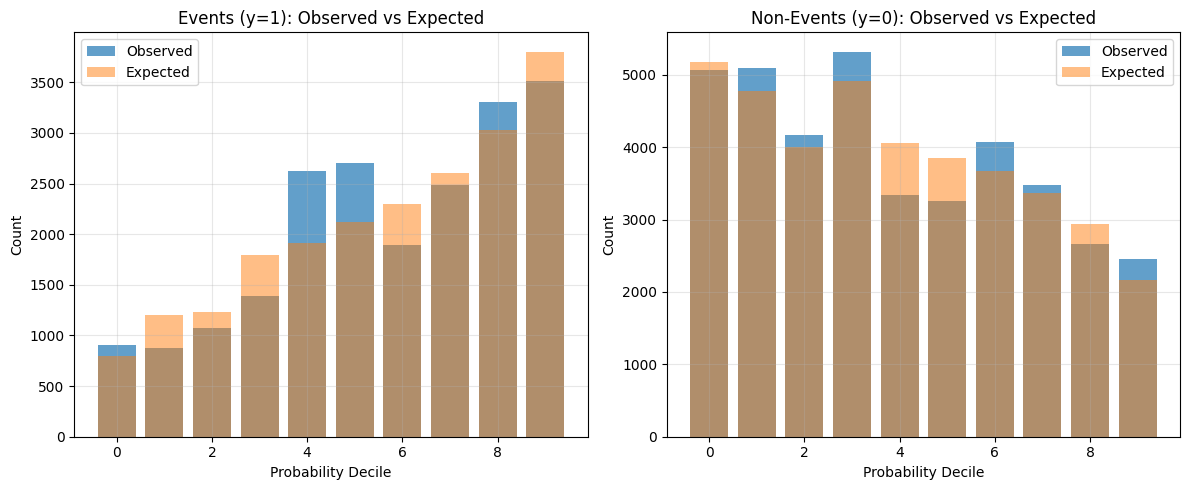


Model Fit Summary:
- Hosmer-Lemeshow p-value: 0.0000 (Poor fit)
- McFadden's R²: 0.0796 (Poor)
- Nagelkerke R²: 0.1347


In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# ---- Goodness of Fit Tests ----

# 1. Hosmer-Lemeshow Test
def hosmer_lemeshow_test(y_true, y_pred_proba, n_groups=10):
    """
    Implementation of the Hosmer-Lemeshow test for logistic regression.
    
    Parameters:
    y_true: True binary labels
    y_pred_proba: Predicted probabilities from the model
    n_groups: Number of groups to divide the data into (default: 10)
    
    Returns:
    chi2_stat: Chi-square statistic
    p_value: p-value for the test
    df: Degrees of freedom
    """
    # Convert to numpy arrays if they're pandas objects
    if hasattr(y_true, 'values'):
        y_true = y_true.values
    if hasattr(y_pred_proba, 'values'):
        y_pred_proba = y_pred_proba.values
    
    # Create groups of equal size
    cutpoints = np.percentile(y_pred_proba, np.linspace(0, 100, n_groups+1))
    cutpoints[0] = 0
    cutpoints[-1] = 1
    
    # Sort by predicted probabilities
    idx_sorted = np.argsort(y_pred_proba)
    y_true_sorted = y_true[idx_sorted]
    y_pred_sorted = y_pred_proba[idx_sorted]
    
    # Initialize arrays for observed and expected values
    observed = np.zeros((n_groups, 2))
    expected = np.zeros((n_groups, 2))
    
    # Calculate observed and expected for each group
    chi2_stat = 0
    for i in range(n_groups):
        # Find observations in this group
        if i < n_groups - 1:
            idx_group = (y_pred_sorted >= cutpoints[i]) & (y_pred_sorted < cutpoints[i+1])
        else:
            idx_group = (y_pred_sorted >= cutpoints[i]) & (y_pred_sorted <= cutpoints[i+1])
        
        # Skip empty groups
        n_obs = np.sum(idx_group)
        if n_obs == 0:
            continue
        
        # Observed values
        observed[i, 1] = np.sum(y_true_sorted[idx_group])  # Events (y=1)
        observed[i, 0] = n_obs - observed[i, 1]            # Non-events (y=0)
        
        # Expected values
        prob_group = np.mean(y_pred_sorted[idx_group])
        expected[i, 1] = n_obs * prob_group               # Expected events
        expected[i, 0] = n_obs * (1 - prob_group)         # Expected non-events
        
        # Calculate chi-square contribution for this group
        # Add a small epsilon to avoid division by zero
        epsilon = 1e-10
        chi2_contribution = ((observed[i, 0] - expected[i, 0])**2 / (expected[i, 0] + epsilon))
        chi2_contribution += ((observed[i, 1] - expected[i, 1])**2 / (expected[i, 1] + epsilon))
        chi2_stat += chi2_contribution
    
    # Degrees of freedom = n_groups - 2
    df = n_groups - 2
    p_value = 1 - stats.chi2.cdf(chi2_stat, df)
    
    return chi2_stat, p_value, df, observed, expected

# Run the Hosmer-Lemeshow test on TRAINING set
# Make sure we're using the predicted probabilities from the final_model
y_pred_proba_train = final_model.predict(X_final)
hl_chi2, hl_pval, hl_df, observed, expected = hosmer_lemeshow_test(y_train, y_pred_proba_train, n_groups=10)

# 2. Multiple Pseudo R² Measures
def calculate_pseudo_r2(model, y, X):
    """
    Calculate various Pseudo R² measures for logistic regression.
    
    Parameters:
    model: Fitted statsmodels logistic regression model
    y: True binary labels
    X: Feature matrix used for prediction
    
    Returns:
    dict: Dictionary with different pseudo R² values
    """
    # Log-likelihoods
    ll_model = model.llf                   # Log-likelihood of the model
    ll_null = model.llnull                 # Log-likelihood of the null model
    
    # McFadden's R²: 1 - (LL_model / LL_null)
    mcfadden_r2 = 1 - (ll_model / ll_null)
    
    # Cox & Snell R²: 1 - exp(2*(LL_null - LL_model)/n)
    n = len(y)
    cox_snell_r2 = 1 - np.exp(2 * (ll_null - ll_model) / n)
    
    # Nagelkerke R²: Cox & Snell R² / (1 - exp(2*LL_null/n))
    nagelkerke_r2 = cox_snell_r2 / (1 - np.exp(2 * ll_null / n))
    
    # Tjur's R² (Coefficient of Discrimination):
    # Difference in mean predicted probabilities between events and non-events
    y_pred = model.predict(X)
    
    # Convert to numpy arrays if they're pandas objects
    if hasattr(y, 'values'):
        y = y.values
    if hasattr(y_pred, 'values'):
        y_pred = y_pred.values
        
    # Calculate mean predicted probabilities for events and non-events
    tjur_r2 = np.mean(y_pred[y==1]) - np.mean(y_pred[y==0])
    
    # Create dictionary of results
    r2_dict = {
        "McFadden": mcfadden_r2,
        "Cox & Snell": cox_snell_r2,
        "Nagelkerke": nagelkerke_r2,
        "Tjur's Coefficient of Discrimination": tjur_r2
    }
    
    return r2_dict

# Calculate Pseudo R² measures
pseudo_r2 = calculate_pseudo_r2(final_model, y_train, X_final)

# Print results
print("\n-------- Goodness of Fit Tests --------")
print("\nHosmer-Lemeshow Test:")
print(f"Chi-square: {hl_chi2:.4f}")
print(f"Degrees of freedom: {hl_df}")
print(f"p-value: {hl_pval:.4f}")
if hl_pval > 0.05:
    print("Interpretation: High p-value (>0.05) suggests the model fits the data well.")
else:
    print("Interpretation: Low p-value (<0.05) suggests poor model fit.")

# Print Pseudo R² results
print("\nPseudo R² Measures:")
for name, value in pseudo_r2.items():
    print(f"{name} R²: {value:.4f}")

# Create a custom calibration plot without using sklearn's calibration_curve
def create_calibration_plot(y_true, y_pred_proba, n_bins=10):
    """
    Create a calibration plot comparing predicted probabilities to observed outcomes.
    
    Parameters:
    y_true: True binary labels
    y_pred_proba: Predicted probabilities
    n_bins: Number of bins for grouping predictions
    """
    # Convert to numpy arrays if needed
    if hasattr(y_true, 'values'):
        y_true = y_true.values
    if hasattr(y_pred_proba, 'values'):
        y_pred_proba = y_pred_proba.values
    
    # Create bins of equal width
    bin_edges = np.linspace(0, 1, n_bins+1)
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
    
    # Initialize arrays for observed and predicted probabilities
    prob_true = np.zeros(n_bins)
    prob_pred = np.zeros(n_bins)
    
    # Group predictions and calculate observed rates
    for i in range(n_bins):
        if i < n_bins - 1:
            mask = (y_pred_proba >= bin_edges[i]) & (y_pred_proba < bin_edges[i+1])
        else:
            mask = (y_pred_proba >= bin_edges[i]) & (y_pred_proba <= bin_edges[i+1])
        
        n_samples = np.sum(mask)
        if n_samples > 0:
            prob_true[i] = np.mean(y_true[mask])
            prob_pred[i] = np.mean(y_pred_proba[mask])
        else:
            prob_true[i] = np.nan
            prob_pred[i] = np.nan
    
    # Remove bins with no samples
    valid_idx = ~np.isnan(prob_true)
    prob_true = prob_true[valid_idx]
    prob_pred = prob_pred[valid_idx]
    
    return prob_true, prob_pred, bin_centers

# For test set using sklearn model
plt.figure(figsize=(10, 6))

# Get test set predictions
y_test_array = y_test.values if hasattr(y_test, 'values') else y_test
y_pred_test = logreg.predict_proba(X_test_std)[:,1]

# Create custom calibration plot
prob_true, prob_pred, bin_centers = create_calibration_plot(y_test_array, y_pred_test, n_bins=10)

# Plot calibration curve
plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Calibration curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')

plt.xlabel('Mean predicted probability')
plt.ylabel('Observed event rate')
plt.title('Calibration Plot: Predicted vs. Observed Probabilities')
plt.legend()
plt.grid(True, alpha=0.3)

# Add 95% confidence intervals
n_bins = 10
bin_edges = np.linspace(0, 1, n_bins+1)

# Group predictions into bins
bin_indices = np.digitize(y_pred_test, bin_edges) - 1
bin_indices = np.minimum(bin_indices, n_bins-1)  # Ensure no index exceeds bin count

# Calculate confidence intervals for each bin
for i in range(n_bins):
    mask = bin_indices == i
    n_samples = np.sum(mask)
    
    if n_samples > 0:
        # Calculate observed event rate in bin
        observed_rate = np.mean(y_test_array[mask])
        
        # Calculate Wilson score interval
        z = 1.96  # 95% confidence
        
        # Wilson score interval
        denominator = 1 + z**2/n_samples
        center = (observed_rate + z**2/(2*n_samples))/denominator
        halfwidth = z * np.sqrt(observed_rate*(1-observed_rate)/n_samples + z**2/(4*n_samples**2))/denominator
        
        lower = max(0, center - halfwidth)
        upper = min(1, center + halfwidth)
        
        # Plot confidence interval
        plt.plot([prob_pred[i], prob_pred[i]], [lower, upper], 'k-', alpha=0.5)
        plt.plot([prob_pred[i]], [observed_rate], 'ko', ms=8, alpha=0.8)

plt.tight_layout()
plt.show()

# Plot observed vs expected counts from Hosmer-Lemeshow test
plt.figure(figsize=(12, 5))

# Plot for events (y=1)
plt.subplot(1, 2, 1)
plt.bar(range(len(observed)), observed[:, 1], alpha=0.7, label='Observed')
plt.bar(range(len(expected)), expected[:, 1], alpha=0.5, label='Expected')
plt.xlabel('Probability Decile')
plt.ylabel('Count')
plt.title('Events (y=1): Observed vs Expected')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot for non-events (y=0)
plt.subplot(1, 2, 2)
plt.bar(range(len(observed)), observed[:, 0], alpha=0.7, label='Observed')
plt.bar(range(len(expected)), expected[:, 0], alpha=0.5, label='Expected')
plt.xlabel('Probability Decile')
plt.ylabel('Count')
plt.title('Non-Events (y=0): Observed vs Expected')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary interpretation
print("\nModel Fit Summary:")
print(f"- Hosmer-Lemeshow p-value: {hl_pval:.4f} ({'Good fit' if hl_pval > 0.05 else 'Poor fit'})")
print(f"- McFadden's R²: {pseudo_r2['McFadden']:.4f} ({'Excellent' if pseudo_r2['McFadden'] > 0.4 else 'Good' if pseudo_r2['McFadden'] > 0.2 else 'Acceptable' if pseudo_r2['McFadden'] > 0.1 else 'Poor'})")
print(f"- Nagelkerke R²: {pseudo_r2['Nagelkerke']:.4f}")

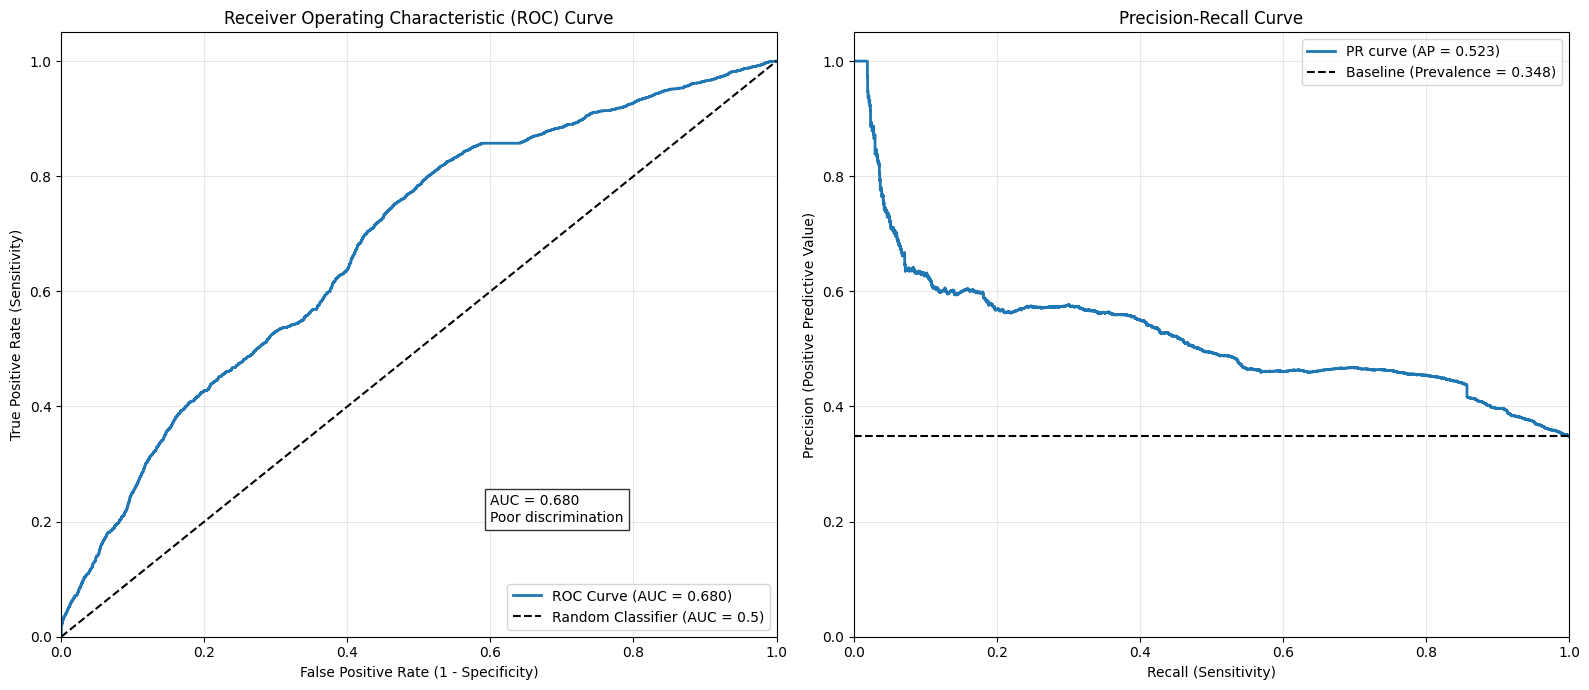

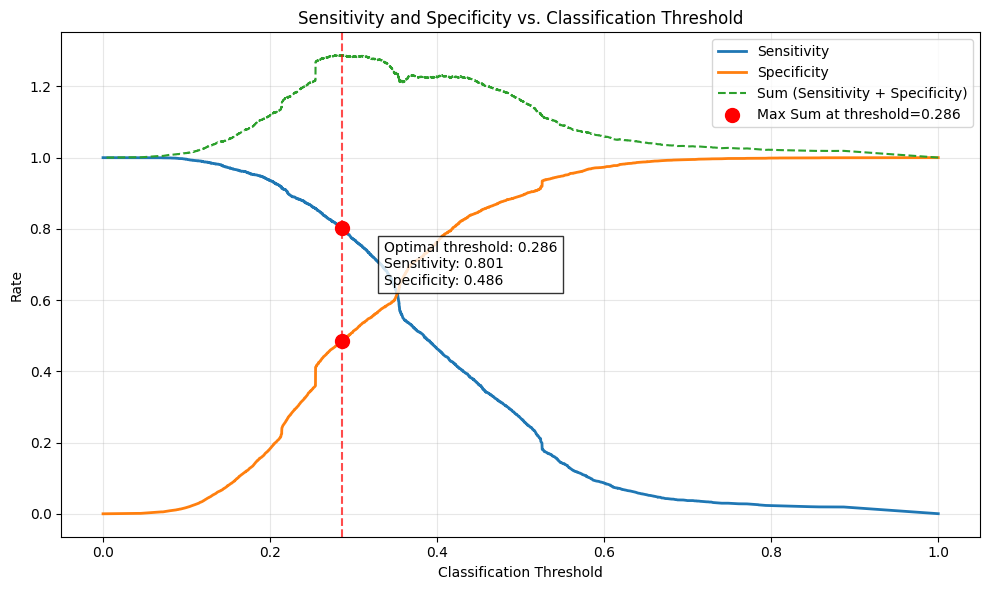

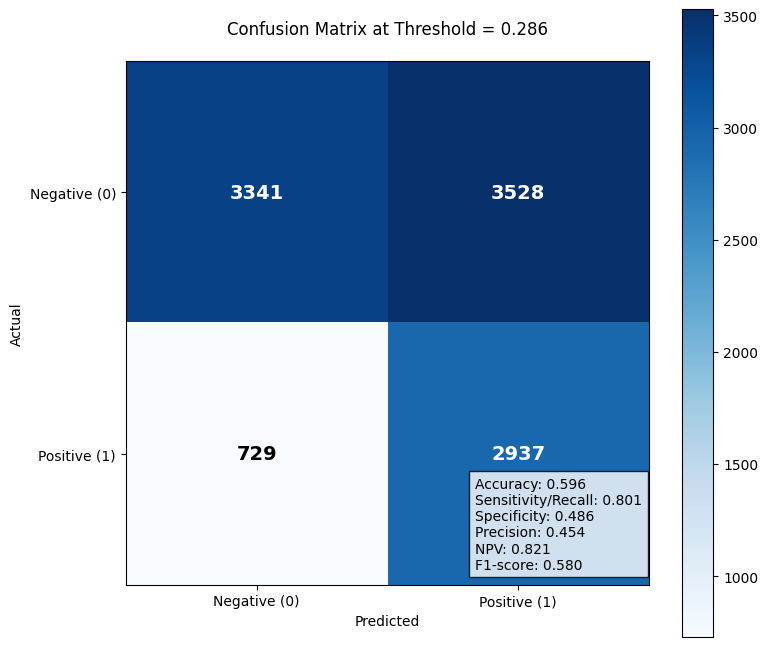


-------- Discrimination Ability --------
AUC (Area Under ROC Curve): 0.6804
Average Precision: 0.5227
Optimal Classification Threshold: 0.2860
At optimal threshold: Sensitivity = 0.8011, Specificity = 0.4864

AUC Interpretation:
Poor discrimination (AUC > 0.6)

Classification Report at Optimal Threshold:
Accuracy: 0.5959
Sensitivity/Recall: 0.8011
Specificity: 0.4864
Precision/PPV: 0.4543
Negative Predictive Value: 0.8209
F1-score: 0.5798

Decision Threshold Discussion:
The optimal threshold of 0.2860 maximizes the sum of sensitivity and specificity.
Consider adjusting this threshold based on your specific application:
- Increase threshold: Higher specificity, lower sensitivity (fewer false positives)
- Decrease threshold: Higher sensitivity, lower specificity (fewer false negatives)
Choose based on which error type is more costly in your application context.


In [48]:
# 4 discrimiationa nalysis 

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.calibration import calibration_curve

# ---- Discrimination Ability ----

def plot_discrimination_metrics(y_true, y_pred_proba):
    """
    Plot ROC curve, Precision-Recall curve, and calculate metrics that evaluate
    the discrimination ability of a binary classifier.
    
    Parameters:
    y_true: True binary labels
    y_pred_proba: Predicted probabilities from the model
    """
    # Convert to numpy arrays if needed
    if hasattr(y_true, 'values'):
        y_true = y_true.values
    if hasattr(y_pred_proba, 'values'):
        y_pred_proba = y_pred_proba.values
    
    # Create a figure with 2 subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # 1. ROC Curve (Left plot)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    auc = roc_auc_score(y_true, y_pred_proba)
    
    axes[0].plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})', linewidth=2)
    axes[0].plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5)')
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_ylim([0.0, 1.05])
    axes[0].set_xlabel('False Positive Rate (1 - Specificity)')
    axes[0].set_ylabel('True Positive Rate (Sensitivity)')
    axes[0].set_title('Receiver Operating Characteristic (ROC) Curve')
    axes[0].legend(loc='lower right')
    axes[0].grid(True, alpha=0.3)
    
    # Add AUC interpretation
    auc_text = f'AUC = {auc:.3f}\n'
    if auc > 0.9:
        auc_text += 'Excellent discrimination'
    elif auc > 0.8:
        auc_text += 'Good discrimination'
    elif auc > 0.7:
        auc_text += 'Acceptable discrimination'
    elif auc > 0.6:
        auc_text += 'Poor discrimination'
    else:
        auc_text += 'Failed discrimination'
    
    axes[0].text(0.6, 0.2, auc_text, bbox=dict(facecolor='white', alpha=0.8))
    
    # 2. Precision-Recall Curve (Right plot)
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    avg_precision = average_precision_score(y_true, y_pred_proba)
    
    # Calculate baseline for an uninformative model
    baseline = np.mean(y_true)
    
    axes[1].plot(recall, precision, label=f'PR curve (AP = {avg_precision:.3f})', linewidth=2)
    axes[1].axhline(y=baseline, color='k', linestyle='--', label=f'Baseline (Prevalence = {baseline:.3f})')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('Recall (Sensitivity)')
    axes[1].set_ylabel('Precision (Positive Predictive Value)')
    axes[1].set_title('Precision-Recall Curve')
    axes[1].legend(loc='best')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Create a new figure for the Sensitivity/Specificity vs Threshold plot
    plt.figure(figsize=(10, 6))
    
    # Filter thresholds to a reasonable range (avoiding extreme values)
    valid_idx = (thresholds >= 0) & (thresholds <= 1)
    thresholds = thresholds[valid_idx]
    fpr_valid = fpr[valid_idx]
    tpr_valid = tpr[valid_idx]
    
    # Compute specificity (1 - fpr)
    specificity = 1 - fpr_valid
    
    # Plot sensitivity and specificity as functions of threshold
    plt.plot(thresholds, tpr_valid, label='Sensitivity', linewidth=2)
    plt.plot(thresholds, specificity, label='Specificity', linewidth=2)
    plt.plot(thresholds, tpr_valid + specificity, label='Sum (Sensitivity + Specificity)', linewidth=1.5, linestyle='--')
    
    # Find the threshold that maximizes the sum of sensitivity and specificity
    optimal_idx = np.argmax(tpr_valid + specificity)
    optimal_threshold = thresholds[optimal_idx]
    optimal_sens = tpr_valid[optimal_idx]
    optimal_spec = specificity[optimal_idx]
    
    # Add a marker for the optimal threshold
    plt.scatter([optimal_threshold], [optimal_sens], s=100, color='red', zorder=3, label=f'Max Sum at threshold={optimal_threshold:.3f}')
    plt.scatter([optimal_threshold], [optimal_spec], s=100, color='red', zorder=3)
    
    plt.axvline(x=optimal_threshold, color='red', linestyle='--', alpha=0.7)
    
    plt.xlabel('Classification Threshold')
    plt.ylabel('Rate')
    plt.title('Sensitivity and Specificity vs. Classification Threshold')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    
    # Add text annotation for optimal threshold
    plt.text(
        optimal_threshold + 0.05, 
        (optimal_sens + optimal_spec) / 2, 
        f'Optimal threshold: {optimal_threshold:.3f}\nSensitivity: {optimal_sens:.3f}\nSpecificity: {optimal_spec:.3f}',
        bbox=dict(facecolor='white', alpha=0.8)
    )
    
    plt.tight_layout()
    
    # Return key metrics
    metrics = {
        'AUC': auc,
        'Average Precision': avg_precision,
        'Optimal Threshold': optimal_threshold,
        'Sensitivity at Optimal': optimal_sens,
        'Specificity at Optimal': optimal_spec
    }
    
    return metrics

# Get predictions for the test set
y_test_array = y_test.values if hasattr(y_test, 'values') else y_test
y_pred_test_proba = logreg.predict_proba(X_test_std)[:, 1]

# Plot discrimination metrics and get key results
metrics = plot_discrimination_metrics(y_test_array, y_pred_test_proba)

# Get predicted class at optimal threshold
optimal_threshold = metrics['Optimal Threshold']
y_pred_optimal = (y_pred_test_proba >= optimal_threshold).astype(int)

# Calculate metrics at optimal threshold
from sklearn.metrics import confusion_matrix, classification_report

conf_matrix = confusion_matrix(y_test_array, y_pred_optimal)
class_report = classification_report(y_test_array, y_pred_optimal, output_dict=True)

# For visualization, create a confusion matrix plot
plt.figure(figsize=(8, 7))
cm_display = np.array([
    [conf_matrix[0, 0], conf_matrix[0, 1]],
    [conf_matrix[1, 0], conf_matrix[1, 1]]
])

# Calculate metrics from confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
npv = tn / (tn + fn) if (tn + fn) > 0 else 0
accuracy = (tp + tn) / (tp + tn + fp + fn)
f1 = 2 * precision * sensitivity / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

# Plot confusion matrix with annotations
plt.imshow(cm_display, cmap='Blues')
for (i, j), value in np.ndenumerate(cm_display):
    plt.text(j, i, f"{value}", ha='center', va='center', fontsize=14, weight='bold', color='white' if value > cm_display.max()/2 else 'black')

plt.colorbar()
plt.title(f'Confusion Matrix at Threshold = {optimal_threshold:.3f}', pad=20)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0, 1], ['Negative (0)', 'Positive (1)'])
plt.yticks([0, 1], ['Negative (0)', 'Positive (1)'])

# Add metrics as a text box
metrics_text = (
    f"Accuracy: {accuracy:.3f}\n"
    f"Sensitivity/Recall: {sensitivity:.3f}\n"
    f"Specificity: {specificity:.3f}\n"
    f"Precision: {precision:.3f}\n"
    f"NPV: {npv:.3f}\n"
    f"F1-score: {f1:.3f}"
)

plt.figtext(0.6, 0.15, metrics_text, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Display overall discrimination metrics
print("\n-------- Discrimination Ability --------")
print(f"AUC (Area Under ROC Curve): {metrics['AUC']:.4f}")
print(f"Average Precision: {metrics['Average Precision']:.4f}")
print(f"Optimal Classification Threshold: {metrics['Optimal Threshold']:.4f}")
print(f"At optimal threshold: Sensitivity = {sensitivity:.4f}, Specificity = {specificity:.4f}")

# AUC interpretation
print("\nAUC Interpretation:")
if metrics['AUC'] > 0.9:
    print("Excellent discrimination (AUC > 0.9)")
elif metrics['AUC'] > 0.8:
    print("Good discrimination (AUC > 0.8)")
elif metrics['AUC'] > 0.7:
    print("Acceptable discrimination (AUC > 0.7)")
elif metrics['AUC'] > 0.6:
    print("Poor discrimination (AUC > 0.6)")
else:
    print("Failed discrimination (AUC ≤ 0.6)")

# Print classification report at optimal threshold
print("\nClassification Report at Optimal Threshold:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity/Recall: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision/PPV: {precision:.4f}")
print(f"Negative Predictive Value: {npv:.4f}")
print(f"F1-score: {f1:.4f}")

# Decision threshold discussion
print("\nDecision Threshold Discussion:")
print(f"The optimal threshold of {optimal_threshold:.4f} maximizes the sum of sensitivity and specificity.")
print("Consider adjusting this threshold based on your specific application:")
print("- Increase threshold: Higher specificity, lower sensitivity (fewer false positives)")
print("- Decrease threshold: Higher sensitivity, lower specificity (fewer false negatives)")
print("Choose based on which error type is more costly in your application context.")

/Users/jonah/.pyenv/versions/3.10.16/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss



-------- Multicollinearity Check --------

Variance Inflation Factors (VIF):
                     Feature       VIF  High_Multicollinearity
6      diversification_index  3.819661                   False
8                   win_rate  3.501630                   False
20             gini_bet_size  2.103215                   False
15           kelly_criterion  2.015582                   False
4     intraday_closeout_rate  1.624731                   False
7            stop_loss_index  1.412613                   False
3             risk_tolerance  1.371004                   False
12        trading_confidence  1.370198                   False
1                   momentum  1.283628                   False
2       average_holding_time  1.270486                   False
19             outlier_ratio  1.241895                   False
14              risk_of_ruin  1.207882                   False
21          panic_sell_score  1.180683                   False
5     order_clustering_score  1.082654  

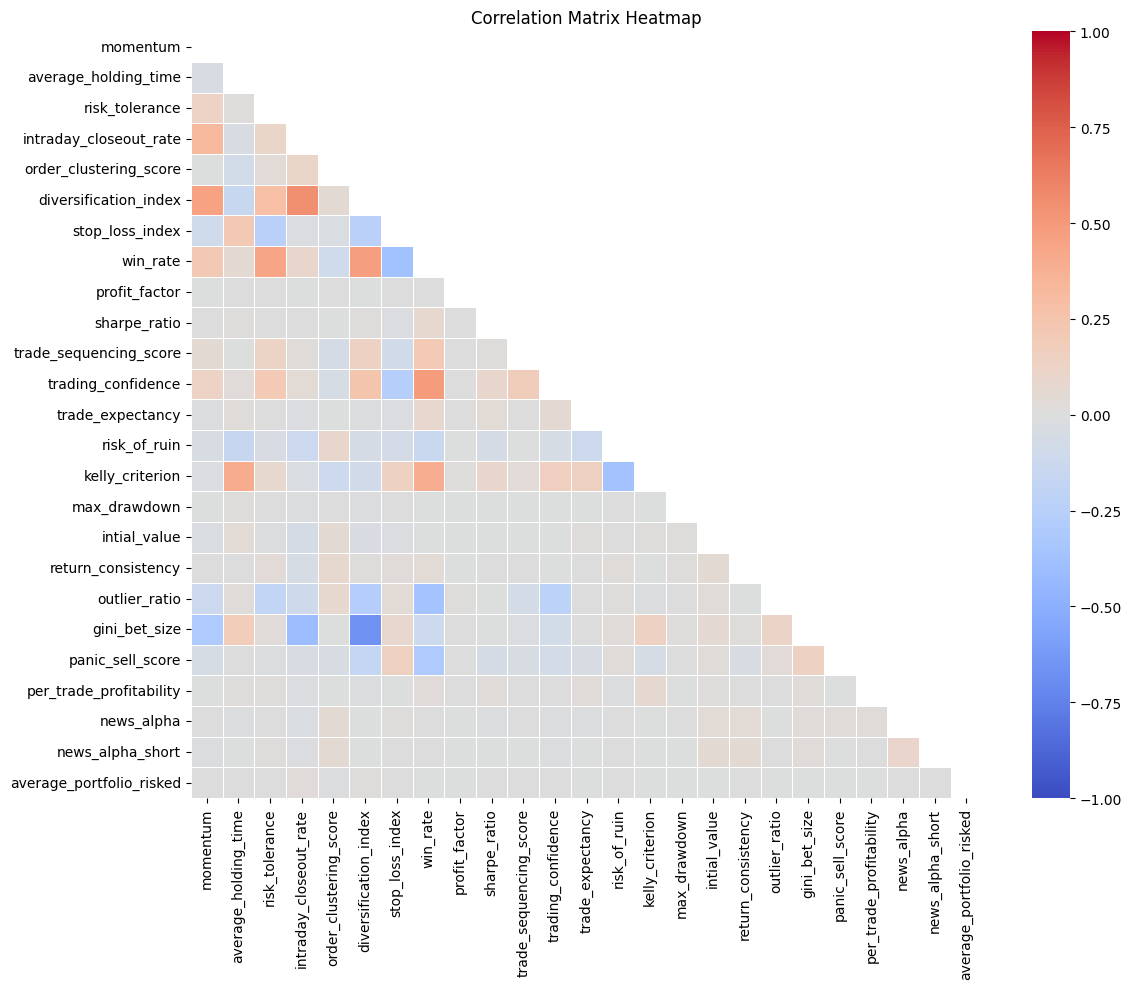


No highly correlated feature pairs detected (all |r| <= 0.7).


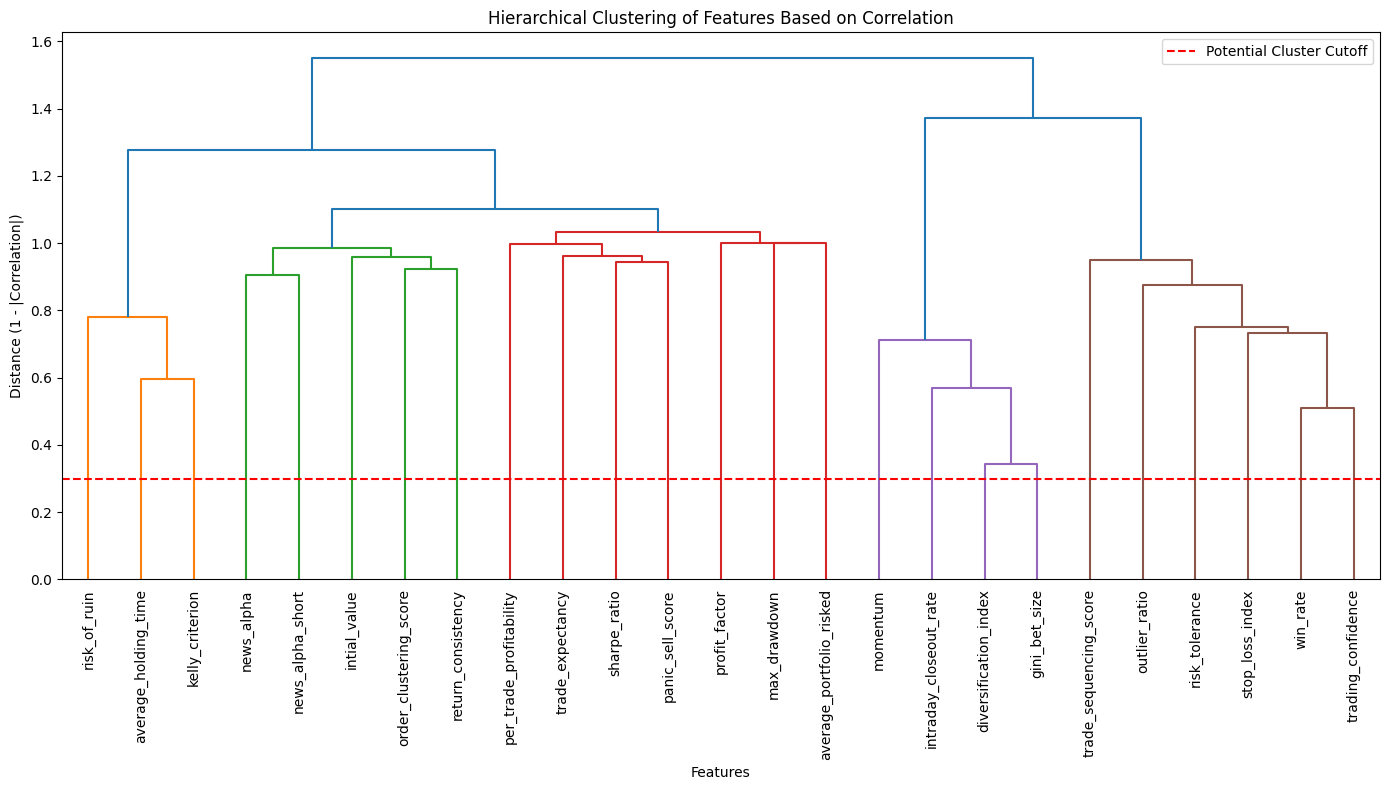

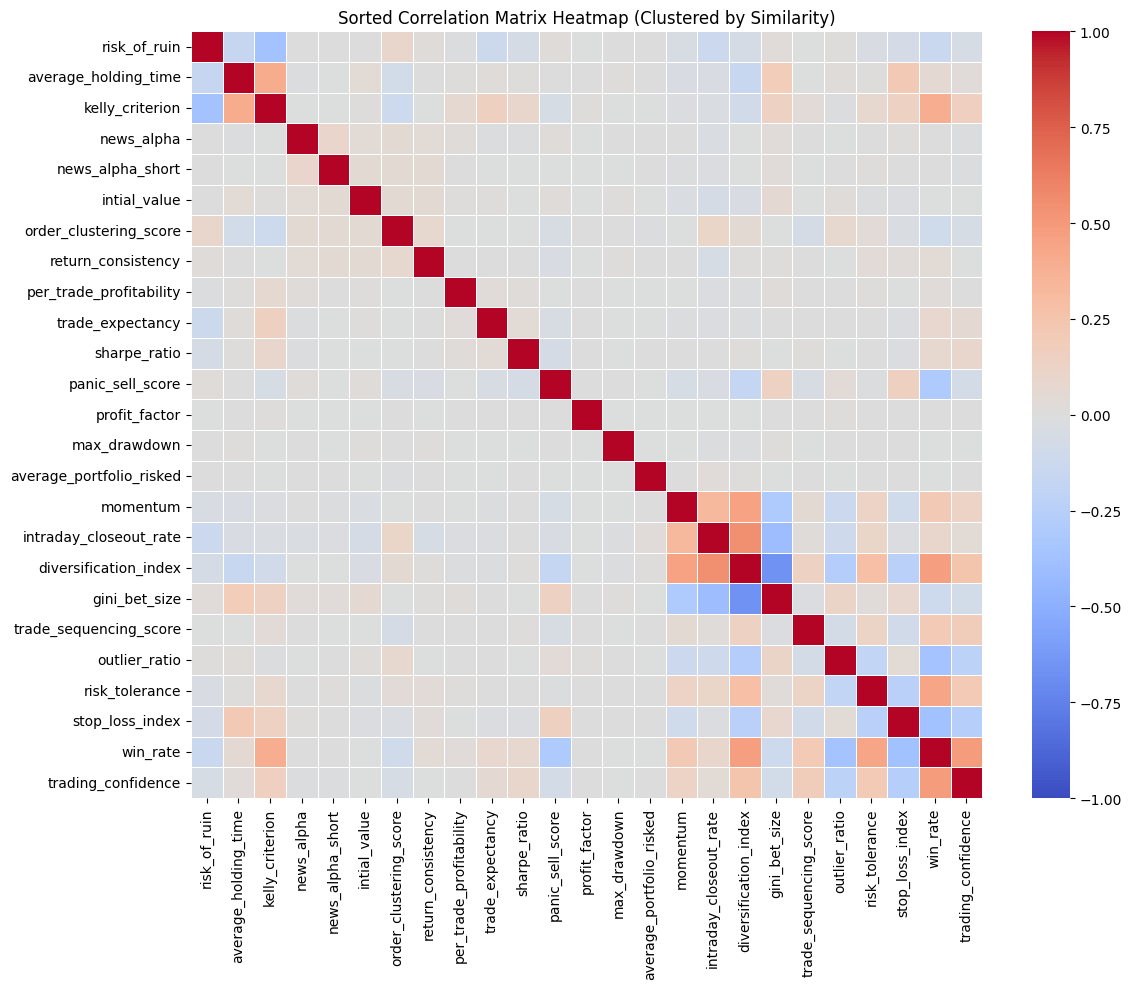


Multicollinearity Summary:
1. VIF Analysis:
   - Features with VIF > 5: 0

2. Correlation Analysis:
   - Feature pairs with |r| > 0.7: 0

3. Recommendations:
   - No severe multicollinearity detected
   - Model coefficients should be stable and interpretable


In [49]:
# 5 multicollinearity check!
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ---- Multicollinearity Check ----

def check_multicollinearity(X, threshold=5):
    """
    Check for multicollinearity in predictor variables.
    
    Parameters:
    X: Feature matrix (pandas DataFrame)
    threshold: VIF threshold above which to flag multicollinearity (default: 5)
    
    Returns:
    DataFrame with VIF values for each feature
    """
    # Create a copy of X to avoid modifying the original
    X_vif = X.copy()
    
    # Check if X already has a constant
    has_const = np.any(np.all(X_vif == 1, axis=0))
    
    # Add a constant if it doesn't exist
    if not has_const:
        X_vif = sm.add_constant(X_vif, has_constant='add')
    
    # Calculate VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X_vif.columns
    vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
    
    # Sort by VIF value in descending order
    vif_data = vif_data.sort_values("VIF", ascending=False)
    
    # Flag high VIF values
    vif_data["High_Multicollinearity"] = vif_data["VIF"] > threshold
    
    return vif_data

# Calculate VIF for training features
# Make sure X_train is a DataFrame with column names
if not isinstance(X_train, pd.DataFrame):
    X_train_df = pd.DataFrame(X_train, columns=[f"Feature_{i}" for i in range(X_train.shape[1])])
else:
    X_train_df = X_train.copy()

# Check multicollinearity
vif_results = check_multicollinearity(X_train_df, threshold=5)

# Display VIF results
print("\n-------- Multicollinearity Check --------")
print("\nVariance Inflation Factors (VIF):")
print(vif_results)

# Print warning for high multicollinearity
high_multicollinearity = vif_results[vif_results["High_Multicollinearity"]]
if len(high_multicollinearity) > 0:
    print("\nWarning: High multicollinearity detected in the following features:")
    for feature, vif in zip(high_multicollinearity["Feature"], high_multicollinearity["VIF"]):
        print(f"- {feature}: VIF = {vif:.2f}")
    print("\nConsider removing or combining these features to improve model stability.")
else:
    print("\nNo high multicollinearity detected (all VIF values < 5).")

# Create a correlation matrix heatmap
plt.figure(figsize=(12, 10))
corr_matrix = X_train_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', 
            vmin=-1, vmax=1, center=0, linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()

# Identify highly correlated feature pairs
high_corr_threshold = 0.7
high_corr_pairs = []

# Get upper triangle of correlation matrix
corr_arr = corr_matrix.values
corr_mask = np.triu(np.ones(corr_arr.shape), k=1).astype(bool)
corr_arr_upper = corr_arr[corr_mask]
feature_pairs = [(corr_matrix.columns[i], corr_matrix.columns[j]) 
                 for i in range(len(corr_matrix.columns)) 
                 for j in range(i+1, len(corr_matrix.columns))]

# Identify pairs with high correlation
for idx, (feat1, feat2) in enumerate(feature_pairs):
    if idx < len(corr_arr_upper):  # Check to make sure we don't go out of bounds
        corr_value = corr_arr_upper[idx]
        if abs(corr_value) > high_corr_threshold:
            high_corr_pairs.append((feat1, feat2, corr_value))

# Print high correlation pairs
if high_corr_pairs:
    print("\nHighly Correlated Feature Pairs (|r| > 0.7):")
    for feat1, feat2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
        print(f"- {feat1} and {feat2}: r = {corr:.4f}")
    print("\nConsider removing one feature from each highly correlated pair.")
else:
    print("\nNo highly correlated feature pairs detected (all |r| <= 0.7).")

# Additional: Create a dendrogram to visualize feature clustering based on correlation
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

# Convert correlation matrix to distance matrix
corr_linkage = hierarchy.ward(squareform(1 - np.abs(corr_matrix)))

# Create dendrogram
plt.figure(figsize=(14, 8))
dendro = hierarchy.dendrogram(
    corr_linkage, labels=corr_matrix.columns, leaf_rotation=90,
    leaf_font_size=10
)
plt.title('Hierarchical Clustering of Features Based on Correlation')
plt.xlabel('Features')
plt.ylabel('Distance (1 - |Correlation|)')
plt.axhline(y=0.3, color='r', linestyle='--', label='Potential Cluster Cutoff')
plt.legend()
plt.tight_layout()
plt.show()

# Create a sorted correlation matrix based on the clustering
def sort_corr_matrix(corr_matrix, dendro):
    # Get the leaves (original indices) in the order they appear in the dendrogram
    dendro_leaves = dendro['leaves']
    # Reorder the correlation matrix columns and rows based on the dendrogram
    reordered_corr = corr_matrix.iloc[dendro_leaves, dendro_leaves]
    return reordered_corr

# Create sorted correlation matrix heatmap
plt.figure(figsize=(12, 10))
reordered_corr = sort_corr_matrix(corr_matrix, dendro)
sns.heatmap(reordered_corr, annot=False, cmap='coolwarm', vmin=-1, vmax=1, 
            center=0, linewidths=0.5)
plt.title('Sorted Correlation Matrix Heatmap (Clustered by Similarity)')
plt.tight_layout()
plt.show()

# Multicollinearity summary
print("\nMulticollinearity Summary:")
print("1. VIF Analysis:")
print(f"   - Features with VIF > 5: {len(high_multicollinearity)}")
if len(high_multicollinearity) > 0:
    print(f"   - Highest VIF: {vif_results['VIF'].max():.2f} for feature '{vif_results.iloc[0]['Feature']}'")

print("\n2. Correlation Analysis:")
print(f"   - Feature pairs with |r| > 0.7: {len(high_corr_pairs)}")
if high_corr_pairs:
    max_corr_pair = max(high_corr_pairs, key=lambda x: abs(x[2]))
    print(f"   - Highest correlation: |r| = {abs(max_corr_pair[2]):.4f} between '{max_corr_pair[0]}' and '{max_corr_pair[1]}'")
    
print("\n3. Recommendations:")
if len(high_multicollinearity) > 0 or high_corr_pairs:
    print("   - Consider feature selection or dimensionality reduction")
    print("   - Principal Component Analysis (PCA) could address multicollinearity")
    print("   - For interpretability, consider removing one feature from each highly correlated pair")
    print("   - Regularization (Ridge/Lasso) can also help with multicollinearity")
else:
    print("   - No severe multicollinearity detected")
    print("   - Model coefficients should be stable and interpretable")